# Módulo 3 - Análise de Séries Temporais

No curso vamos analisar e manipular dados reais da área da saúde.

Desenvolveremos nosso curso no Google Colaboratory mas você pode ficar livre para nos acompanhar no Colab ou desenvolver em um Jupyter notebook, outras plataformas como Kaggle ou com a sua IDE favorita.

Para desenvolver nosso curso, vamos precisar da base de dados. Em vídeo, mostramos que os dados foram retirados diretamente do [site do Governo do Estado de São Paulo](https://www.seade.gov.br/coronavirus/). Entretanto, para desenvolver este projeto, disponibilizamos uma cópia da base de dados [aqui](https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip).

Você também pode acessar os notebooks de todas as aulas diretamente pelo [github do projeto](https://github.com/alura-cursos/Prophet_covid/tree/main).


# Início

Compilado de células com criação de variáveis e etc pra não ter que rodar o notebook todo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

In [8]:
# my custom matplotlib style
plt.style.use('matplotlib-styles/my_style.mplstyle')

# We don't want burred plots, we want HD plots
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.debug=True

# # font_scale adjustment
sns.set_context('notebook', font_scale=1.2)

# decimal formatter
# pd.options.display.float_format = "{:,.3f}".format

In [3]:
# Aula 1

def read_data():
    # online => https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip
    filepath = 'dados/dados_covid_sp.zip'
    dados = pd.read_csv(filepath, sep = ';')
    dados.datahora = pd.to_datetime(dados.datahora, format="%Y-%m-%d")
    dados_sp = dados.query("nome_munic == 'São Paulo'").copy()

    dados_sp['taxa_de_crescimento_casos'] = dados_sp.loc[:,'casos_novos'].diff()
    dados_sp['taxa_de_crescimento_obitos'] = dados_sp['obitos_novos'].diff()
    dados_sp['ano'] = pd.DatetimeIndex(dados_sp['datahora']).year
    dados_sp['media_movel_casos'] = dados_sp['casos_novos'].rolling(window=7, center=False).mean()
    dados_sp['media_movel_obitos'] = dados_sp['obitos_novos'].rolling(window=7, center=False).mean()
    
    return dados, dados_sp

dados, dados_sp = read_data()

In [4]:
# Aulas 2 e 3 

def cria_dfs(dados_sp):
    df = pd.DataFrame()
    df['ds'] = dados_sp['datahora'][:400]
    df['y'] = dados_sp['casos_novos'][:400]

    df_teste = pd.DataFrame()
    df_teste['ds'] = dados_sp['datahora'][400:]
    df_teste['y'] = dados_sp['casos_novos'][400:]
    
    return df, df_teste

def prophet_plot(df, title, **prophetargs):

    modelo = Prophet(**prophetargs)
    # modelo['cap'] = 6000
    modelo.fit(df)

    dataframefuturo = modelo.make_future_dataframe(periods=43)
    # dataframefuturo['cap'] = 6000

    previsao = modelo.predict(dataframefuturo)

    fig = modelo.plot(previsao)
    fig.gca().set(title=title)
    a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

#     plt.tight_layout()
df, df_teste = cria_dfs(dados_sp)

In [ ]:
def comparing_seasonalities(df_to_fit, periods, seasonality_mode, title, lineplot = False, returns_MAE = True, plot_validation_dots=False, df_validation=df_teste):
    modelo_feriados = Prophet(changepoint_prior_scale=10.0, 
                            holidays=feriados, 
                            seasonality_mode =seasonality_mode)
    modelo_feriados.fit(df_to_fit)
    dataframefuturo = modelo_feriados.make_future_dataframe(periods=periods)
    previsao = modelo_feriados.predict(dataframefuturo)
    fig = modelo_feriados.plot(previsao, figsize=(15,6))
    fig.gca().set(title=title)

    if plot_validation_dots:
        fig.gca().plot(df_validation['ds'], df_validation['y'], 'r.')
    
    if lineplot:
        fig.gca().plot(df_to_fit['ds'], df_to_fit['y'], '0.5')
    modelo_feriados.plot_components(previsao, figsize=(15,8)).suptitle(title + '- Components')
    
    if returns_MAE:
        return previsao, mean_absolute_error(df_to_fit['y'], previsao['yhat'][:400])
    else:
        return previsao, modelo_feriados

# Aula 1 - Entendendo a Série Temporal

O que aprendemos nesta aula?

- Aprendemos o que é uma série temporal;

- Calculamos a taxa de crescimento de um evento em uma série temporal;

- Aprendemos o que é uma média móvel;

- Entendemos o que é correlação e função de autocorrelação.

---
DESAFIOS

Desafio 01: Um notebook sem warnings

Desafio 02: Pico taxa de casos novos coincide com taxa dos óbitos novos.

Desafio 03: Fazer melhorias nos gráficos.

Desafio 04: Gerar o gráfico da média móvel do número de óbitos e mudar os gráficos de casos para barras.

Desafio 05: Mover o número de óbitos alguns dias para verificar o resultado no gráfico.

Desafio 06: Função de correlação cruzada dos óbitos e casos.

Desafio 07: Estudar outros municípios.

Você pode baixar acessar os códigos e dados desta aula por esse [link](https://github.com/alura-cursos/Prophet_covid/blob/aula1/Curso_Series_Temporais_Bootcamp_Aula1.ipynb).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
# rcParams usado nas aulas, mas eu acabei usando o meu
# mpl.rcParams.update({
#     'font.size': 18,
#     'figure.figsize': (15,8)
# })

In [2]:
# online => https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip
filepath = 'dados/dados_covid_sp.zip'
dados = pd.read_csv(filepath, sep = ';')

In [3]:
dados.head()

nome_munic  codigo_ibge  dia  mes    datahora  casos  casos_novos  \
0        Adamantina      3500105   25    2  2020-02-25      0            0   
1            Adolfo      3500204   25    2  2020-02-25      0            0   
2             Aguaí      3500303   25    2  2020-02-25      0            0   
3    Águas da Prata      3500402   25    2  2020-02-25      0            0   
4  Águas de Lindóia      3500501   25    2  2020-02-25      0            0   

       casos_pc    casos_mm7d  obitos  ...               nome_drs cod_drs  \
0  0,000000e+00     0,0000000       0  ...                Marília       5   
1  0,000000e+00     0,0000000       0  ...  São José do Rio Preto      15   
2  0,000000e+00     0,0000000       0  ...  São João da Boa Vista      14   
3  0,000000e+00     0,0000000       0  ...  São João da Boa Vista      14   
4  0,000000e+00     0,0000000       0  ...               Campinas       3   

     pop pop_60   area  map_leg map_leg_s  latitude  longitude  semana_epidem  
0  33894   7398  41199        0       8.0  -21,6820   -51,0737              9  
1   3447    761  21106        0       8.0  -21,2325   -49,6451              9  
2  35608   5245  47455        0       8.0  -22,0572   -46,9735              9  
3   7797   1729  14267        0       8.0  -21,9319   -46,7176              9  
4  18374   3275   6013        0       8.0  -22,4733   -46,6314              9  

[5 rows x 26 columns]

In [4]:
dados.shape

(286178, 26)

In [5]:
dados.datahora = pd.to_datetime(dados.datahora, format="%Y-%m-%d")

In [7]:
dados.datahora.head()

0   2020-02-25
1   2020-02-25
2   2020-02-25
3   2020-02-25
4   2020-02-25
Name: datahora, dtype: datetime64[ns]

<AxesSubplot:xlabel='datahora', ylabel='casos'>

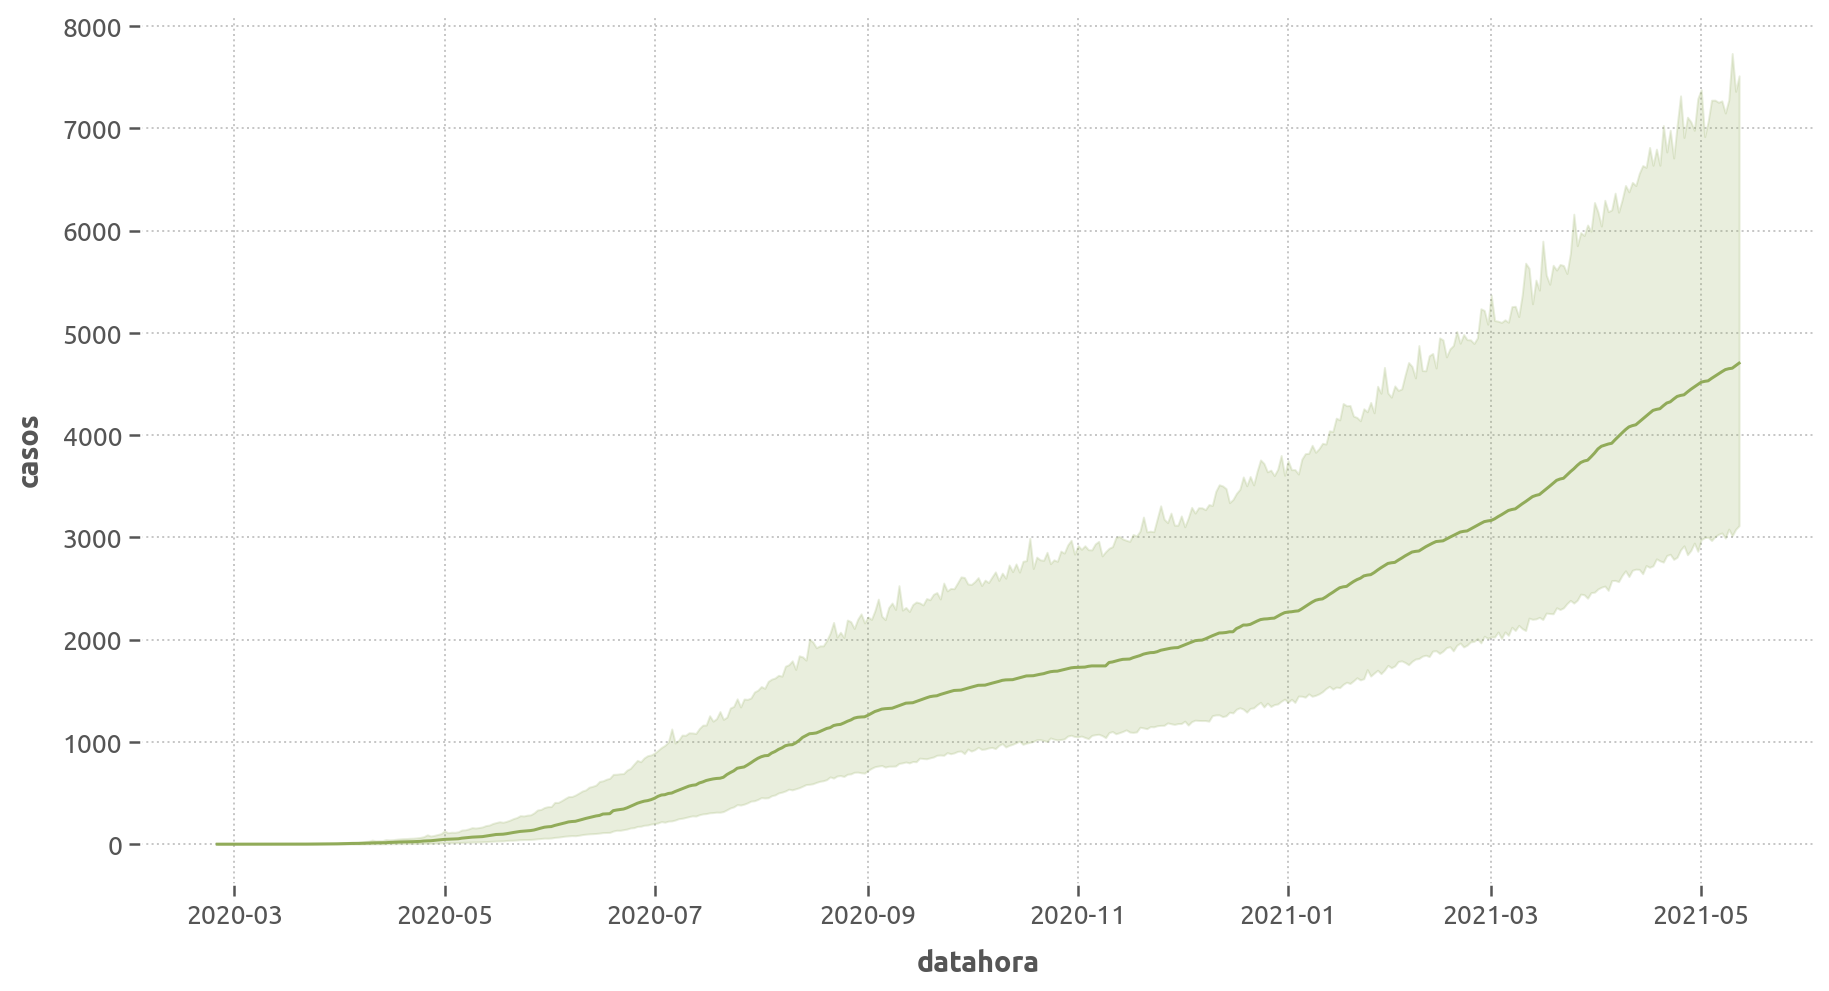

In [4]:
sns.lineplot(x='datahora', y='casos', data=dados)

Testando se é um crescimento exponencial: $e^x$

In [36]:
eixo_x = np.linspace(-2,2,100)
y_exp = np.exp(eixo_x)

Text(0.5, 0.98, "This is a big 'n' bold title")

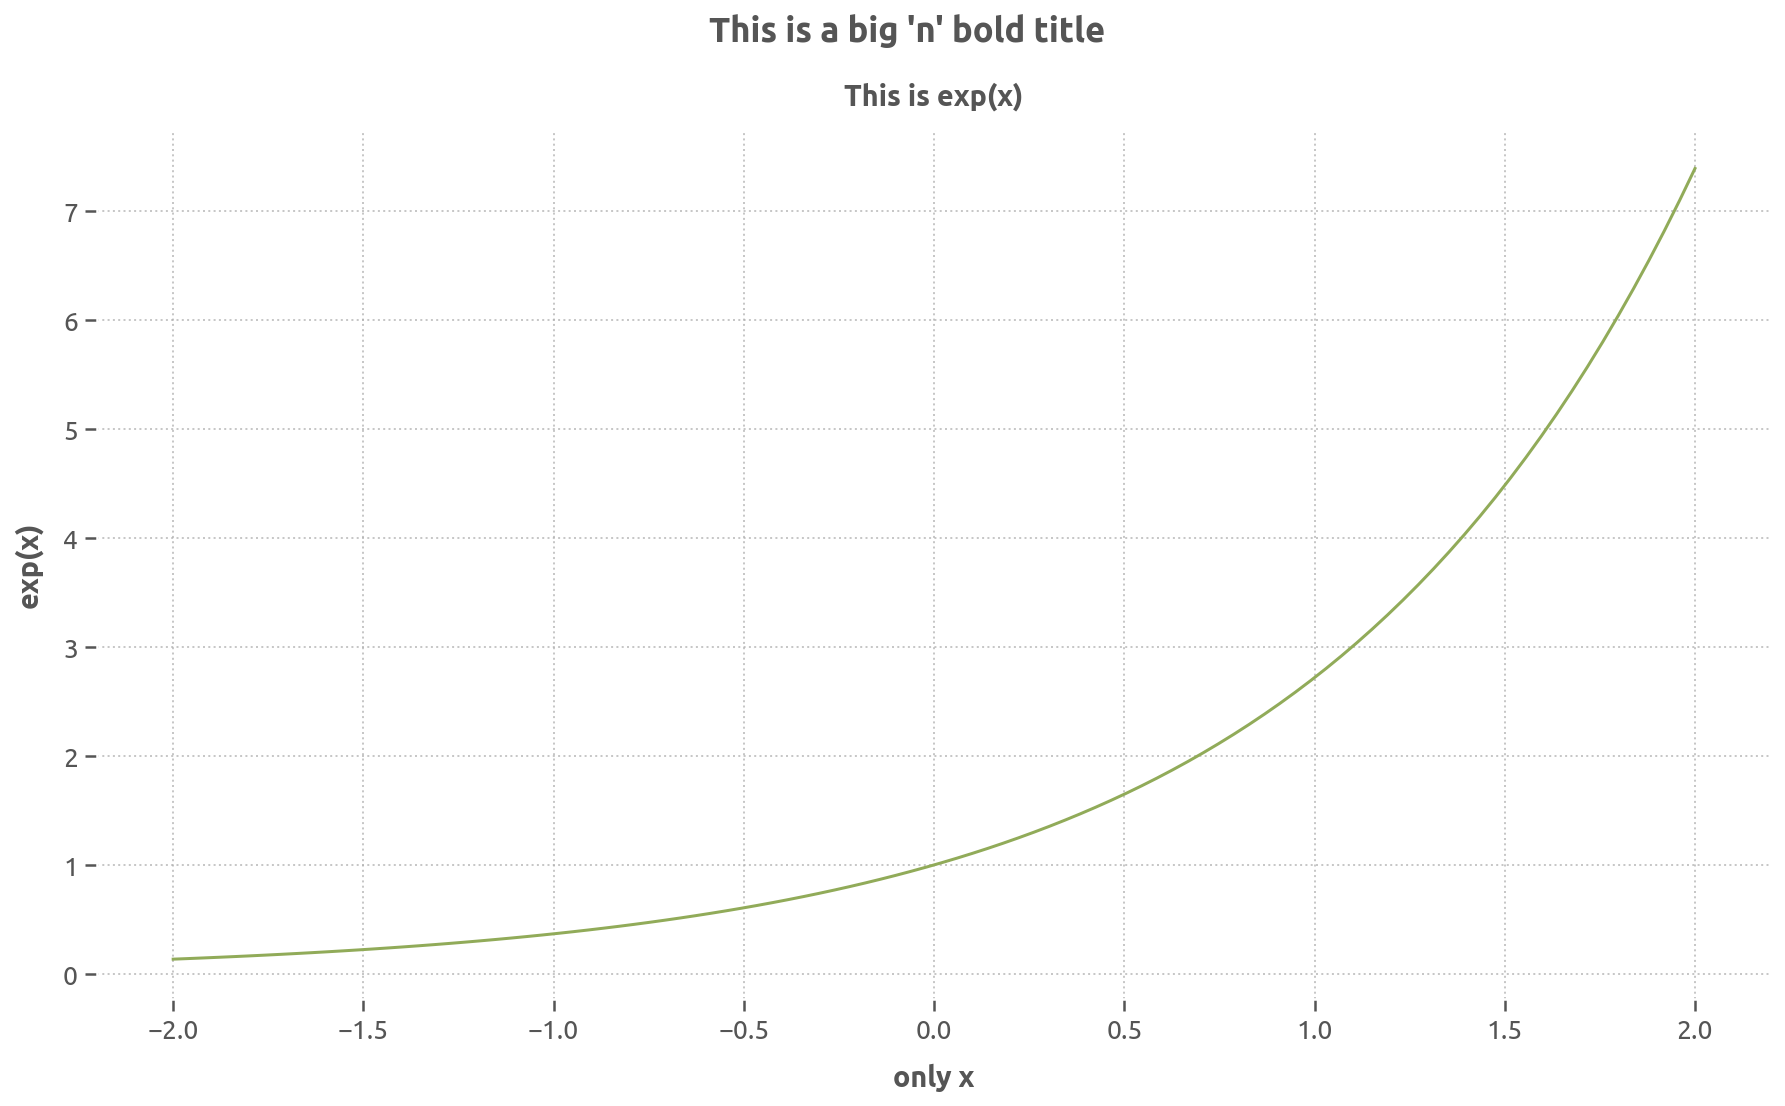

In [37]:
fig = mpl.pyplot.figure()
sns.lineplot(x=eixo_x, y=y_exp)\
   .set(title="This is exp(x)", xlabel= "only x", ylabel="exp(x)")
fig.suptitle("This is a big 'n' bold title")#, color='r')

Relembrando logaritmos

$$ log_2 2 = 1$$

$$ log_2 2^x = x$$

$$ log_e e^x = x$$

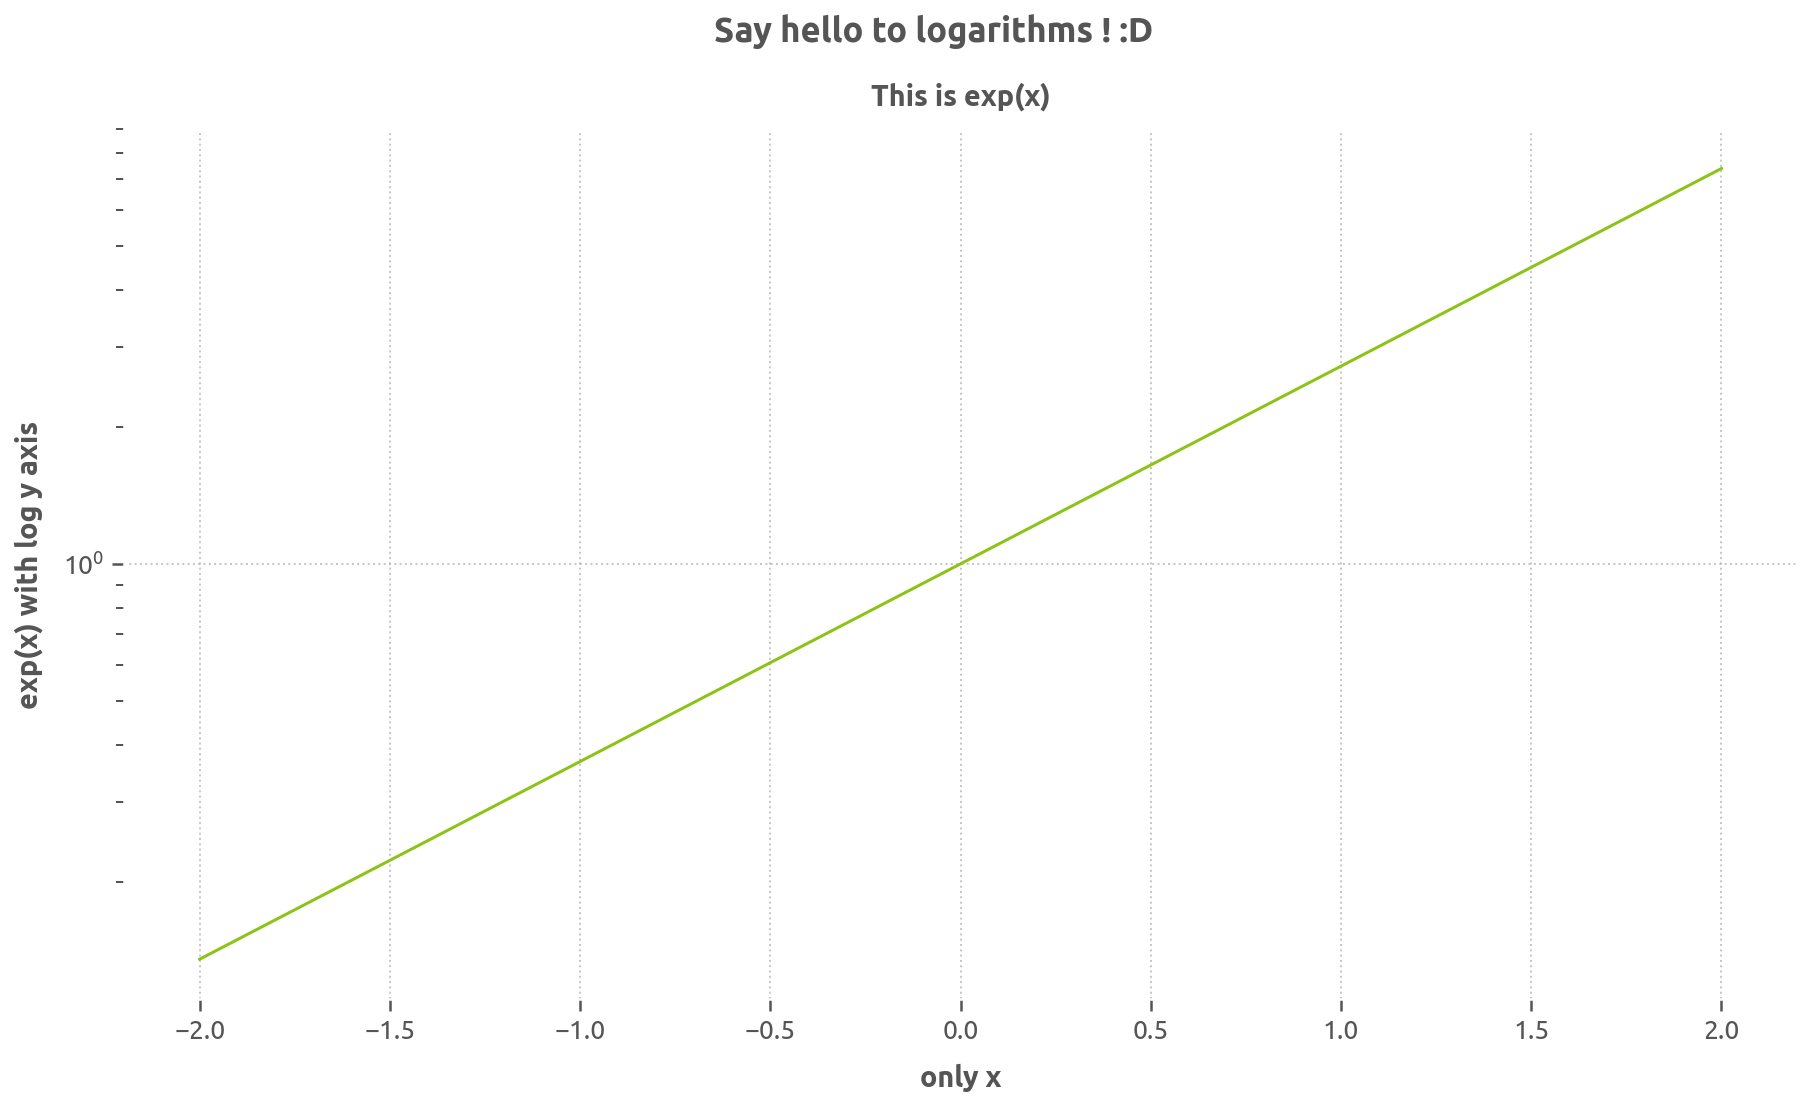

In [7]:
fig = mpl.pyplot.figure()
sns.lineplot(x=eixo_x, y=y_exp, color='#8bc317')\
   .set(title="This is exp(x)", xlabel= "only x", ylabel="exp(x) with log y axis")
fig.suptitle("Say hello to logarithms ! :D")

mpl.pyplot.yscale('log')

Portanto, se a evolução de casos for exponencial, aplicar um eixo logaritmo tarria uma reta. Vamos testar.

In [8]:
dados_sp = dados.query("nome_munic == 'São Paulo'")

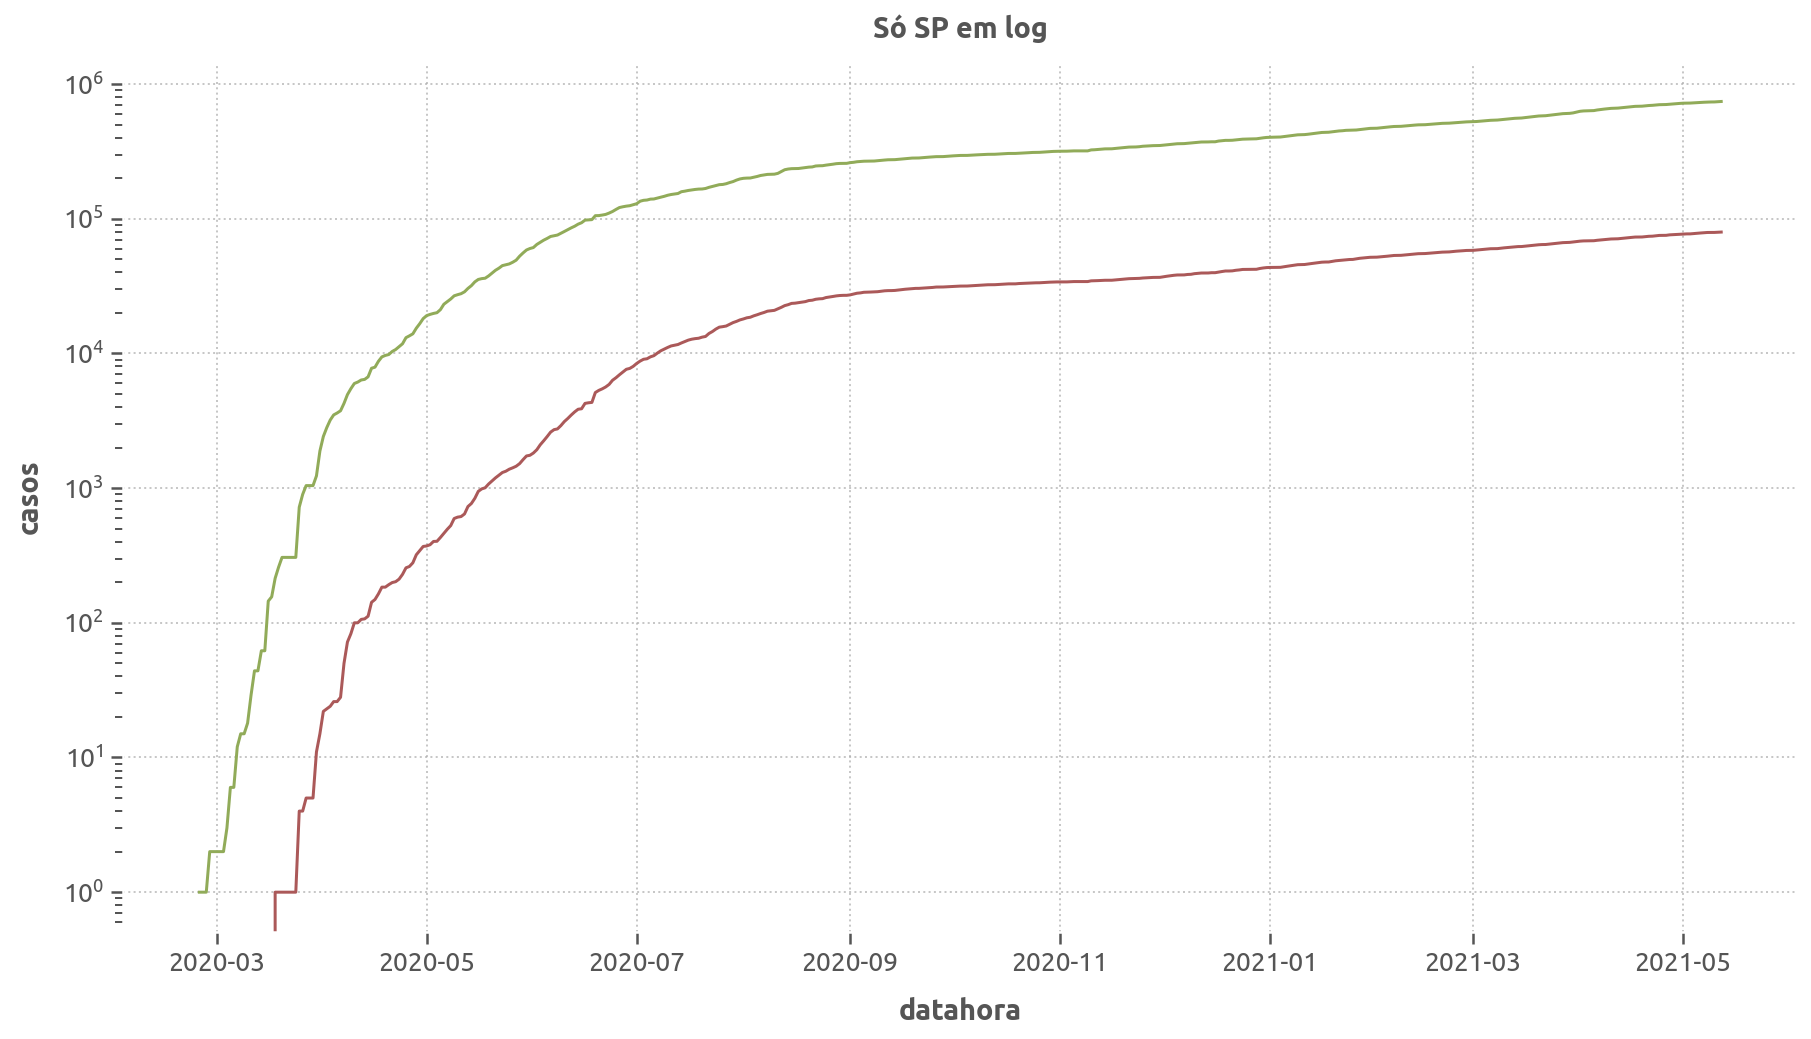

In [10]:
sns.lineplot(x='datahora', y='casos', data=dados_sp).set(title='SP x Campinas em log')
sns.lineplot(x='datahora', y='casos', data=dados.query("nome_munic == 'Campinas'")).set(title='Só SP em log')
mpl.pyplot.yscale('log')

<AxesSubplot:xlabel='datahora', ylabel='casos_novos'>

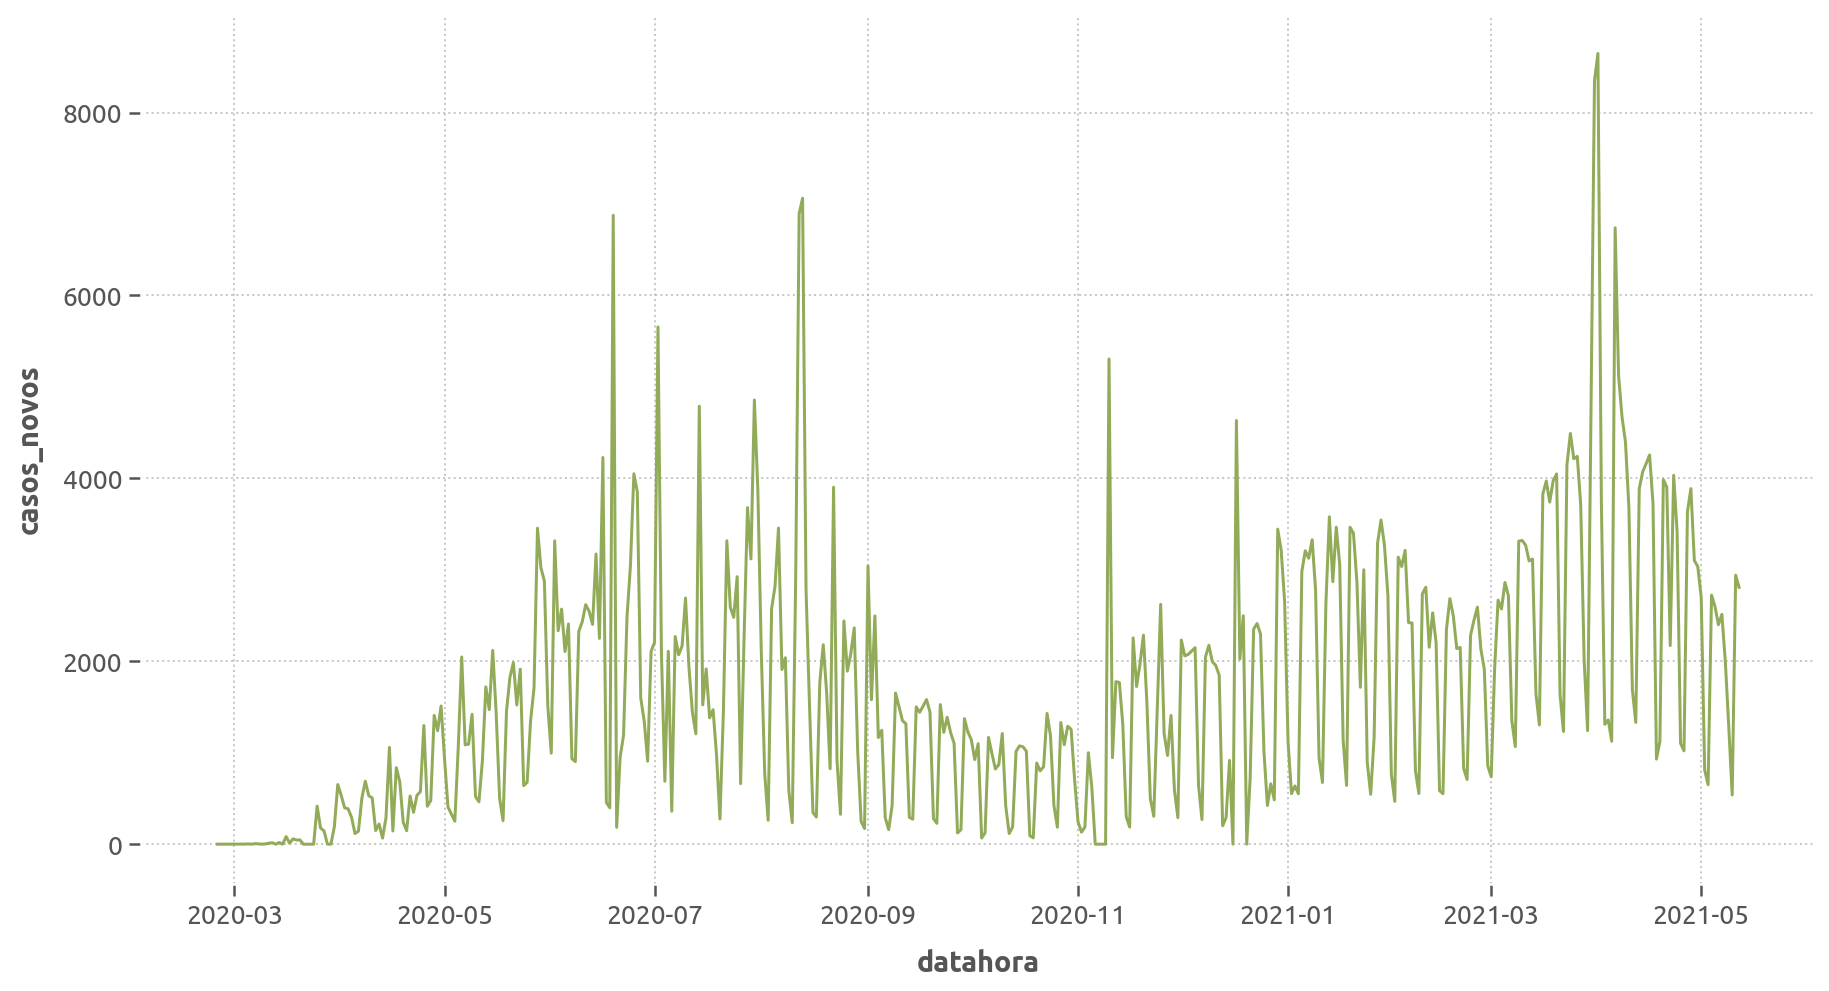

In [11]:
sns.lineplot(x='datahora', y='casos_novos', data=dados_sp)

<AxesSubplot:xlabel='0', ylabel='0'>

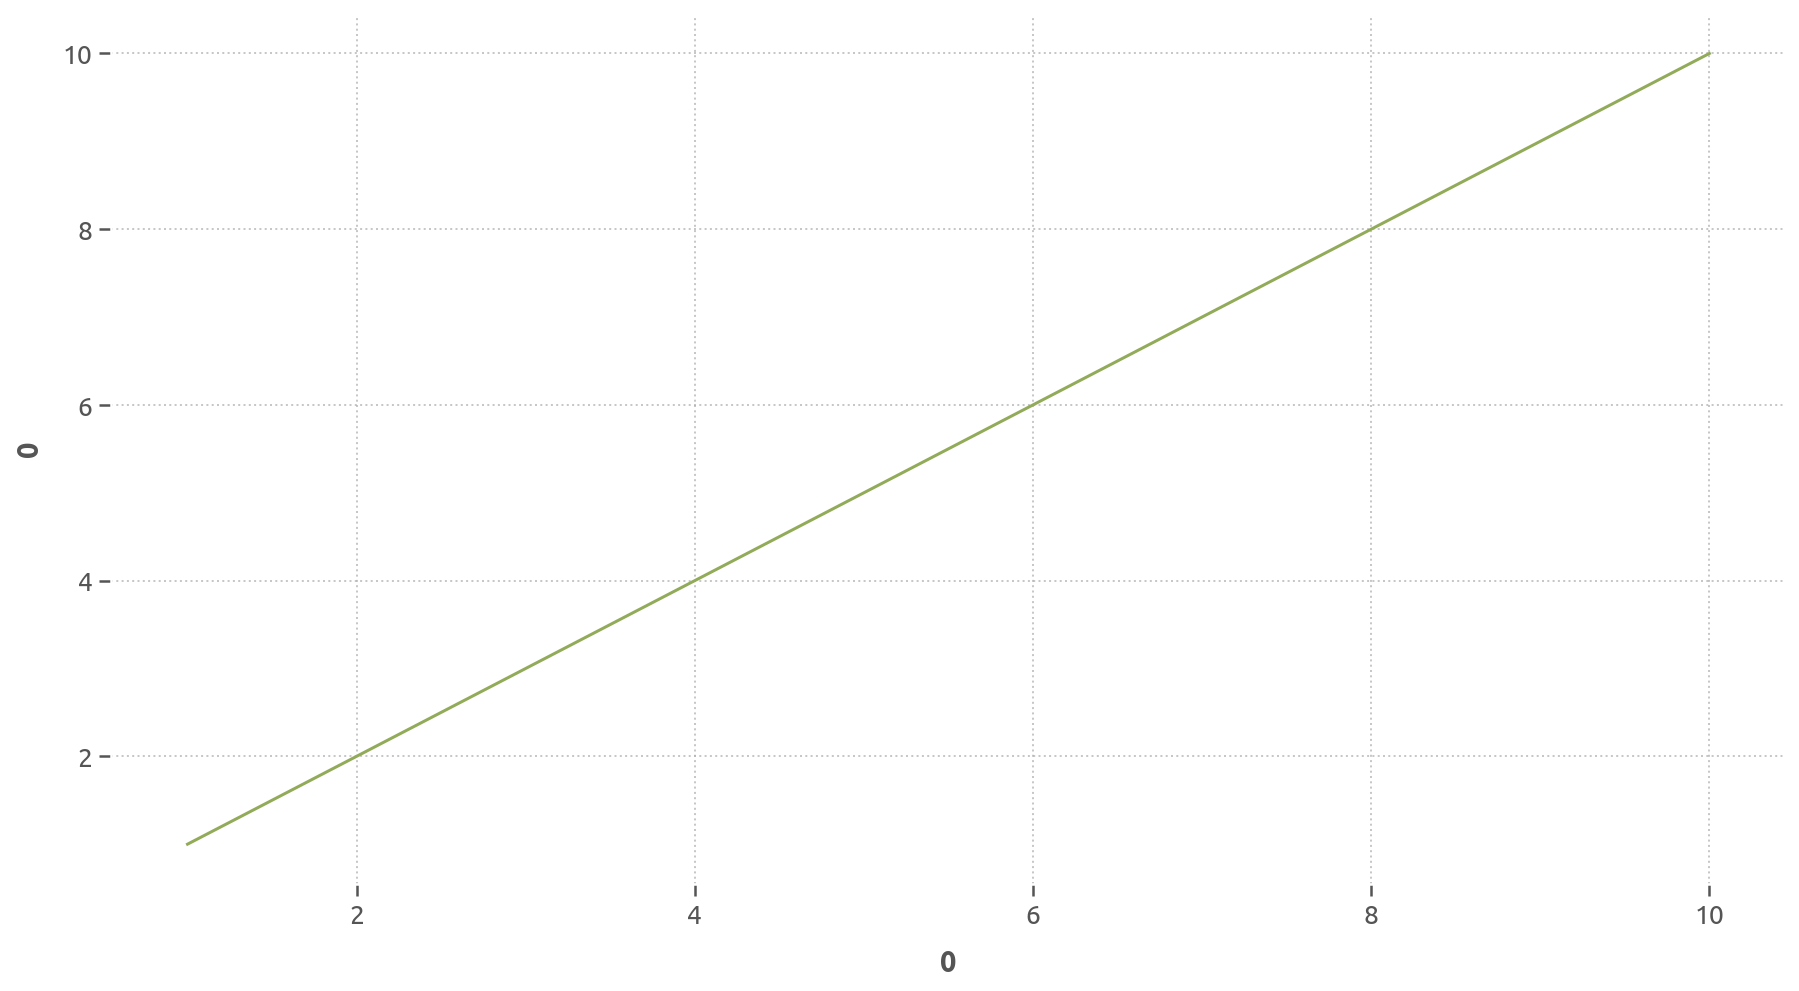

In [12]:
dados_exemplo = pd.DataFrame(data=np.linspace(1,10,10))
sns.lineplot(x=0, y=0, data=dados_exemplo)

In [7]:
dados_exemplo.diff()

0
0  NaN
1  1.0
2  1.0
3  1.0
4  1.0
5  1.0
6  1.0
7  1.0
8  1.0
9  1.0

In [13]:
dados_exemplo['diferenciado'] = dados_exemplo.diff()

<AxesSubplot:xlabel='0', ylabel='0'>

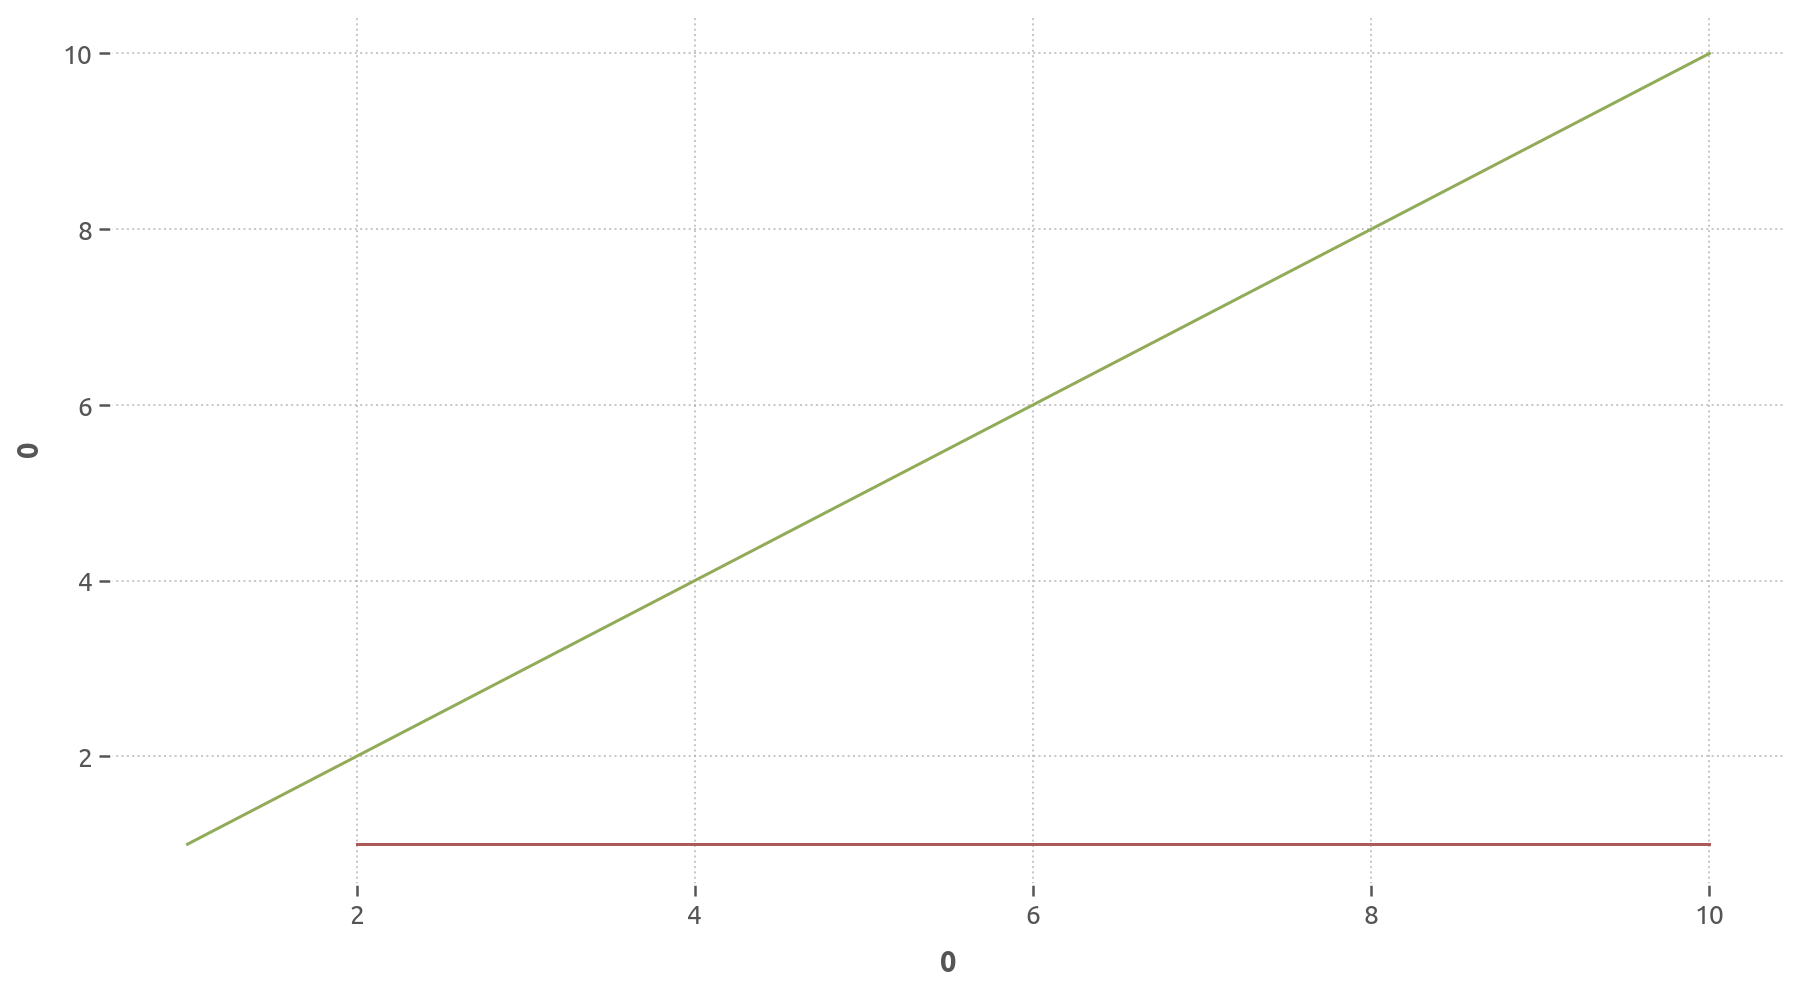

In [14]:
sns.lineplot(x=0, y=0, data=dados_exemplo)
sns.lineplot(x=0, y='diferenciado', data=dados_exemplo)

In [16]:
dados_sp['taxa_de_crescimento_casos'] = dados_sp['casos_novos'].diff()
dados_sp['taxa_de_crescimento_obitos'] = dados_sp['obitos_novos'].diff()

<ipython-input-16-070cdf40abd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sp['taxa_de_crescimento_casos'] = dados_sp['casos_novos'].diff()
<ipython-input-16-070cdf40abd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sp['taxa_de_crescimento_obitos'] = dados_sp['obitos_novos'].diff()


<AxesSubplot:xlabel='datahora', ylabel='taxa_de_crescimento_casos'>

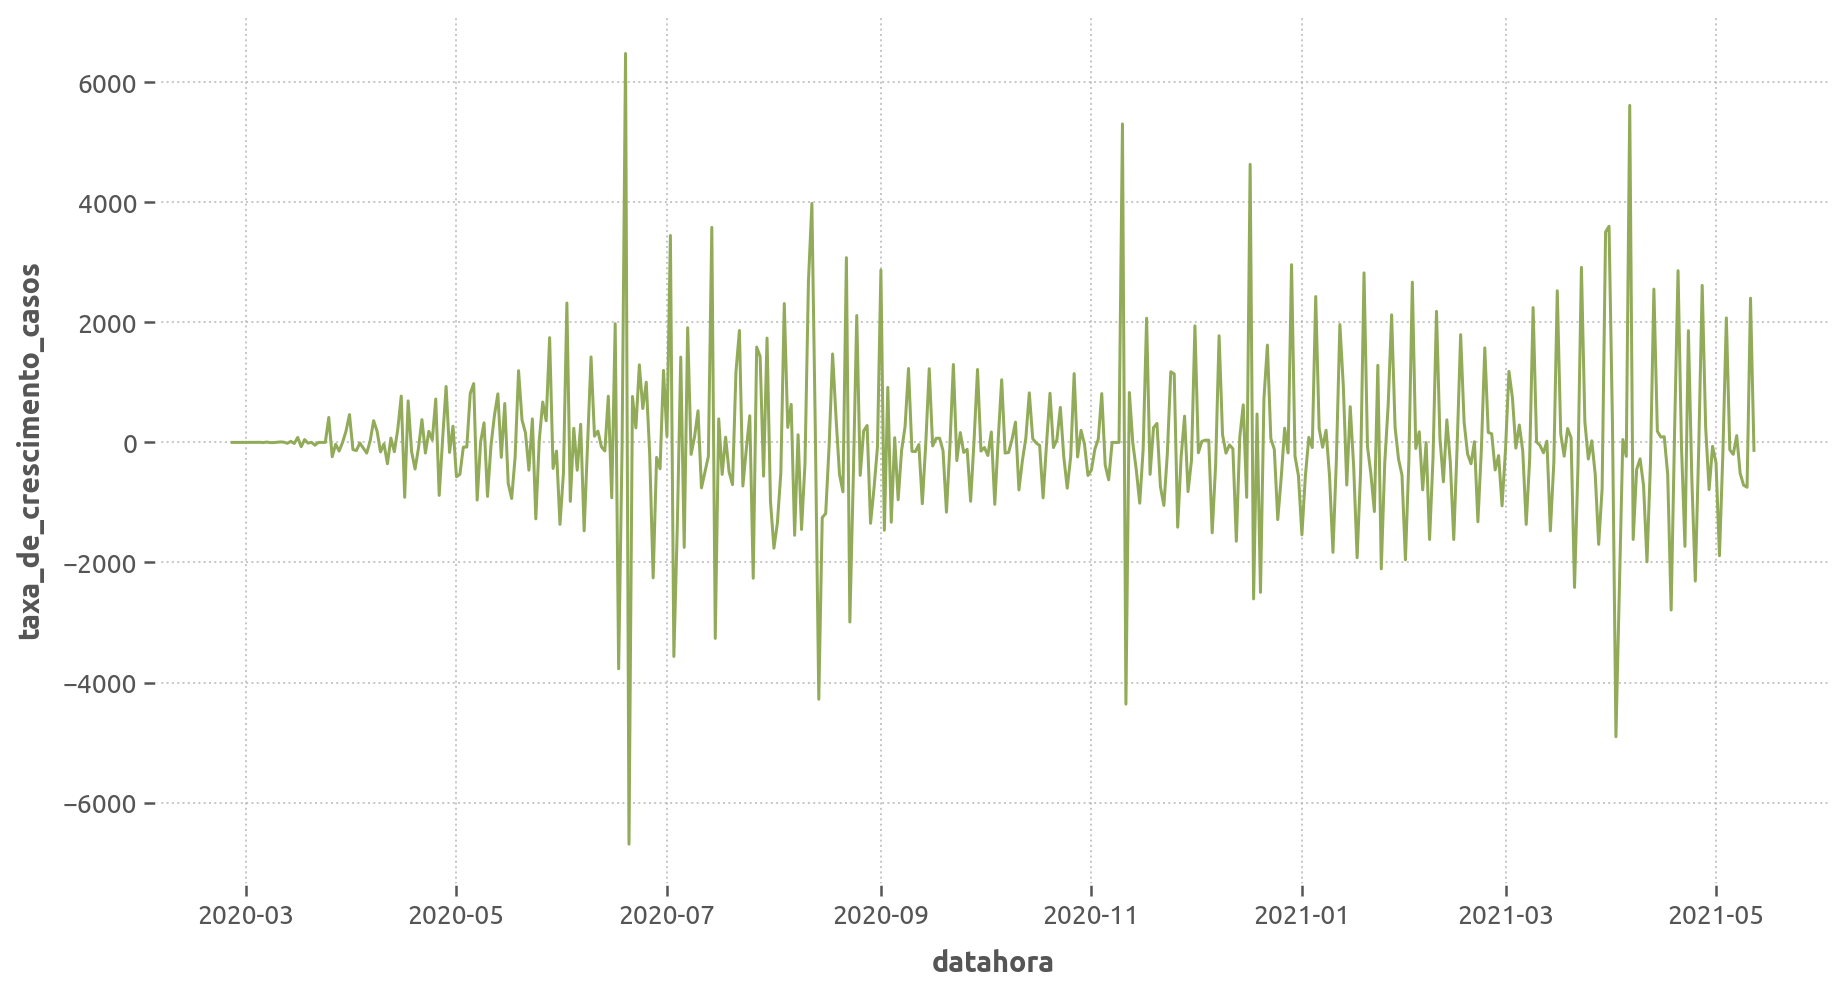

In [17]:
sns.lineplot(x='datahora', y='taxa_de_crescimento_casos', data=dados_sp)

<AxesSubplot:xlabel='datahora', ylabel='taxa_de_crescimento_obitos'>

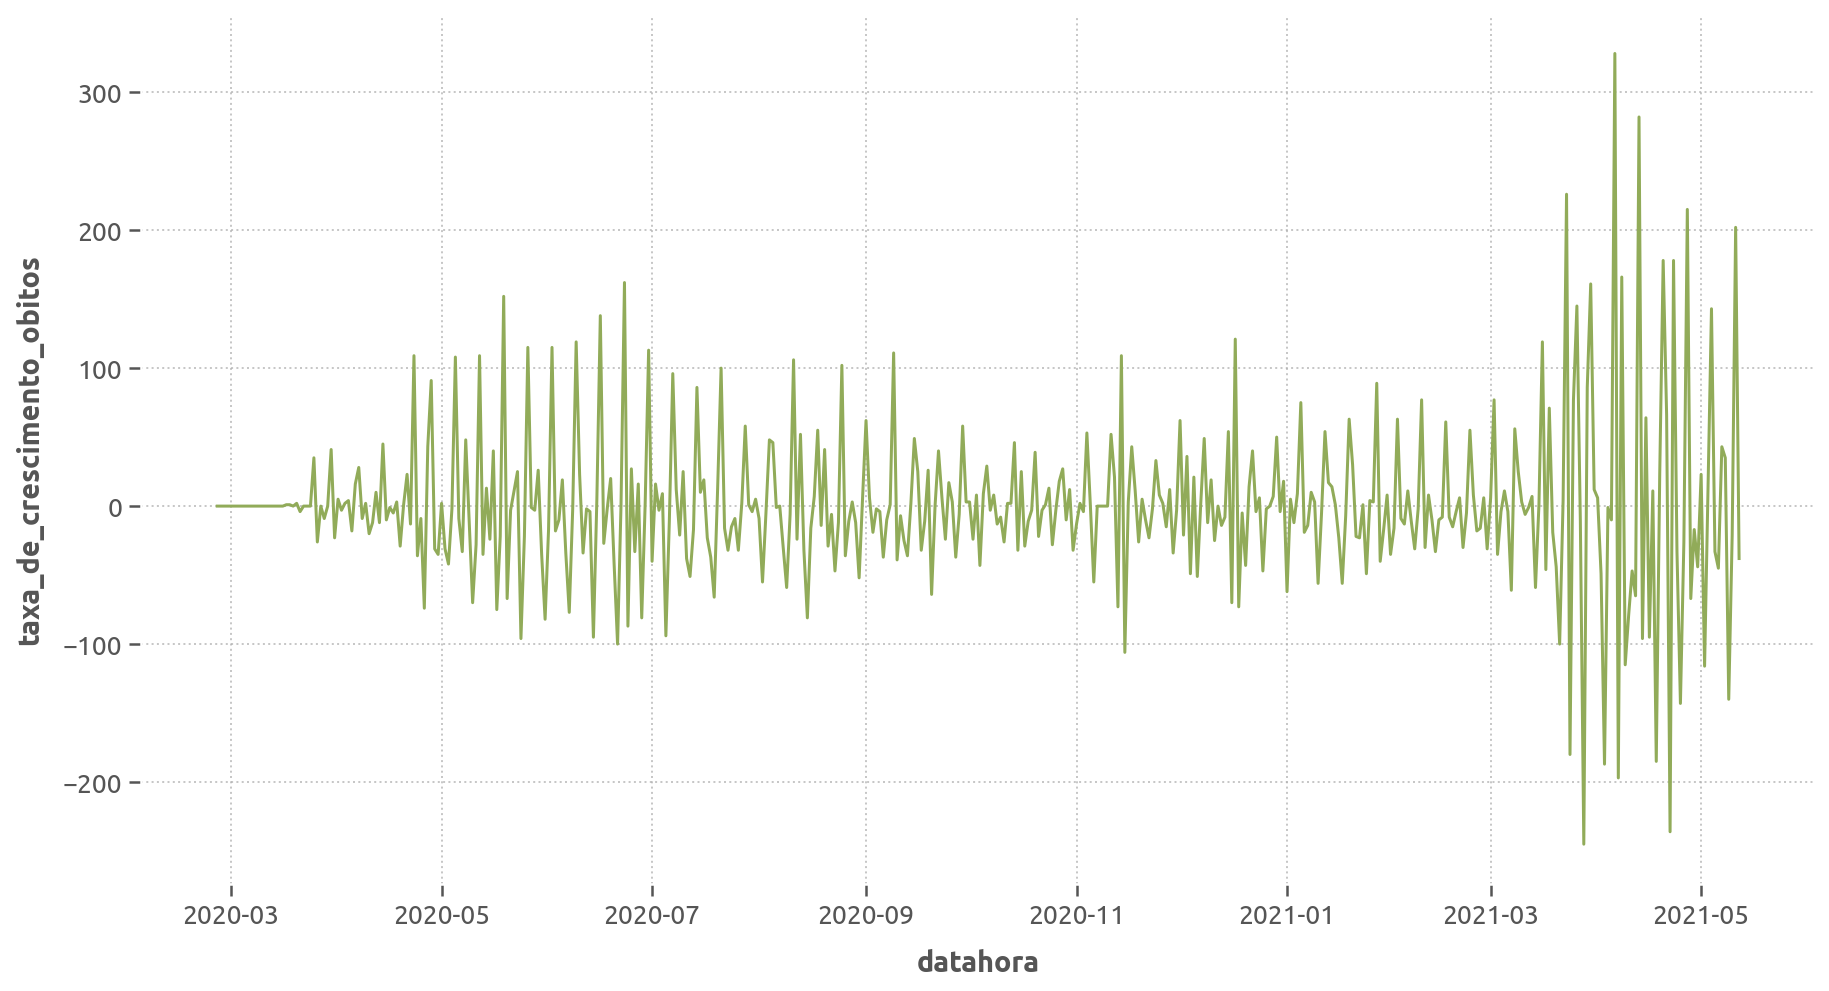

In [18]:
sns.lineplot(x='datahora', y='taxa_de_crescimento_obitos', data=dados_sp)

In [19]:
dados_sp.sort_values(by='taxa_de_crescimento_casos', ascending=False)

nome_munic  codigo_ibge  dia  mes   datahora   casos  casos_novos  \
74737   São Paulo      3550308   19    6 2020-06-19  105407         6877   
262432  São Paulo      3550308    6    4 2021-04-06  642322         6740   
167617  São Paulo      3550308   10   11 2020-11-10  324462         5306   
191482  São Paulo      3550308   17   12 2020-12-17  377507         4632   
109567  São Paulo      3550308   12    8 2020-08-12  224140         6896   
...           ...          ...  ...  ...        ...     ...          ...   
110857  São Paulo      3550308   14    8 2020-08-14  233987         2784   
168262  São Paulo      3550308   11   11 2020-11-11  325408          946   
259852  São Paulo      3550308    2    4 2021-04-02  631786         3743   
75382   São Paulo      3550308   20    6 2020-06-20  105591          184   
562     São Paulo      3550308   25    2 2020-02-25       1            0   

            casos_pc    casos_mm7d  obitos  ...       pop   pop_60    area  \
74737   8,880372e+02  2826,4285714    6255  ...  11869660  1853286  152111   
262432  5,411461e+03  4467,5714286   23222  ...  11869660  1853286  152111   
167617  2,733541e+03   989,8571429   13715  ...  11869660  1853286  152111   
191482  3,180437e+03  1405,8571429   15175  ...  11869660  1853286  152111   
109567  1,888344e+03  2576,8571429   10311  ...  11869660  1853286  152111   
...              ...           ...     ...  ...       ...      ...     ...   
110857  1,971303e+03  3216,8571429   10563  ...  11869660  1853286  152111   
168262  2,741511e+03   982,1428571   13767  ...  11869660  1853286  152111   
259852  5,322697e+03  4635,1428571   22673  ...  11869660  1853286  152111   
75382   8,895874e+02  2509,4285714    6371  ...  11869660  1853286  152111   
562     8,424841e-03     0,0000000       0  ...  11869660  1853286  152111   

       map_leg map_leg_s  latitude longitude  semana_epidem  \
74737    >5000       1.0  -23,5329  -46,6395             25   
262432   >5000       1.0  -23,5329  -46,6395             14   
167617   >5000       1.0  -23,5329  -46,6395             46   
191482   >5000       1.0  -23,5329  -46,6395             51   
109567   >5000       1.0  -23,5329  -46,6395             33   
...        ...       ...       ...       ...            ...   
110857   >5000       1.0  -23,5329  -46,6395             33   
168262   >5000       1.0  -23,5329  -46,6395             46   
259852   >5000       1.0  -23,5329  -46,6395             13   
75382    >5000       1.0  -23,5329  -46,6395             25   
562        <50       7.0  -23,5329  -46,6395              9   

        taxa_de_crescimento_casos  taxa_de_crescimento_obitos  
74737                      6479.0                        20.0  
262432                     5614.0                       328.0  
167617                     5306.0                         0.0  
191482                     4632.0                       121.0  
109567                     3981.0                       -24.0  
...                           ...                         ...  
110857                    -4279.0                       -32.0  
168262                    -4360.0                        52.0  
259852                    -4903.0                       -49.0  
75382                     -6693.0                       -42.0  
562                           NaN                         NaN  

[443 rows x 28 columns]

<BarContainer object of 443 artists>

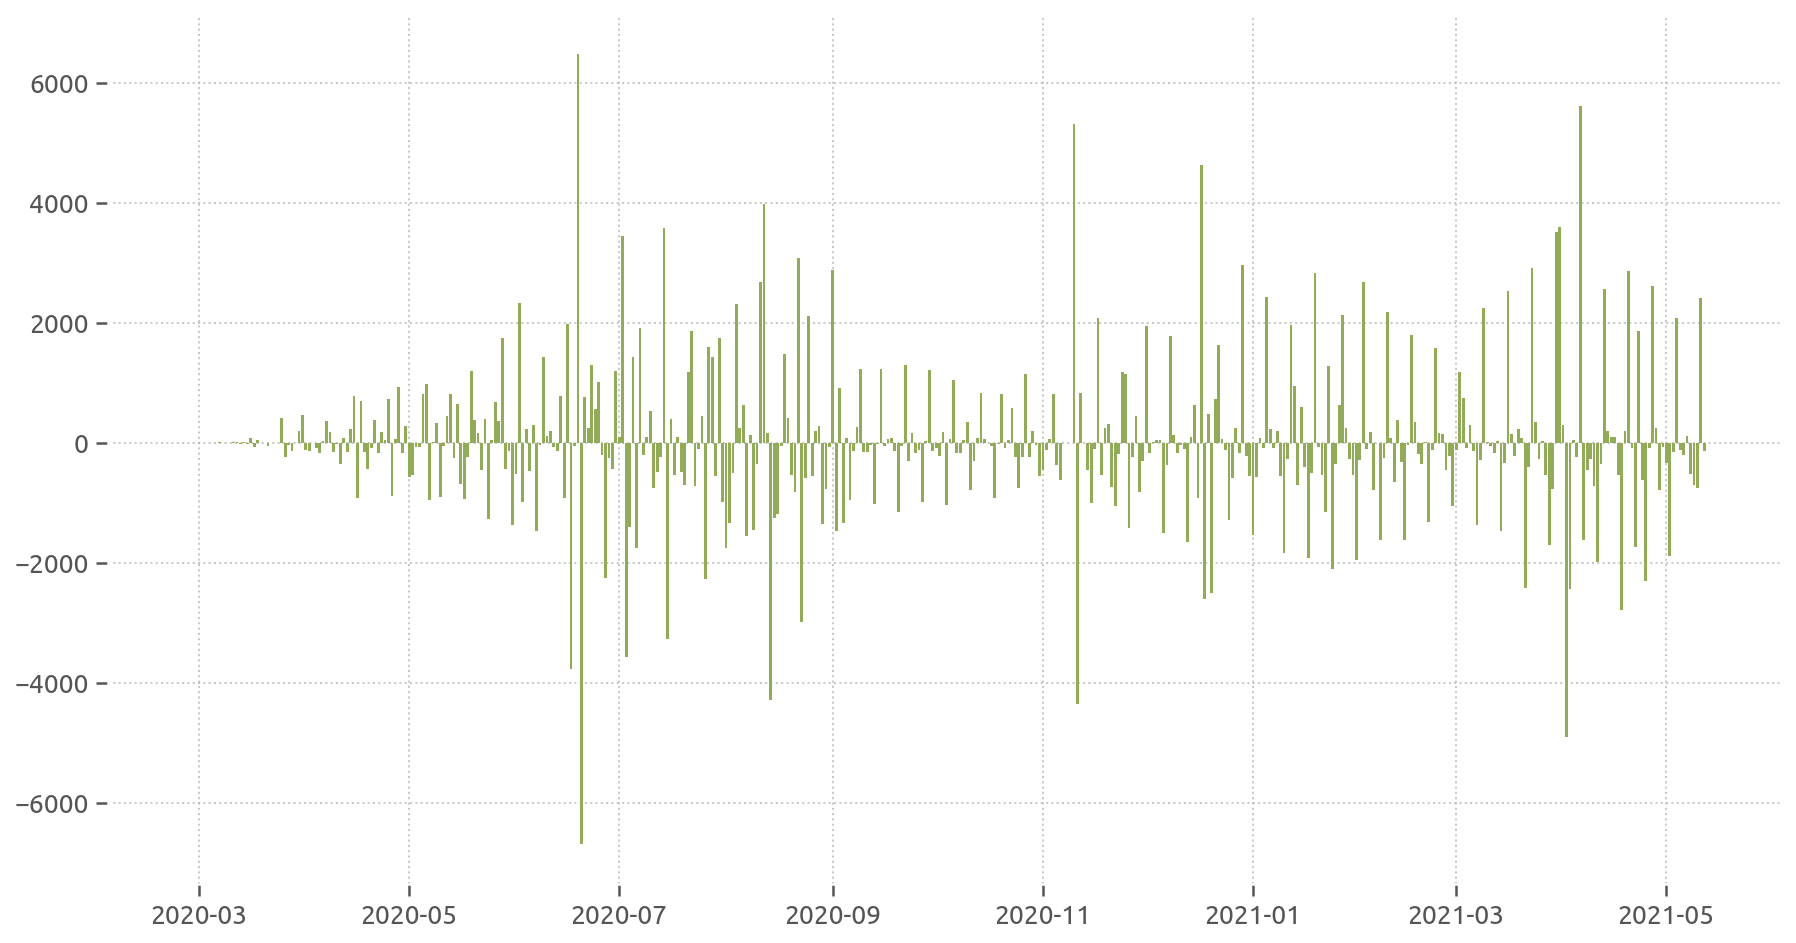

In [19]:
plt.bar(dados_sp['datahora'], dados_sp['taxa_de_crescimento_casos'])

In [20]:
dados_sp['ano'] = pd.DatetimeIndex(dados_sp['datahora']).year

<ipython-input-20-a1141020db7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sp['ano'] = pd.DatetimeIndex(dados_sp['datahora']).year


In [21]:
dados

nome_munic  codigo_ibge  dia  mes   datahora  casos  \
0             Adamantina      3500105   25    2 2020-02-25      0   
1                 Adolfo      3500204   25    2 2020-02-25      0   
2                  Aguaí      3500303   25    2 2020-02-25      0   
3         Águas da Prata      3500402   25    2 2020-02-25      0   
4       Águas de Lindóia      3500501   25    2 2020-02-25      0   
...                  ...          ...  ...  ...        ...    ...   
286173          Ignorado      9999999    8    5 2021-05-08    820   
286174          Ignorado      9999999    9    5 2021-05-09    756   
286175          Ignorado      9999999   10    5 2021-05-10    703   
286176          Ignorado      9999999   11    5 2021-05-11    744   
286177          Ignorado      9999999   12    5 2021-05-12    709   

        casos_novos      casos_pc    casos_mm7d  obitos  ...  \
0                 0  0,000000e+00     0,0000000       0  ...   
1                 0  0,000000e+00     0,0000000       0  ...   
2                 0  0,000000e+00     0,0000000       0  ...   
3                 0  0,000000e+00     0,0000000       0  ...   
4                 0  0,000000e+00     0,0000000       0  ...   
...             ...           ...           ...     ...  ...   
286173          116  0,000000e+00    10,0000000       5  ...   
286174          -64  0,000000e+00     7,8571429      16  ...   
286175          -53  0,000000e+00     3,8571429       9  ...   
286176           41  0,000000e+00     4,4285714       3  ...   
286177          -35  0,000000e+00    -4,1428571       0  ...   

                     nome_drs cod_drs    pop pop_60   area  map_leg map_leg_s  \
0                     Marília       5  33894   7398  41199        0       8.0   
1       São José do Rio Preto      15   3447    761  21106        0       8.0   
2       São João da Boa Vista      14  35608   5245  47455        0       8.0   
3       São João da Boa Vista      14   7797   1729  14267        0       8.0   
4                    Campinas       3  18374   3275   6013        0       8.0   
...                       ...     ...    ...    ...    ...      ...       ...   
286173                    NaN       0      0      0      0      NaN       NaN   
286174                    NaN       0      0      0      0      NaN       NaN   
286175                    NaN       0      0      0      0      NaN       NaN   
286176                    NaN       0      0      0      0      NaN       NaN   
286177                    NaN       0      0      0      0      NaN       NaN   

        latitude  longitude  semana_epidem  
0       -21,6820   -51,0737              9  
1       -21,2325   -49,6451              9  
2       -22,0572   -46,9735              9  
3       -21,9319   -46,7176              9  
4       -22,4733   -46,6314              9  
...          ...        ...            ...  
286173    0,0000     0,0000             18  
286174    0,0000     0,0000             19  
286175    0,0000     0,0000             19  
286176    0,0000     0,0000             19  
286177    0,0000     0,0000             19  

[286178 rows x 26 columns]

<BarContainer object of 132 artists>

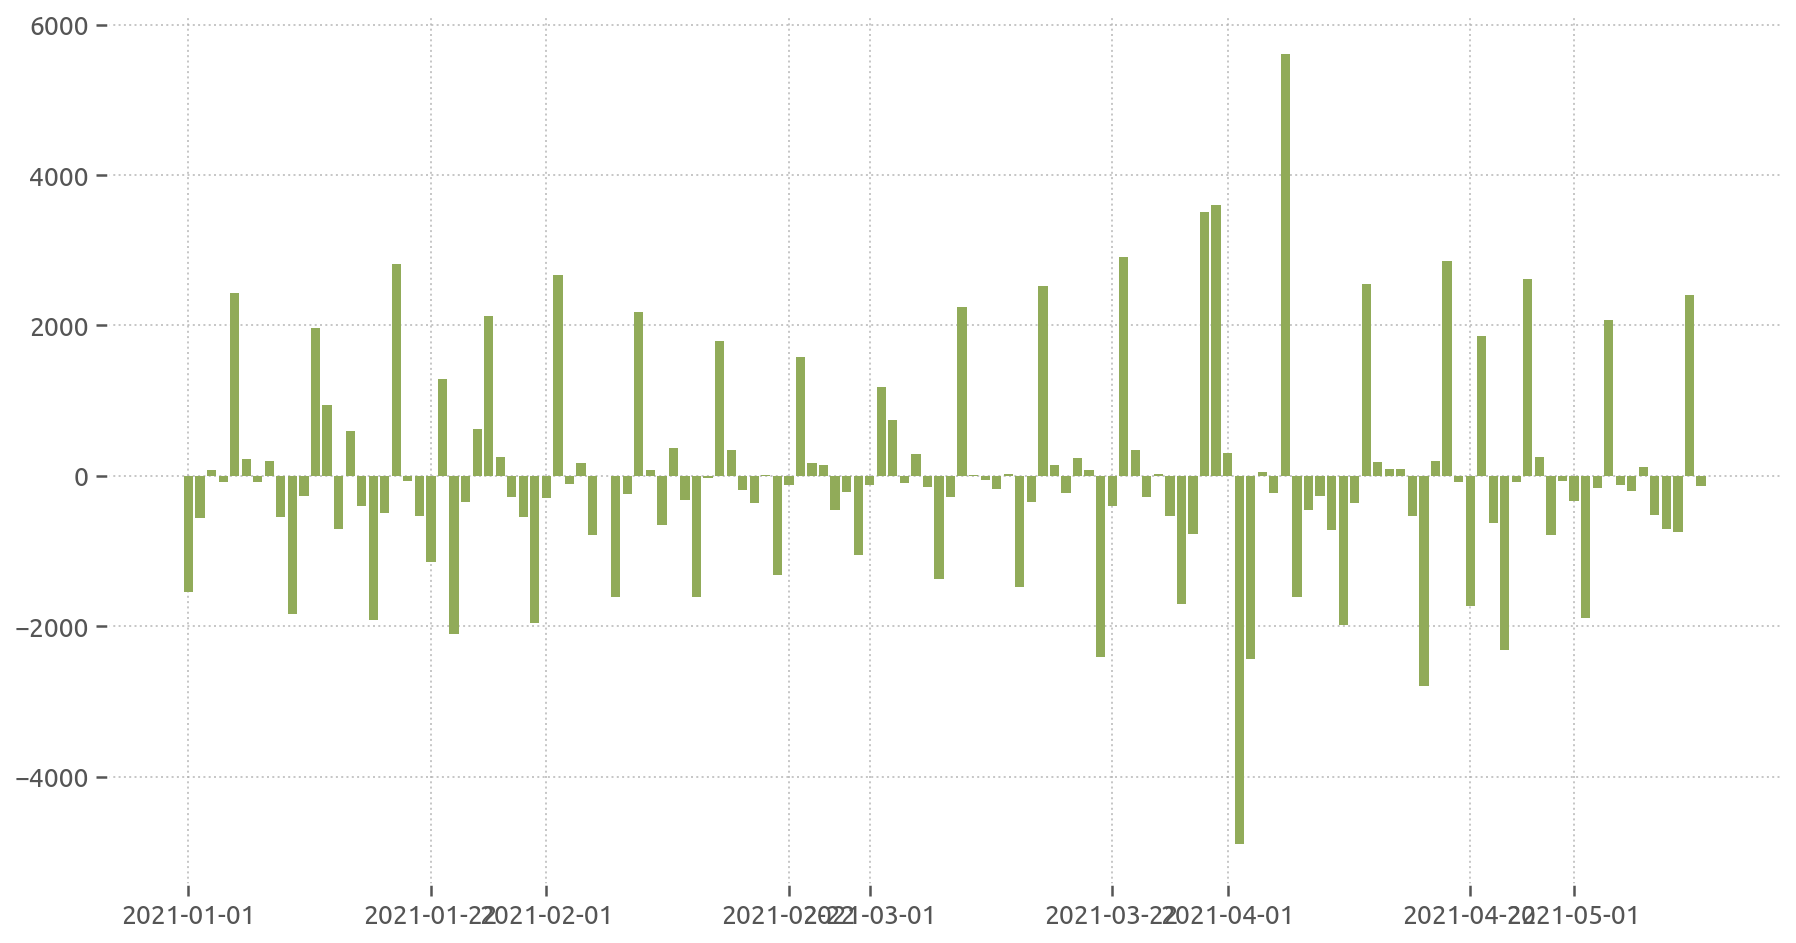

In [22]:
plt.bar(dados_sp.query('ano==2021')['datahora'], dados_sp.query('ano==2021')['taxa_de_crescimento_casos'])

Criando coluna com média móvel

In [ ]:
dados_sp['media_movel_casos'] = dados_sp['casos_novos'].rolling(window=7, center=False).mean()
dados_sp['media_movel_obitos'] = dados_sp['obitos_novos'].rolling(window=7, center=False).mean()

Text(0.5, 0.98, 'Casos Novos e Média Móvel em São Paulo')

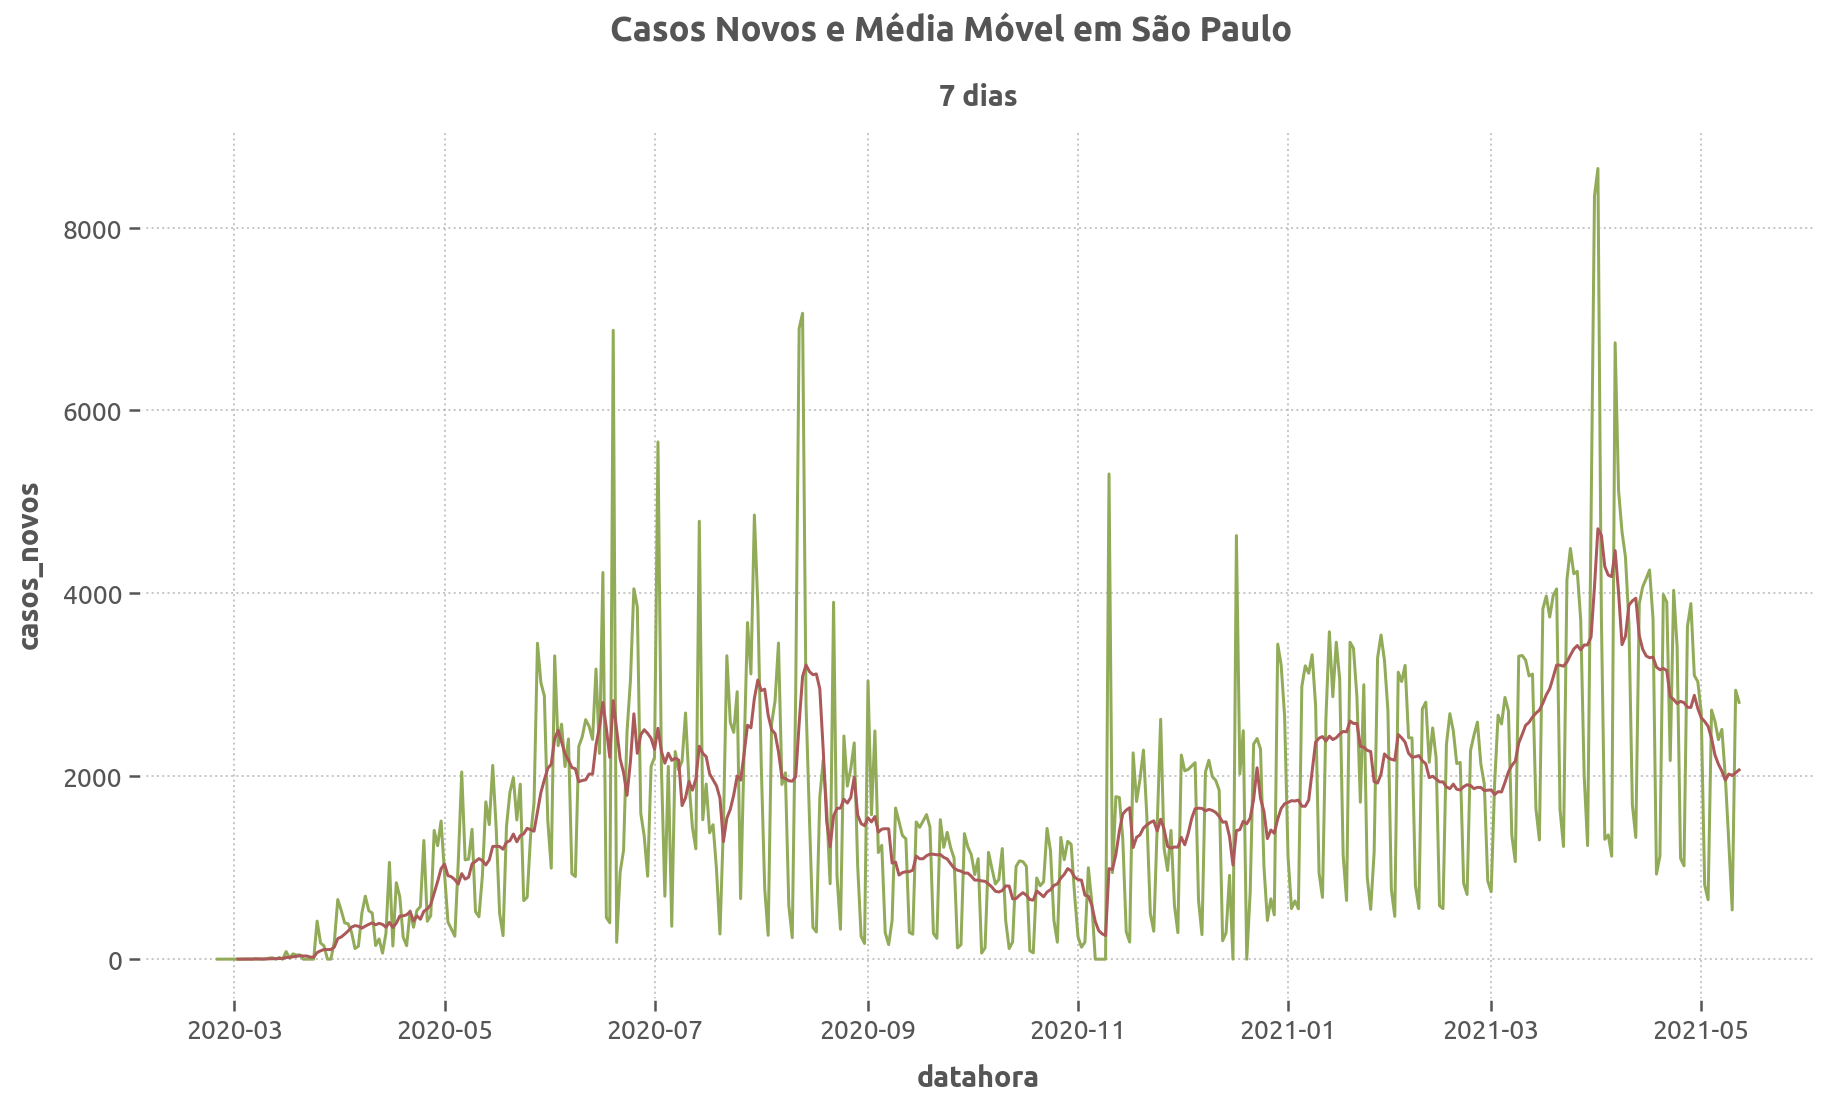

In [32]:
fig = plt.figure()
sns.lineplot(x='datahora', y='casos_novos', data=dados_sp)
sns.lineplot(x='datahora', y='media_movel_casos', data=dados_sp).set(title='7 dias')
fig.suptitle('Casos Novos e Média Móvel em São Paulo')

Verificando correlações

[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Novos Óbitos'),
 Text(0.5, 1.0, 'Correlação entre casos e óbitos em São Paulo')]

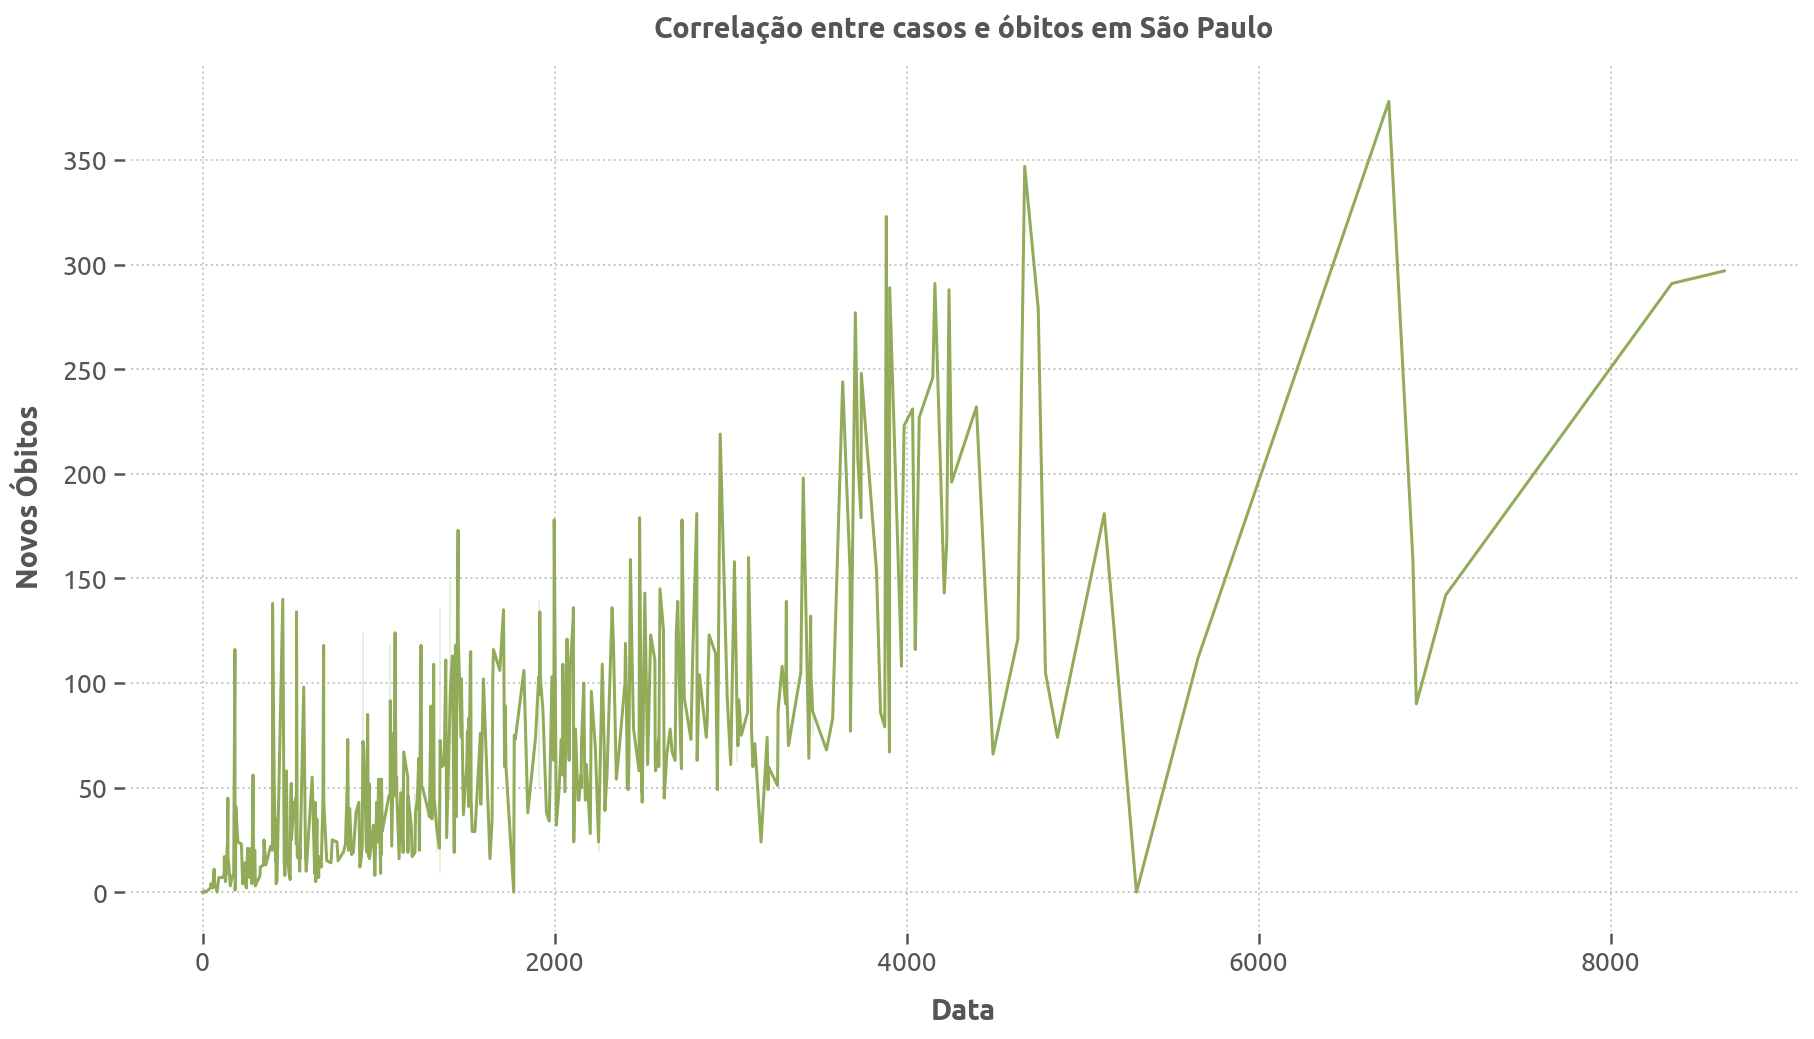

In [25]:
sns.lineplot(x='casos_novos', y='obitos_novos', data=dados_sp)\
   .set(xlabel= 'Data', ylabel='Novos Óbitos', title='Correlação entre casos e óbitos em São Paulo')

[Text(0.5, 0, 'Data'),
 Text(0, 0.5, 'Novos Óbitos'),
 Text(0.5, 1.0, 'Correlação entre casos e óbitos em São Paulo')]

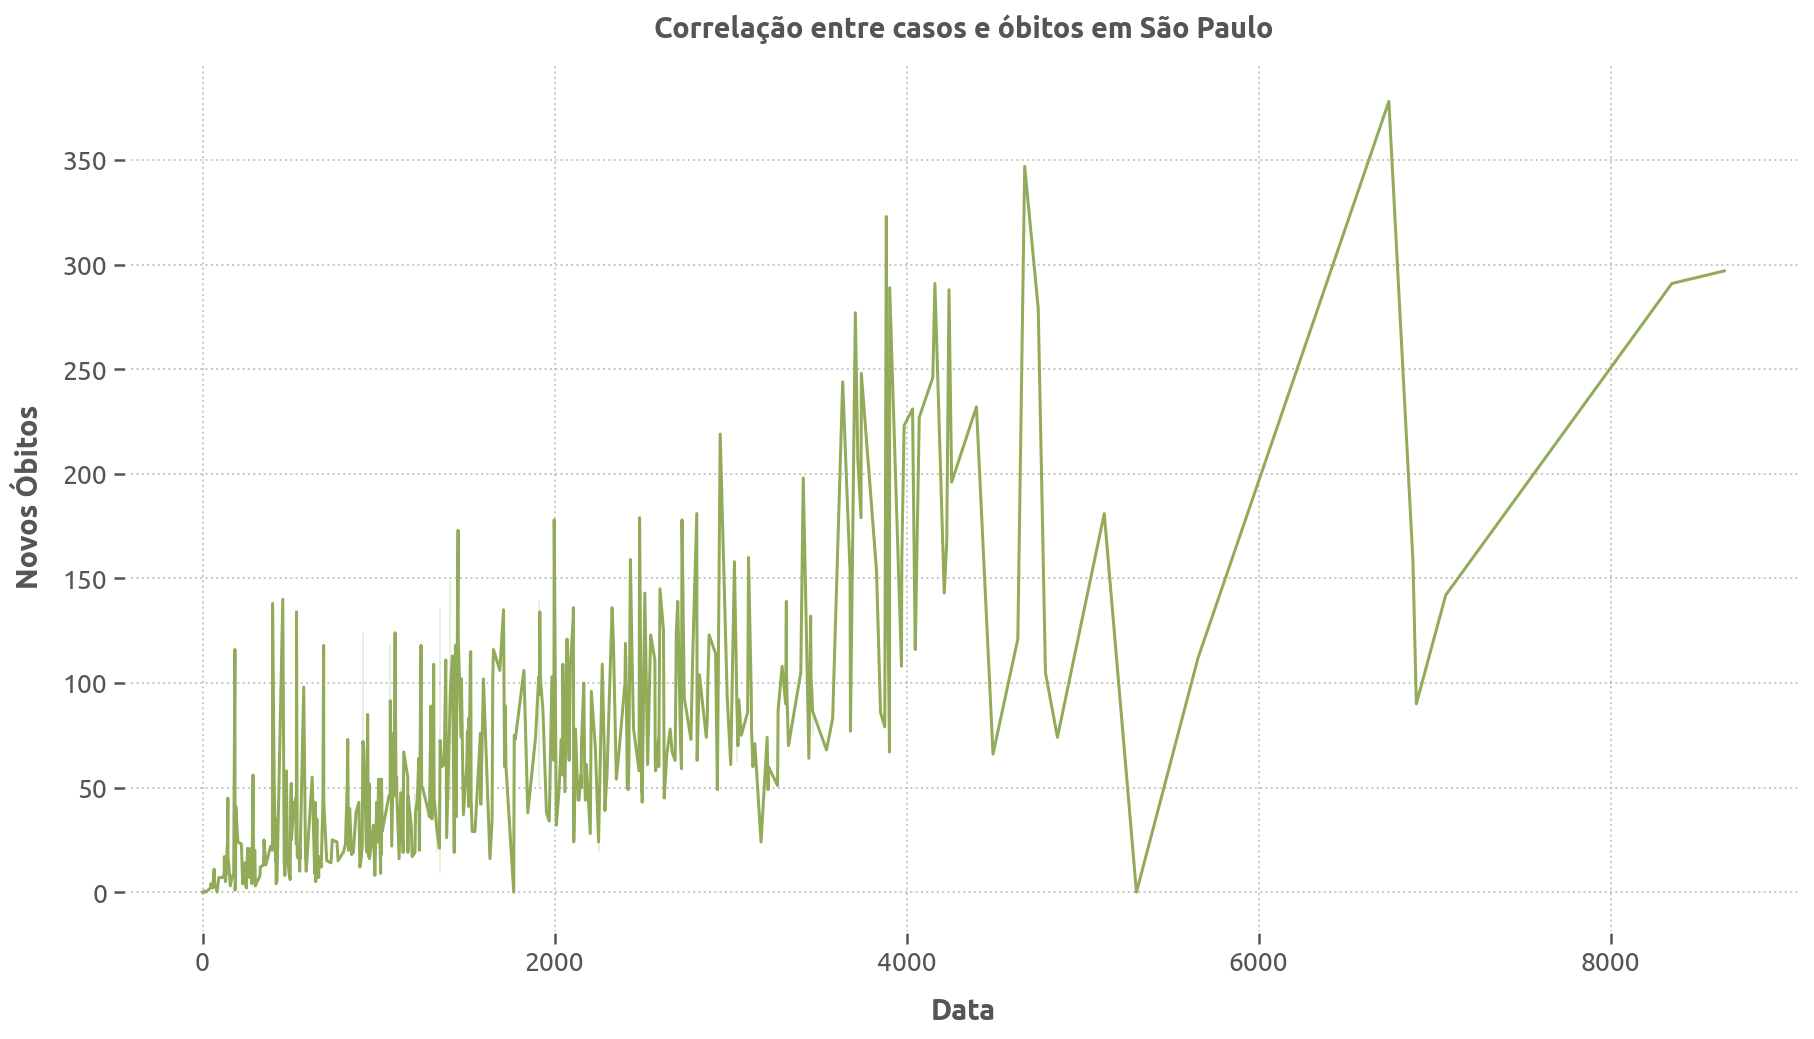

In [26]:
sns.lineplot(x='casos_novos', y='obitos_novos', data=dados_sp)\
   .set(xlabel= 'Data', ylabel='Novos Óbitos', title='Correlação entre casos e óbitos em São Paulo')

In [27]:
dados_202101 = dados_sp.query('mes==1 & ano==2021')
dados_202102 = dados_sp.query('mes==2 & ano==2021')

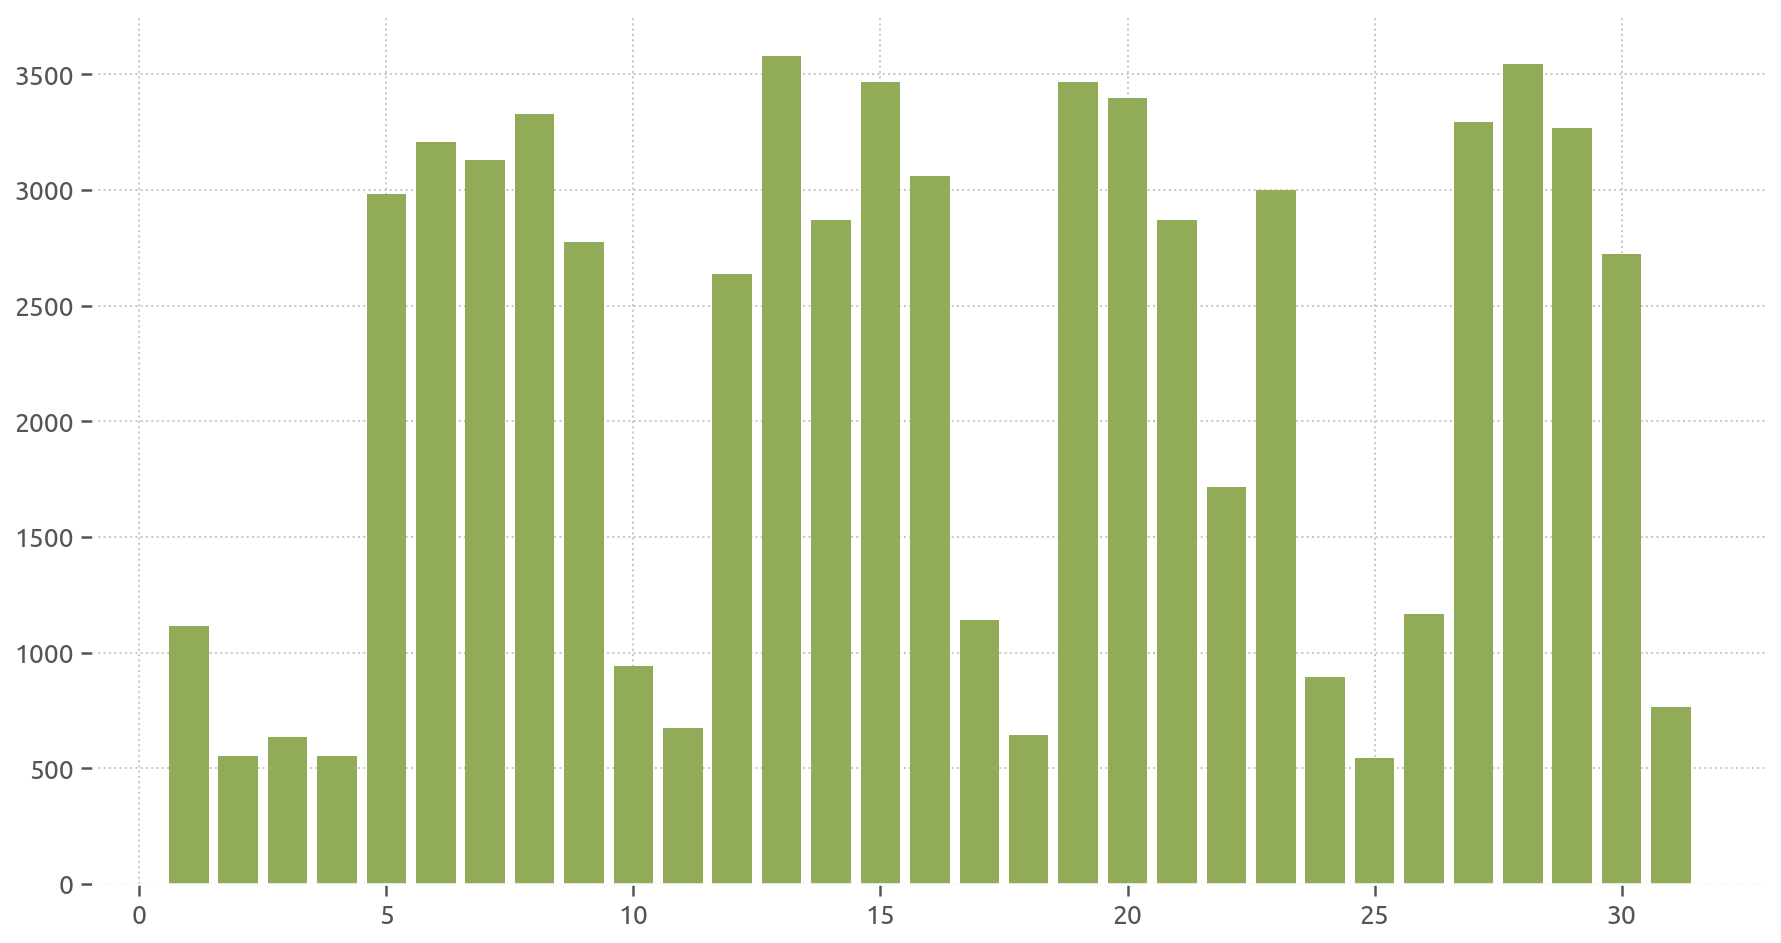

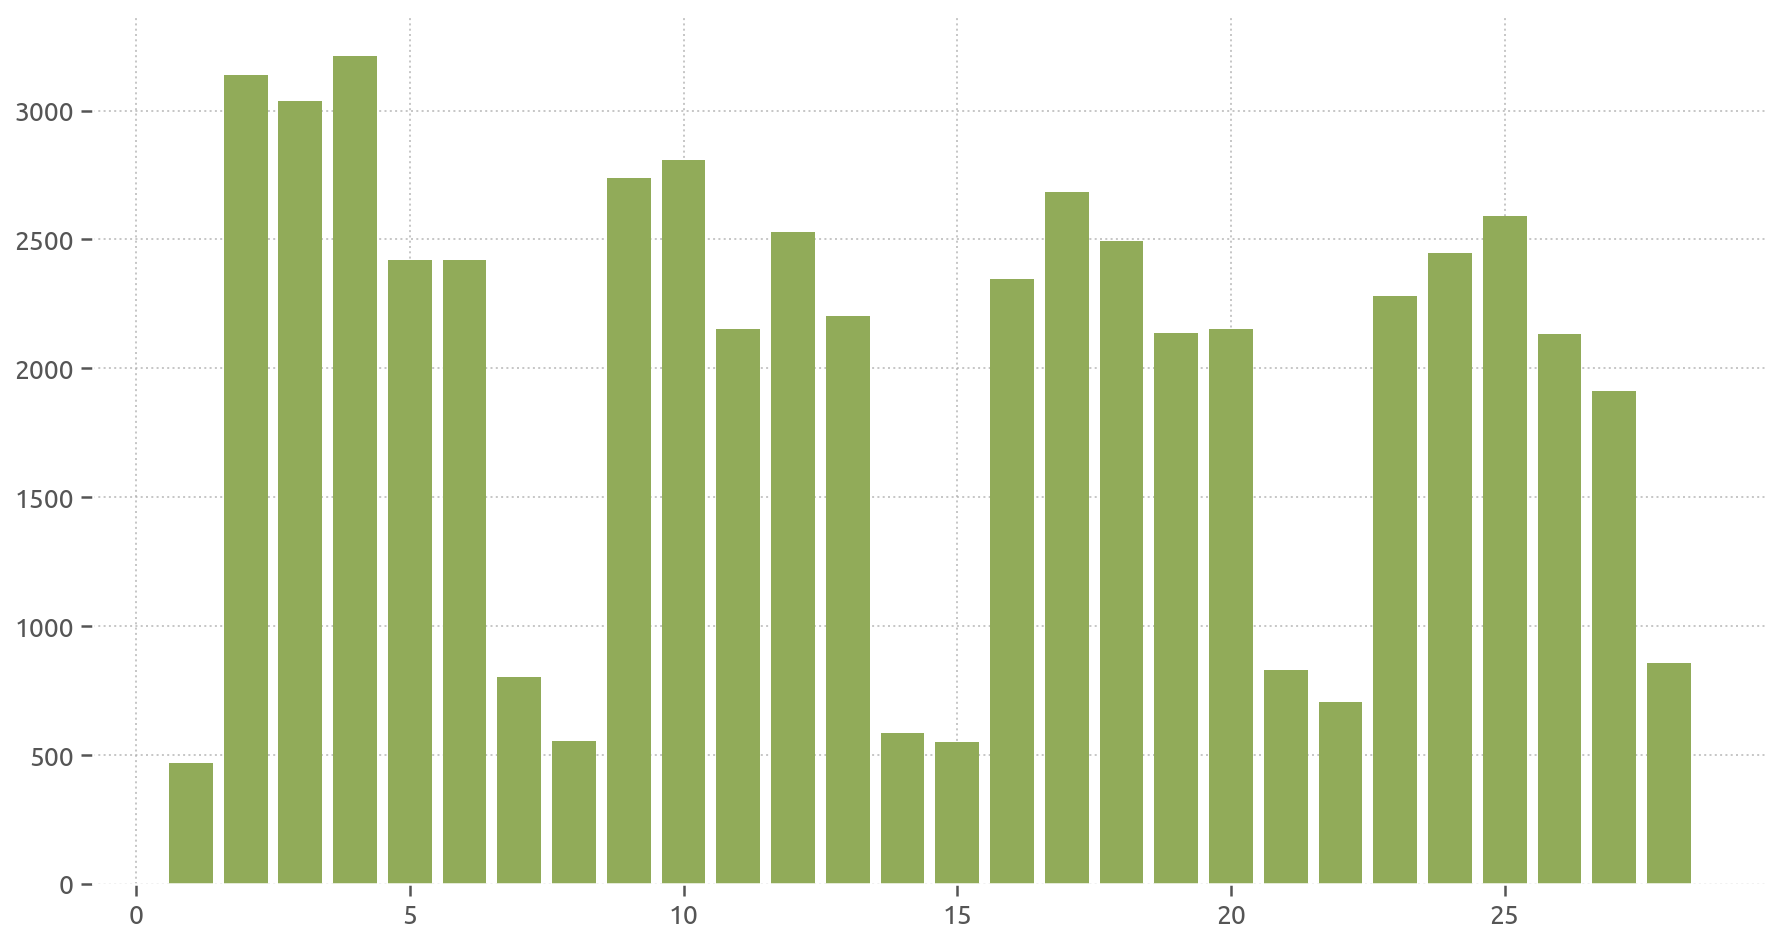

In [28]:
plt.bar(np.linspace(1,31,31), dados_202101['casos_novos'])
plt.show()
plt.bar(np.linspace(1,28,28), dados_202102['casos_novos'])
plt.show()

## Sazonalidade com pandas autocorrelation_plot

series aleatorias de sazonalidade tenderiam a uma correlacao igual a zero

In [33]:
from pandas.plotting import autocorrelation_plot

[Text(0.5, 1.0, 'Autocorrelação para diferentes lags temporais')]

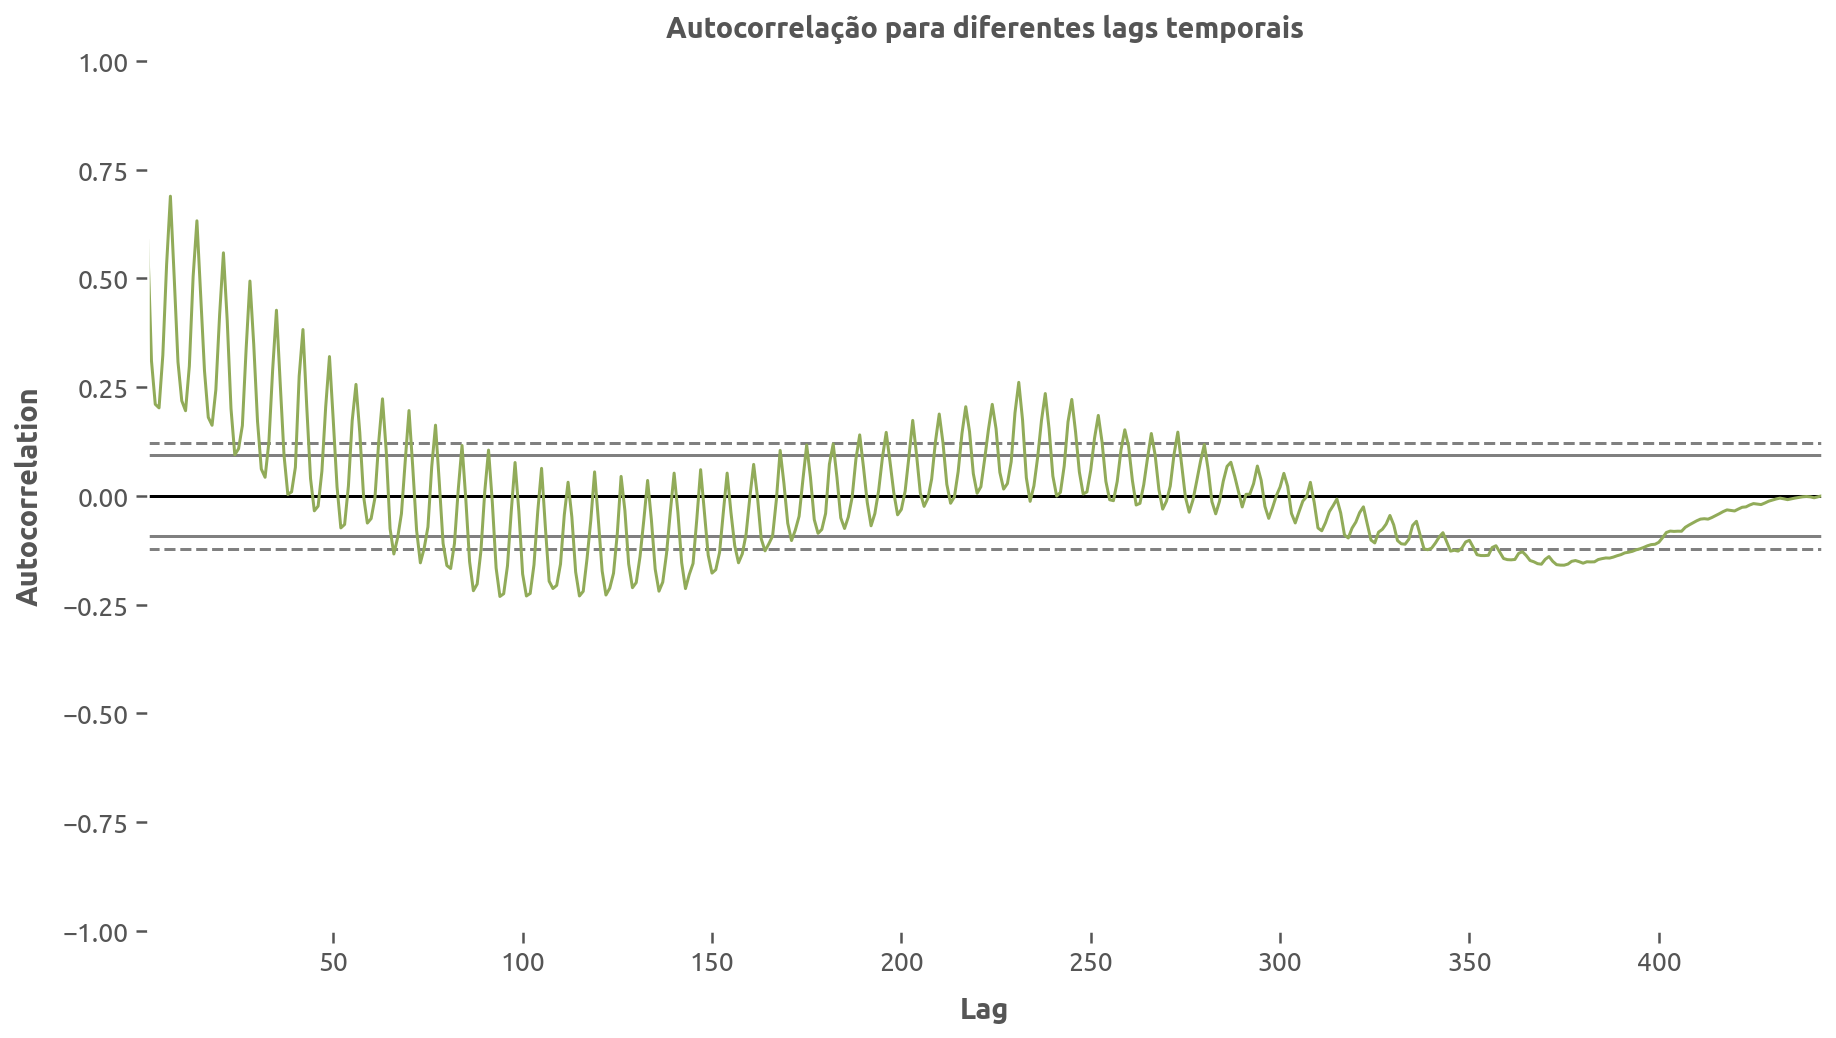

In [37]:
autocorrelation_plot(dados_sp['casos_novos']).set(title='Autocorrelação para diferentes lags temporais')

In [35]:
dados_sp.shape

(443, 31)

[Text(0.5, 1.0, 'Autocorrelação numa série aleatória')]

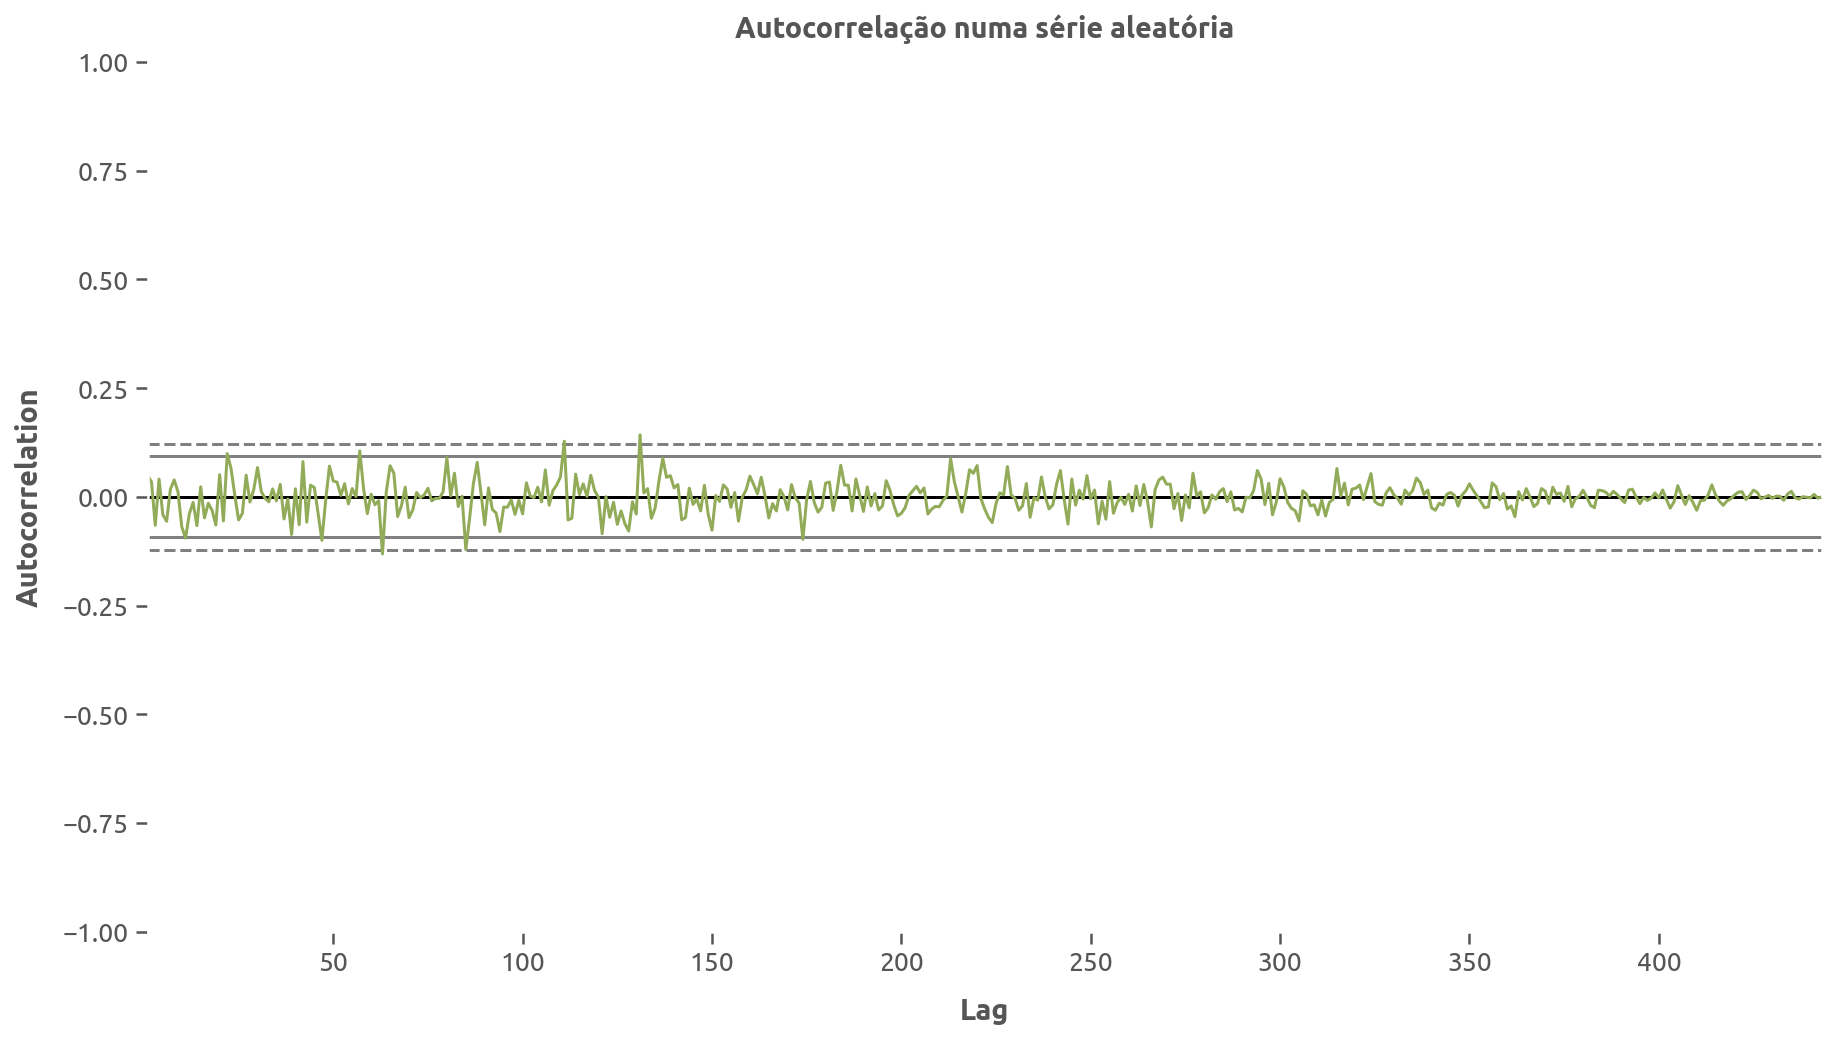

In [42]:
autocorrelation_plot(np.random.rand(443)).set(title='Autocorrelação numa série aleatória')

# Aula 2 - Primeiras Previsões com Prophet

O que aprendemos nesta aula?

- Vimos as primeiras previsões com o PROPHET;

- Fizemos a decomposição de séries temporais.

-----

Desafio 08: Mudar os períodos de previsão.

Desafio 09: Explorar a documentação do Prophet e melhorar os gráficos.

Desafio 10: Fazer todo o processo de previsão para o número de casos acumulados.

Você pode baixar acessar os códigos e dados desta aula por esse [link](https://github.com/alura-cursos/Prophet_covid/tree/aula2).

In [2]:
from prophet import Prophet

In [11]:
help(Prophet().plot)

Help on method plot in module prophet.forecaster:

plot(fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', figsize=(10, 6)) method of prophet.forecaster.Prophet instance
    Plot the Prophet forecast.
    
    Parameters
    ----------
    fcst: pd.DataFrame output of self.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    
    Returns
    -------
    A matplotlib figure.



In [6]:
df = pd.DataFrame()

In [7]:
df['ds'] = dados_sp['datahora']

In [8]:
df['y'] = dados_sp['casos_novos']

In [15]:
df.tail()

ds     y
283072 2021-05-08  1998
283717 2021-05-09  1285
284362 2021-05-10   538
285007 2021-05-11  2941
285652 2021-05-12  2808

In [9]:
modelo = Prophet()

In [10]:
modelo.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
dataframefuturo = modelo.make_future_dataframe(periods=30)
dataframefuturo.head()

ds
0 2020-02-25
1 2020-02-26
2 2020-02-27
3 2020-02-28
4 2020-02-29

In [12]:
previsao = modelo.predict(dataframefuturo)
previsao.head()

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2020-02-25 -132.930938  -789.484221  1459.690252  -132.930938  -132.930938   
1 2020-02-26 -115.660718  -783.486475  1700.232496  -115.660718  -115.660718   
2 2020-02-27  -98.390499  -650.672902  1785.920393   -98.390499   -98.390499   
3 2020-02-28  -81.120280  -801.274375  1489.105693   -81.120280   -81.120280   
4 2020-02-29  -63.850060 -1202.759155  1157.589067   -63.850060   -63.850060   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0      500.625587            500.625587            500.625587  500.625587   
1      555.128510            555.128510            555.128510  555.128510   
2      650.466258            650.466258            650.466258  650.466258   
3      368.252583            368.252583            368.252583  368.252583   
4       30.689727             30.689727             30.689727   30.689727   

   weekly_lower  weekly_upper  multiplicative_terms  \
0    500.625587    500.625587                   0.0   
1    555.128510    555.128510                   0.0   
2    650.466258    650.466258                   0.0   
3    368.252583    368.252583                   0.0   
4     30.689727     30.689727                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  367.694649  
1                         0.0                         0.0  439.467792  
2                         0.0                         0.0  552.075759  
3                         0.0                         0.0  287.132303  
4                         0.0                         0.0  -33.160333

In [ ]:
# components_fig = m.plot_components(forecast)
# axes = components_fig.get_axes()
# axes[0].set_xlabel('Date')

matplotlib.figure.Figure

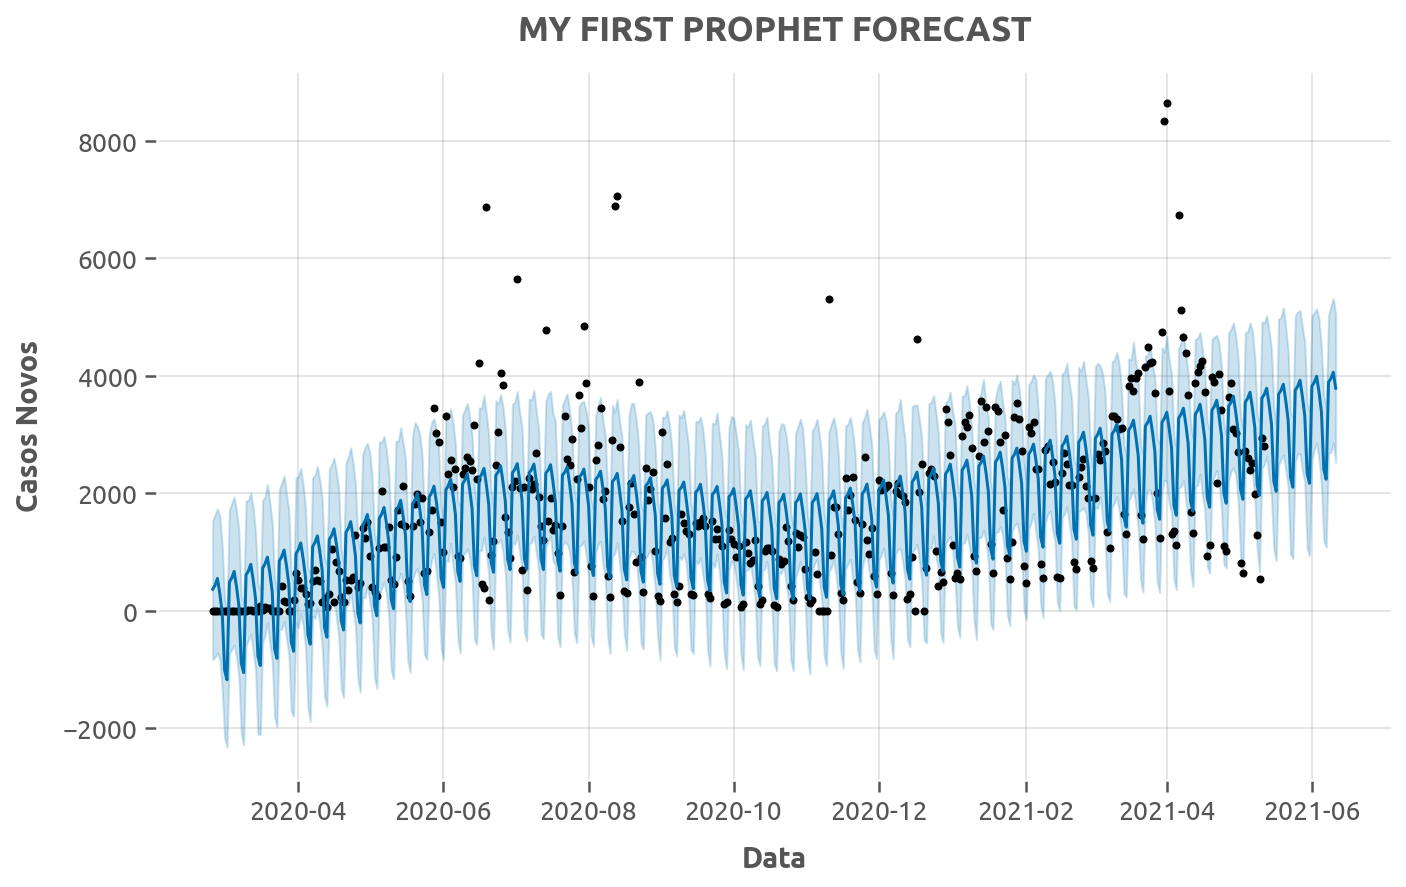

In [22]:
# fig = modelo.plot(previsao, xlabel= 'Data', ylabel='Casos Novos')\
#       .suptitle('My first prophet forecast'.upper(),x = 0.55, y = 1.03)
fig = modelo.plot(previsao, xlabel= 'Data', ylabel='Casos Novos')
fig.suptitle('My first prophet forecast'.upper(),x = 0.55, y = 1.03)

# axes = fig.get_axes()
# axes[0].set_xlabel('Data')

type(fig)

## Separando entre teste e treino

In [13]:
dados_sp.shape

(443, 31)

In [29]:
# 400 dias para treino
# 43 dias para teste
df = pd.DataFrame()
df['ds'] = dados_sp['datahora'][:400]

df['y'] = dados_sp['casos_novos'][:400]

modelo = Prophet(growth='linear')
modelo.fit(df)

dataframefuturo = modelo.make_future_dataframe(periods=43)
# dataframefuturo.head()

previsao = modelo.predict(dataframefuturo)
# previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
df_teste = pd.DataFrame()
df_teste['ds'] = dados_sp['datahora'][400:]
df_teste['y'] = dados_sp['casos_novos'][400:]

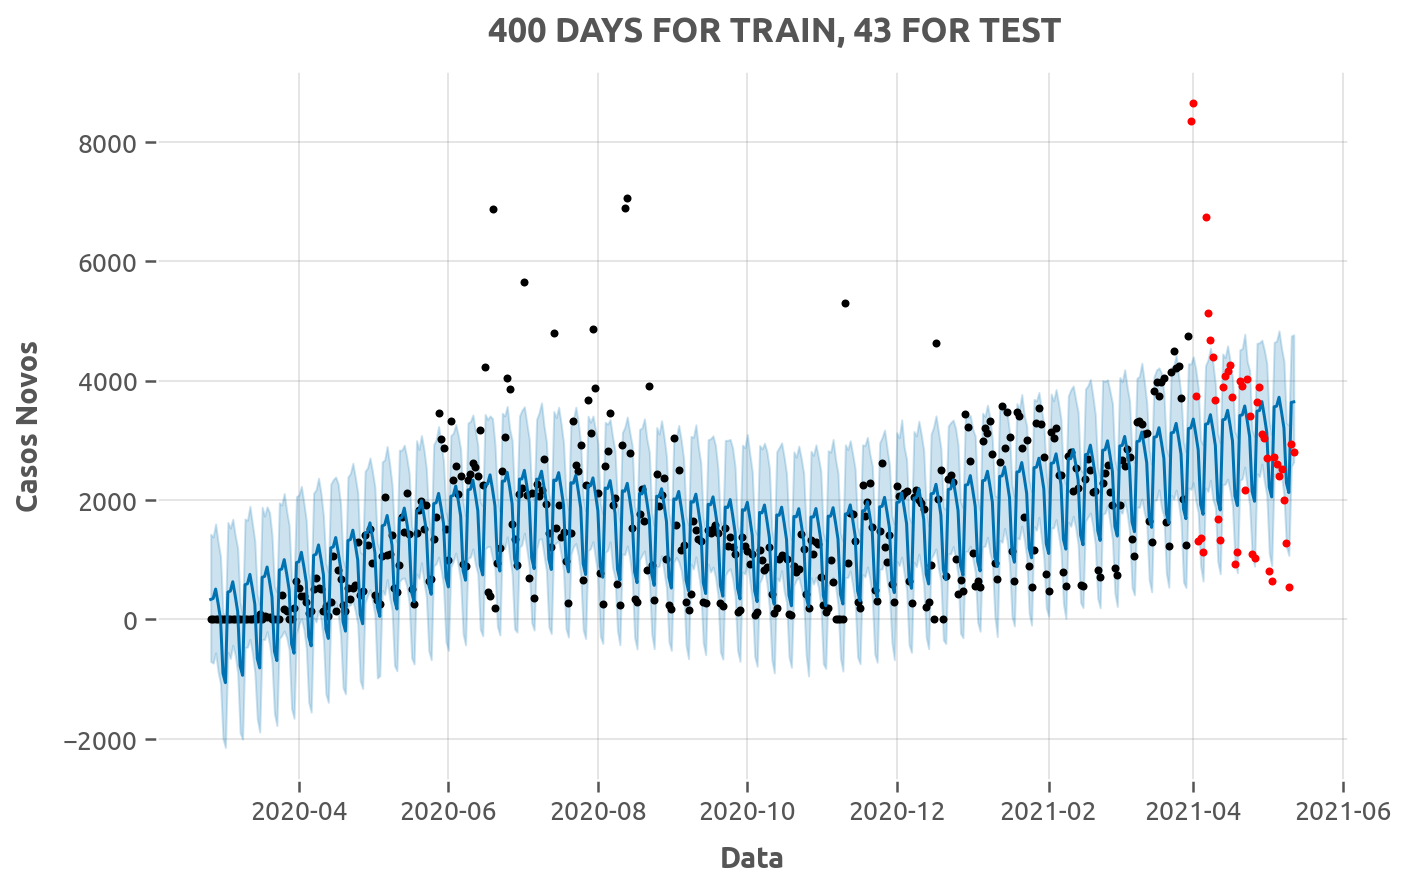

In [9]:
modelo.plot(previsao, xlabel= 'Data', ylabel='Casos Novos')\
      .suptitle('400 days for train, 43 for test'.upper(),x = 0.55, y = 1.03)
plt.plot(df_teste['ds'], df_teste['y'], '.r')

GridSpec(2, 1)

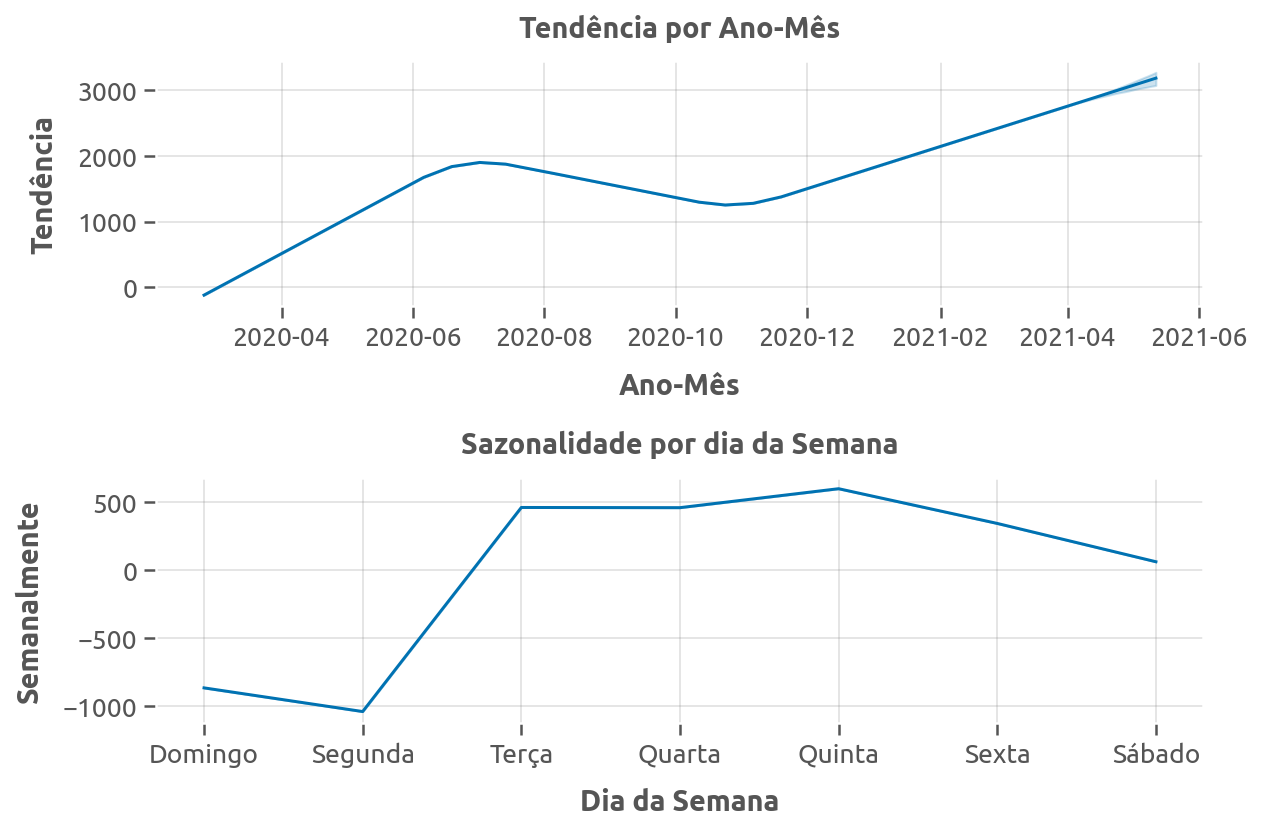

In [20]:
fig = modelo.plot_components(previsao);
axes = fig.get_axes()


titles=['Tendência por Ano-Mês', "Sazonalidade por dia da Semana"]
xlabels=['Ano-Mês', 'Dia da Semana']
ylabels=['Tendência', 'Semanalmente']


for ax in axes:
    i = axes.index(ax)
    ax.set(title = titles[i], xlabel=xlabels[i] , ylabel=ylabels[i])
    
axes[1].set(xticklabels=["Domingo", "Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado"])

plt.tight_layout()
axes[1].get_gridspec()
# axes[1].xaxis.get_gridlines()

## Interactive prophet plots with plotly

https://facebook.github.io/prophet/docs/quick_start.html

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

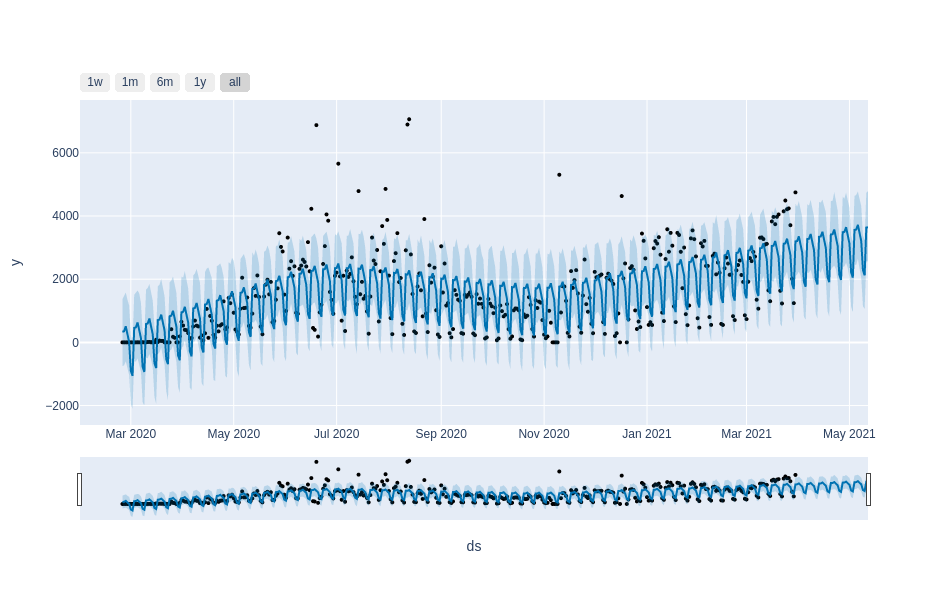

In [16]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(modelo, previsao)

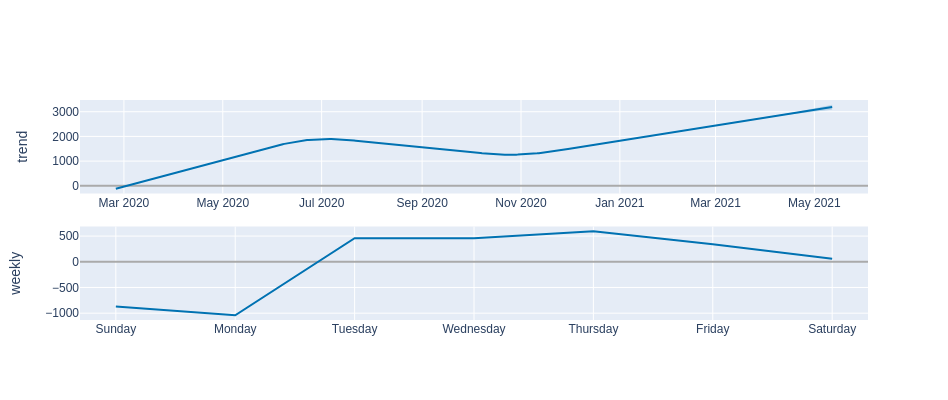

In [17]:
plot_components_plotly(modelo, previsao)

# Aula 3 - Mudança de Tendência

O que aprendemos ?

Curva com o crescimento logístico;

Mudança de tendência em uma série temporal;

Como decidir se houve mudança de tendência através de um gráfico de barras.

----

Desafio 11: Identificar potenciais changepoints.

Desafio 12: Desenvolver uma função roda o modelo automaticamente.

In [30]:
from prophet.plot import add_changepoints_to_plot

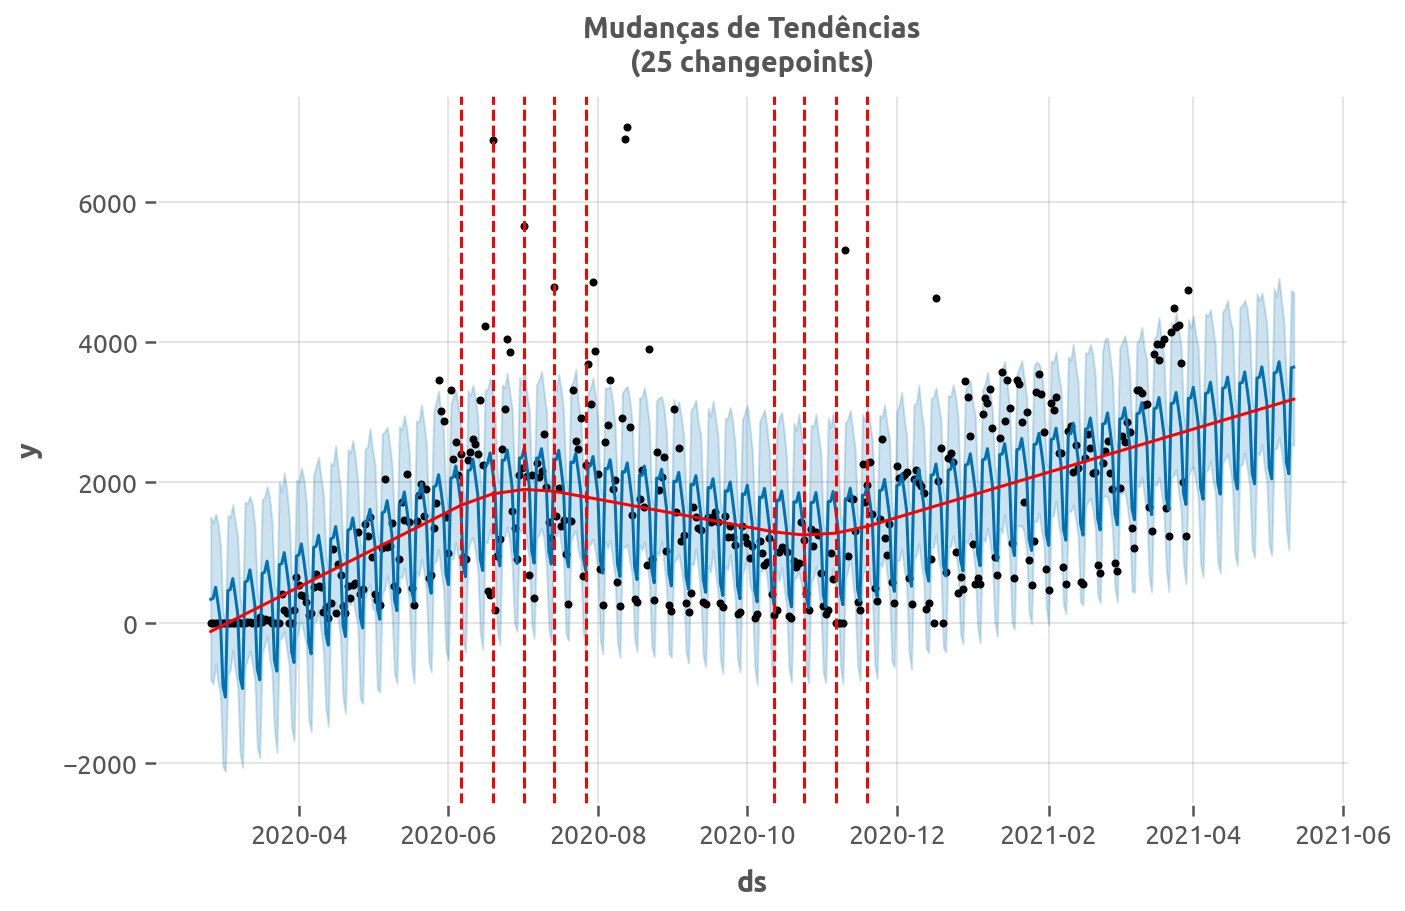

In [31]:
fig = modelo.plot(previsao)
fig.gca().set(title='Mudanças de Tendências\n(25 changepoints)')
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

In [32]:
modelo = Prophet(n_changepoints=50)
modelo.fit(df)

dataframefuturo = modelo.make_future_dataframe(periods=43)
# dataframefuturo.head()

previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


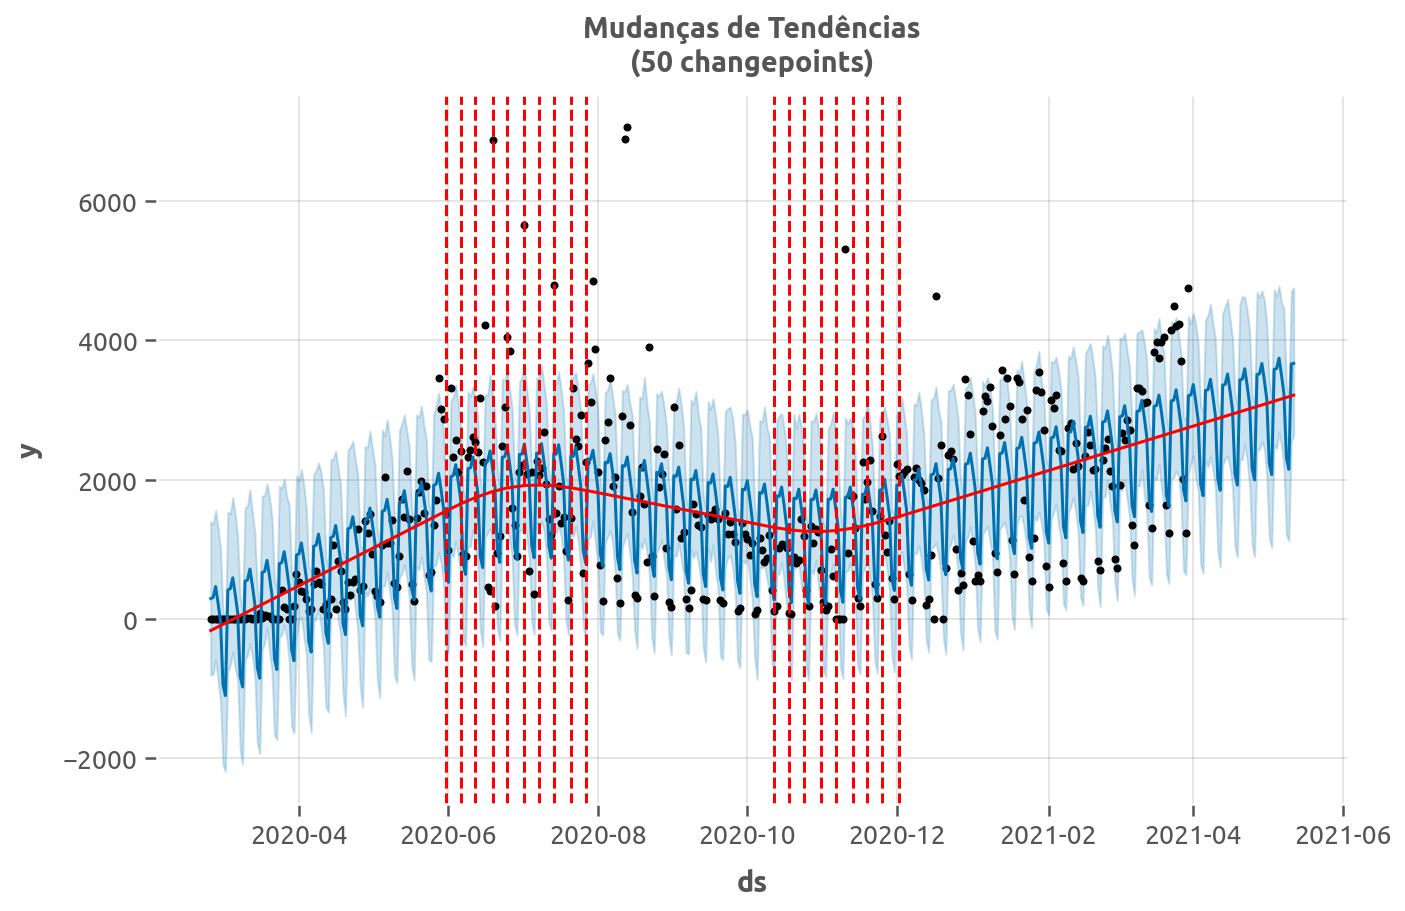

In [33]:
fig = modelo.plot(previsao)
fig.gca().set(title='Mudanças de Tendências\n(50 changepoints)')
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


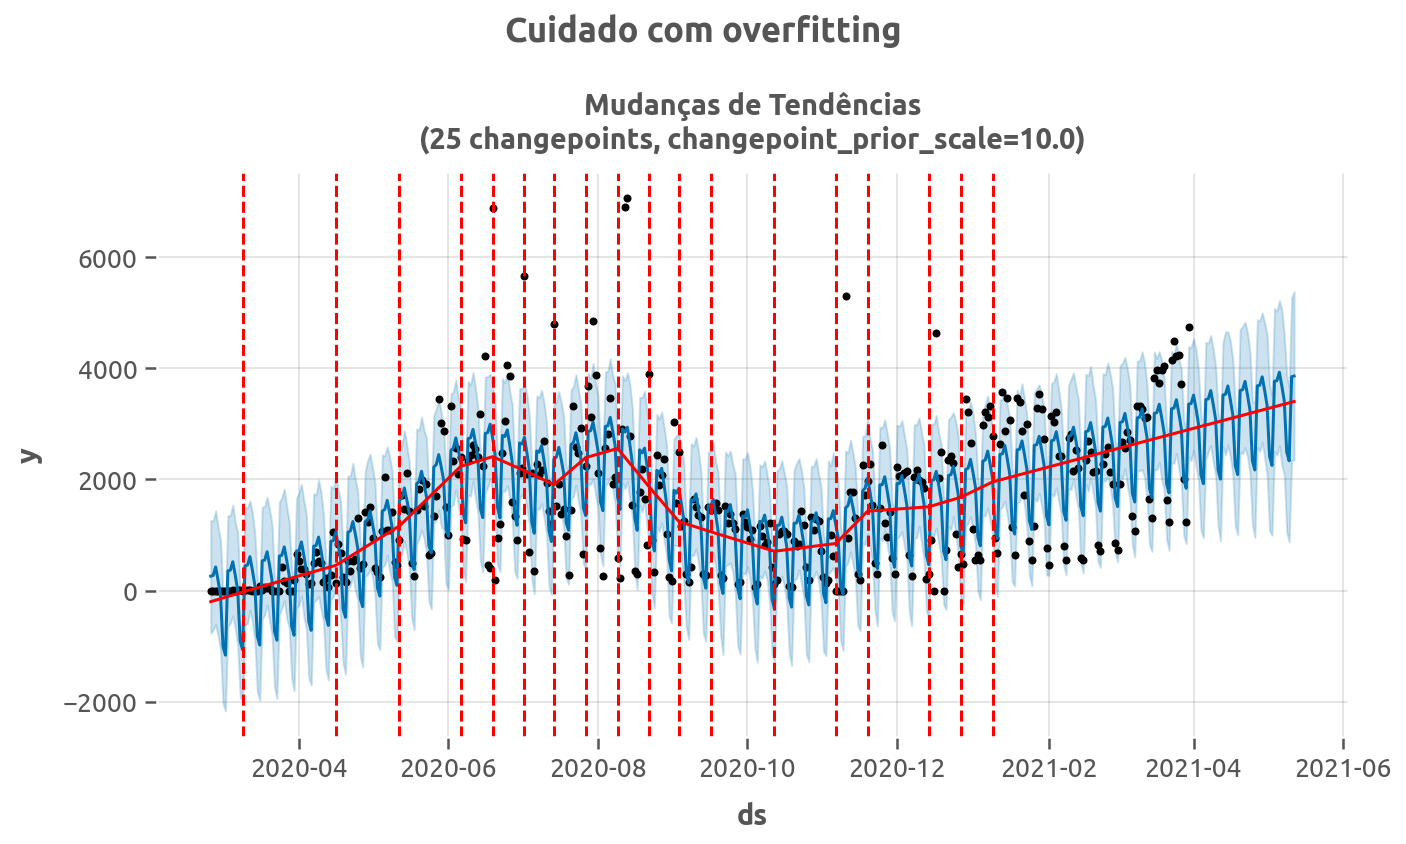

In [37]:
modelo = Prophet(n_changepoints=25, changepoint_prior_scale=10.0)
modelo.fit(df)

dataframefuturo = modelo.make_future_dataframe(periods=43)
# dataframefuturo.head()

previsao = modelo.predict(dataframefuturo)

fig = modelo.plot(previsao)
fig.gca().set(title='Mudanças de Tendências\n(25 changepoints, changepoint_prior_scale=10.0)')
fig.suptitle('Cuidado com overfitting')
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

plt.tight_layout()

## Functions

In [21]:
def cria_dfs(dados_sp):
    df = pd.DataFrame()
    df['ds'] = dados_sp['datahora'][:400]
    df['y'] = dados_sp['casos_novos'][:400]

    df_teste = pd.DataFrame()
    df_teste['ds'] = dados_sp['datahora'][400:]
    df_teste['y'] = dados_sp['casos_novos'][400:]
    
    return df, df_teste

def prophet_plot(df, title, **prophetargs):

    modelo = Prophet(**prophetargs)
    # modelo['cap'] = 6000
    modelo.fit(df)

    dataframefuturo = modelo.make_future_dataframe(periods=43)
    # dataframefuturo['cap'] = 6000

    previsao = modelo.predict(dataframefuturo)

    fig = modelo.plot(previsao)
    fig.gca().set(title=title)
    a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

#     plt.tight_layout()
df, df_teste = cria_dfs(dados_sp)

In [ ]:
prophet_plot(df, 'Mudanças de Tendências\n(25 changepoints, growth=logistic)',
       changepoints=['2020-12-31'])

## Anotações

n_changepoints é o "nível de zoom", ou algo assim 
me lembra o "asfalto fractal" de k lars lohn em sua [palestra na PyCon 2016](https://www.youtube.com/watch?v=bSfe5M_zG2s&t=451s)

changepoints são as derivadas


Pesquisar sobre:
- [regressão logística](https://en.wikipedia.org/wiki/Logistic_function), sigmóide
- processamento de sinais em python

Para uma abordagem interessante de como encontrar sazonalidades pela frequência de um sinal, ver: https://github.com/fdrigui/BootcampDS/blob/main/modulo_tres/Aula_01.ipynb



## Monitoria sobre correlação cruzada

Notebook da apresentação disponível em: 
https://github.com/allanspadini/live_bootcamp_cross_validation/blob/main/Live_bootcamp_cross_validation.ipynb

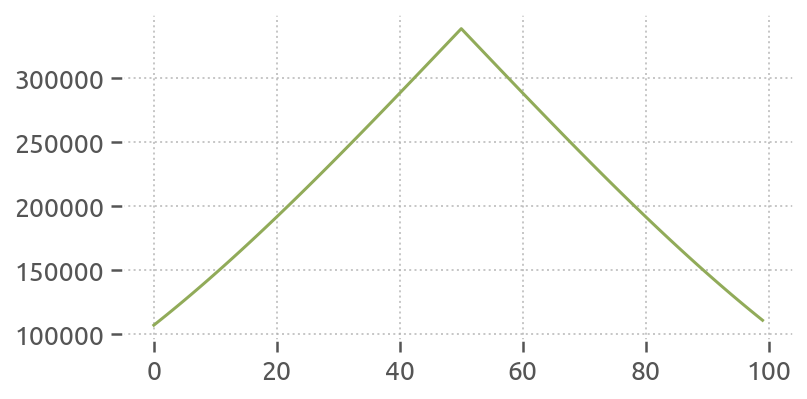

In [3]:
plt.figure(figsize=(6,3))
plt.plot(np.correlate(np.linspace(1,100,100), np.linspace(1,100,100), 'same'))

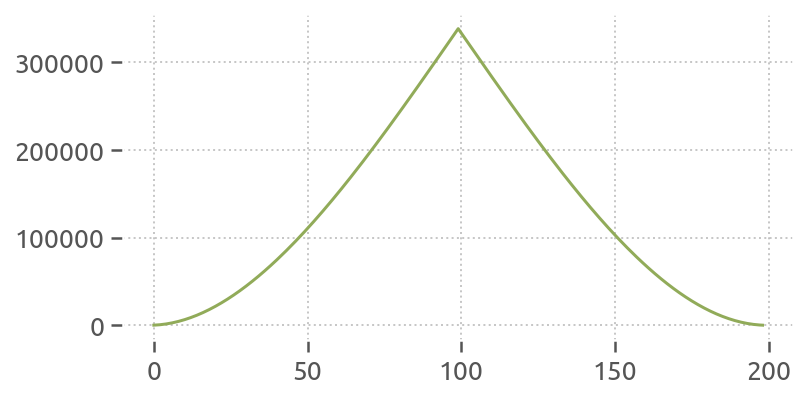

In [4]:
plt.figure(figsize=(6,3))
plt.plot(np.correlate(np.linspace(1,100,100), np.linspace(1,100,100), 'full'))

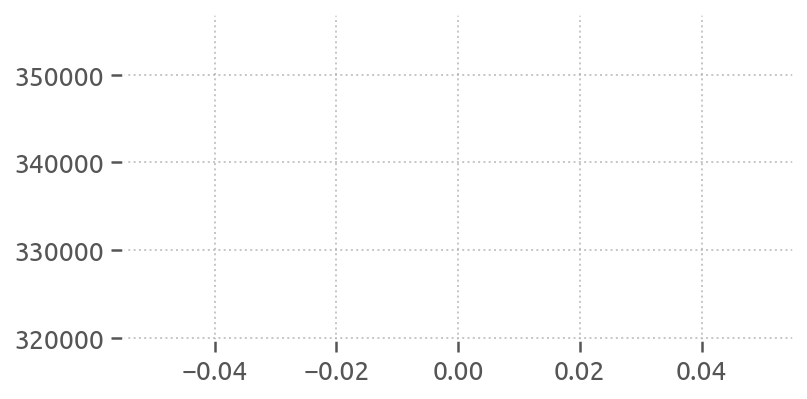

In [5]:
plt.figure(figsize=(6,3))
plt.plot(np.correlate(np.linspace(1,100,100), np.linspace(1,100,100), 'valid'))

In [ ]:
# !pip3 install statsmodels

In [4]:
from statsmodels.tsa.stattools import ccf # cross correlation function
# based on numpy.correlation

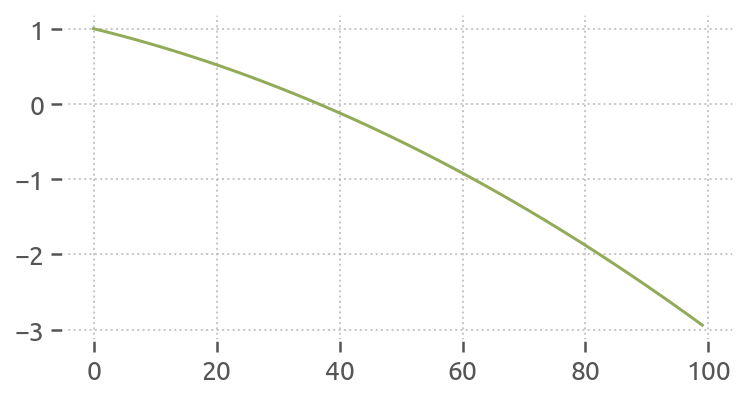

In [9]:
plt.figure(figsize=(6,3))
plt.plot(ccf(np.linspace(1,100,100), np.linspace(1,100,100), adjusted=True))

- Pesquisar sobre convolução
- numpy.correlate
- o desafio era a correlação cruzada entre número de óbitos e casos

In [55]:
from pandas.plotting import autocorrelation_plot

### Trying interactive plots

https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/

In [77]:
# from ipywidgets import widgets
from IPython.html.widgets import interact

def plott(x):
    xx = range(x)
    y = range(x, x*2)
    plt.plot(xx, y)
    plt.show()
    autocorrelation_plot(ccf(np.linspace(1,100,100), np.linspace(1,np.sin(x*np.pi),100), adjusted=True))
    
interact(plott, x=(1,20,2))

interactive(children=(IntSlider(value=9, description='x', max=20, min=1, step=2), Output()), _dom_classes=('wi…

<function __main__.plott(x)>

# Aula 4 - Feriados e sazonalidades nas séries temporais

**A partir desta aula mudei a cor padrão do Prophet para verde ('#91ab59'), no módulo prophet.plot.py**


Nesta aula, aprendemos:

Efeito da sazonalidade e feriados em uma série temporal;

Sazonalidade aditiva e sazonalidade multiplicativa;

Previsões considerando sazonalidade e feriados com o PROPHET.

---

Agora chegou o momento de se desafiar, resolvendo os problemas propostos pelo Allan e pela Karol.

Desafio Extra: Utilizar outras métricas do Scikitlearn e comparar os resultados.

Você pode baixar acessar os códigos e dados desta aula por esse [link](https://github.com/alura-cursos/Prophet_covid/tree/aula4).


In [5]:
dados_202101 = dados_sp.query('mes==1 & ano==2021')
dados_202102 = dados_sp.query('mes==2 & ano==2021')

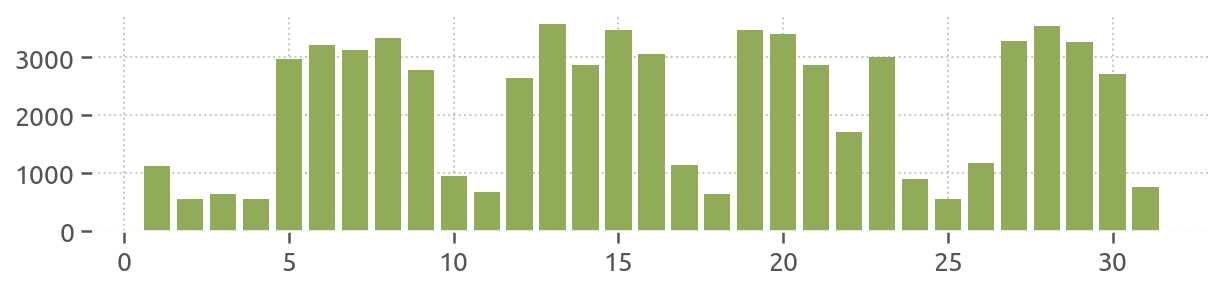

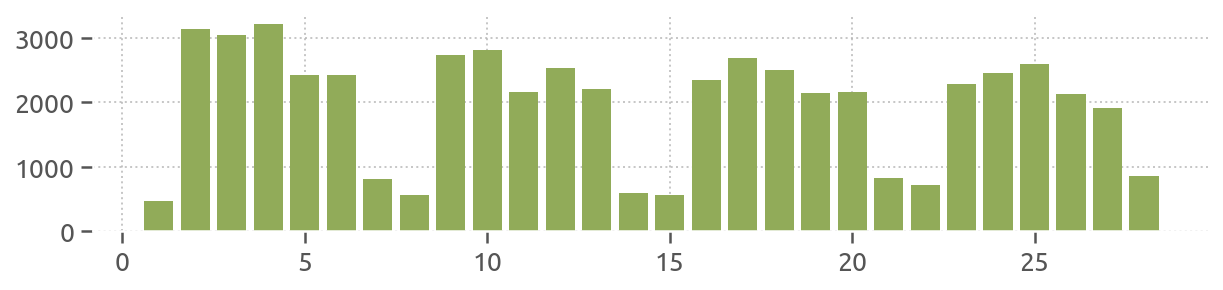

In [6]:
with plt.style.context({'figure.figsize': (10,2)}):

    plt.bar(np.linspace(1,31,31), dados_202101['casos_novos'])
    plt.show()
    plt.bar(np.linspace(1,28,28), dados_202102['casos_novos'])
    plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


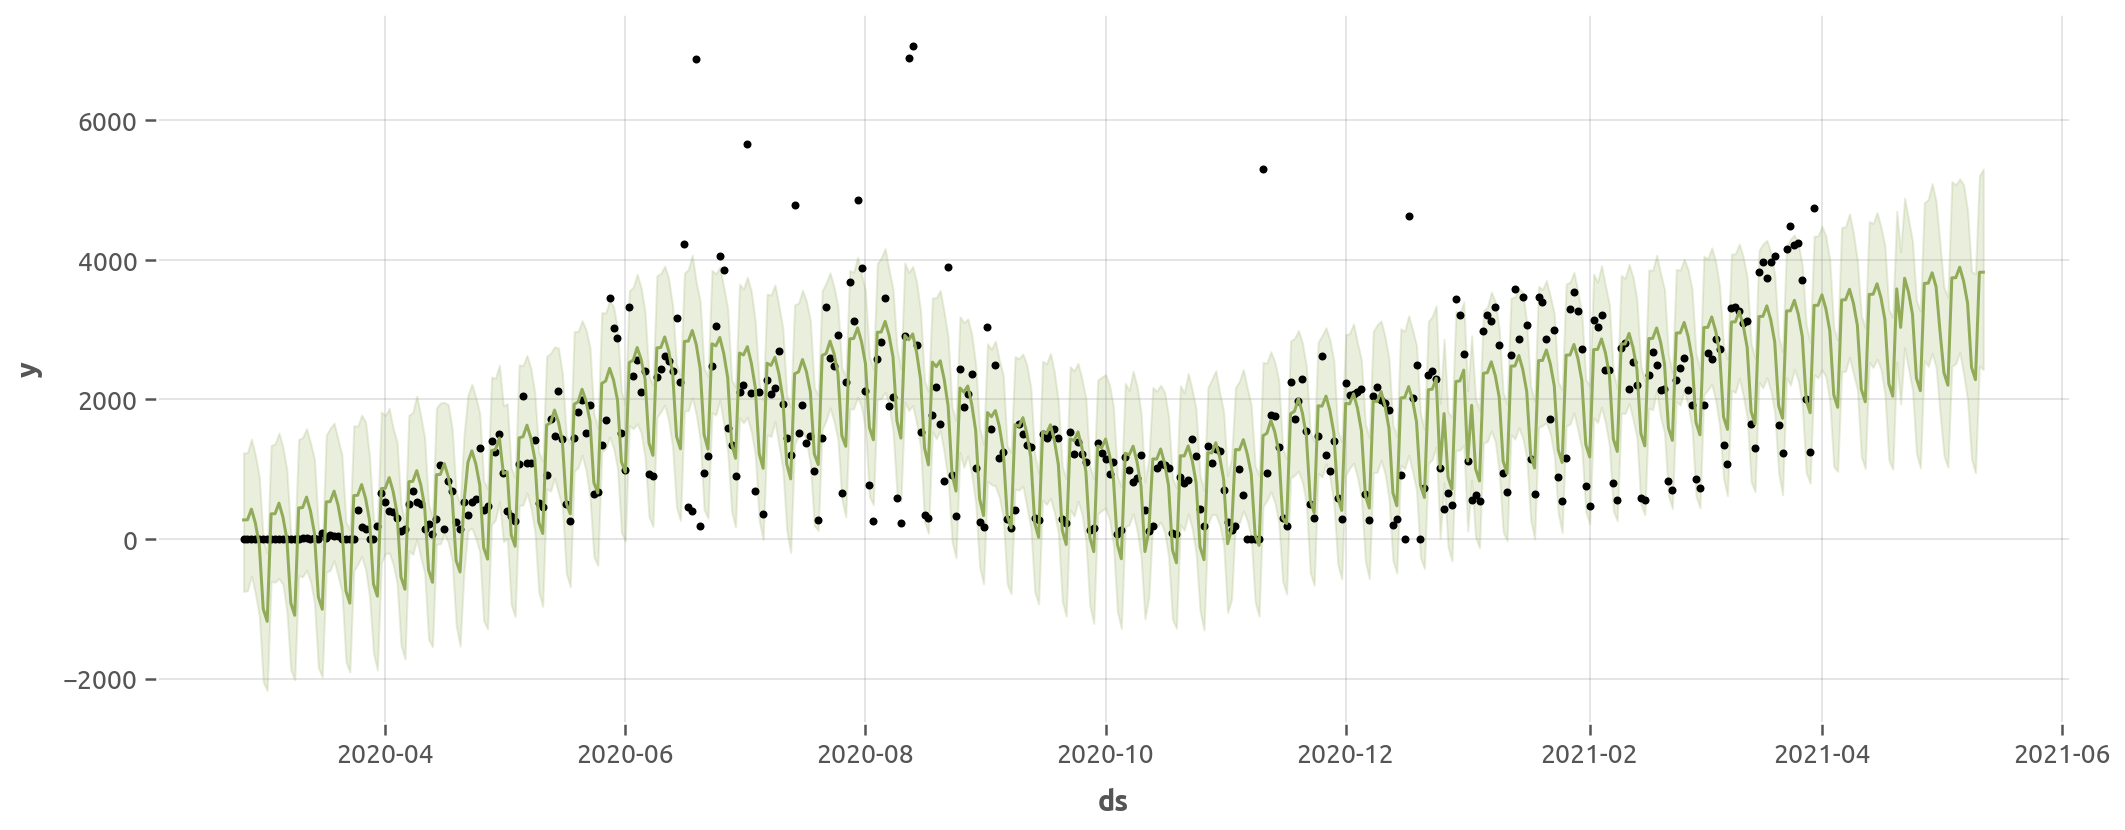

In [37]:
modelo = Prophet(changepoint_prior_scale=10)
modelo.add_country_holidays(country_name = 'BR')
modelo.fit(df)
dataframefuturo = modelo.make_future_dataframe(periods=43)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, figsize=(15,6))

Feriados nacionais não são suficientes, vamos pegar também os feriados municipais

In [5]:
# fonte = https://github.com/alura-cursos/Prophet_covid/blob/aula4/Curso_Series_Temporais_Bootcamp_Aula4.ipynb

feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]


In [6]:
feriados_sp_2020_df = pd.DataFrame({'holiday': 'sp_2020',
                                   'ds': pd.to_datetime(feriados_sp_2020)})

feriados_sp_2021_df = pd.DataFrame({'holiday': 'sp_2021',
                                   'ds': pd.to_datetime(feriados_sp_2021)})

feriados = pd.concat((feriados_sp_2020_df, feriados_sp_2021_df))

## Comparando sazonalidades aditiva e multiplicativa

In [7]:
from sklearn.metrics import mean_absolute_error

In [48]:
df

ds     y
562    2020-02-25     0
1207   2020-02-26     0
1852   2020-02-27     0
2497   2020-02-28     1
3142   2020-02-29     0
...           ...   ...
255337 2021-03-26  4241
255982 2021-03-27  3709
256627 2021-03-28  2010
257272 2021-03-29  1242
257917 2021-03-30  4748

[400 rows x 2 columns]

In [85]:
df_sem_outliers.shape

(351, 2)

In [97]:
def comparing_seasonalities(df_to_fit, periods, seasonality_mode, title, lineplot = False, returns_MAE = True, plot_validation_dots=False, df_validation=df_teste):
    modelo_feriados = Prophet(changepoint_prior_scale=10.0, 
                            holidays=feriados, 
                            seasonality_mode =seasonality_mode)
    modelo_feriados.fit(df_to_fit)
    dataframefuturo = modelo_feriados.make_future_dataframe(periods=periods)
    previsao = modelo_feriados.predict(dataframefuturo)
    fig = modelo_feriados.plot(previsao, figsize=(15,6))
    fig.gca().set(title=title)

    if plot_validation_dots:
        fig.gca().plot(df_validation['ds'], df_validation['y'], 'r.')
    
    if lineplot:
        fig.gca().plot(df_to_fit['ds'], df_to_fit['y'], '0.5')
    modelo_feriados.plot_components(previsao, figsize=(15,8)).suptitle(title + '- Components')
    
    if returns_MAE:
        return previsao, mean_absolute_error(df_to_fit['y'], previsao['yhat'][:400])
    else:
        return previsao, modelo_feriados

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


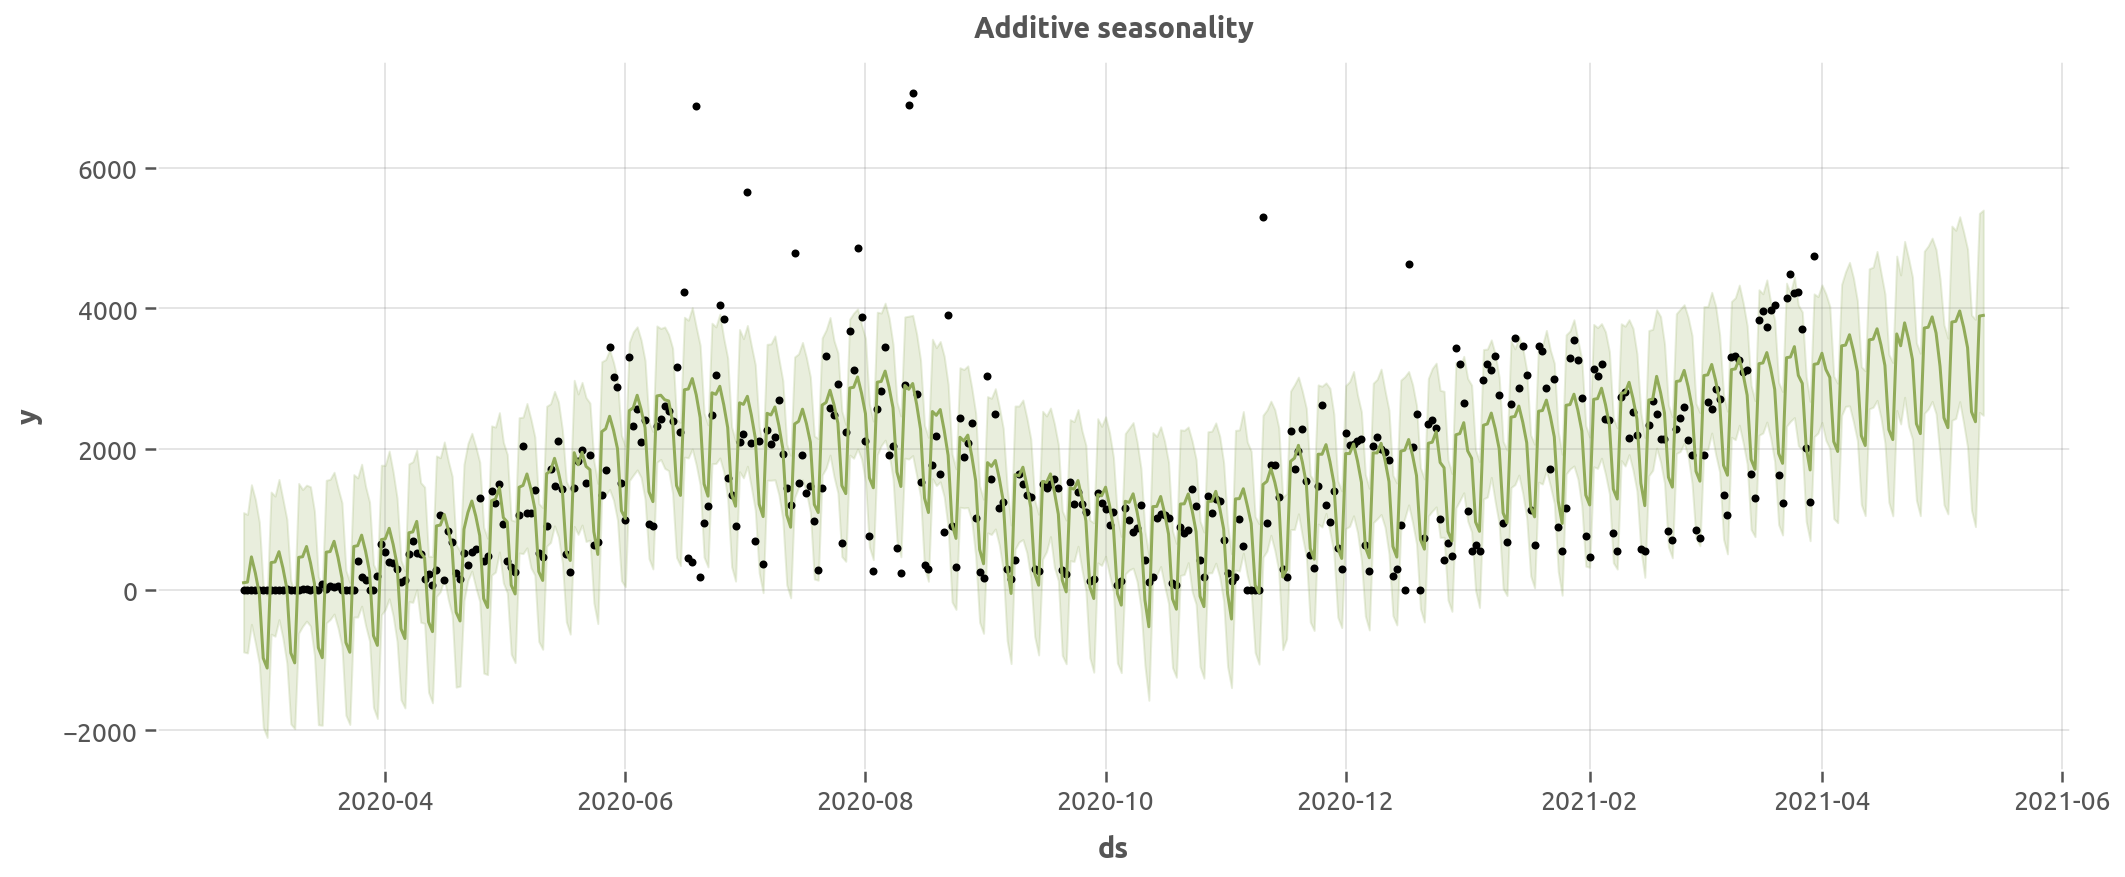

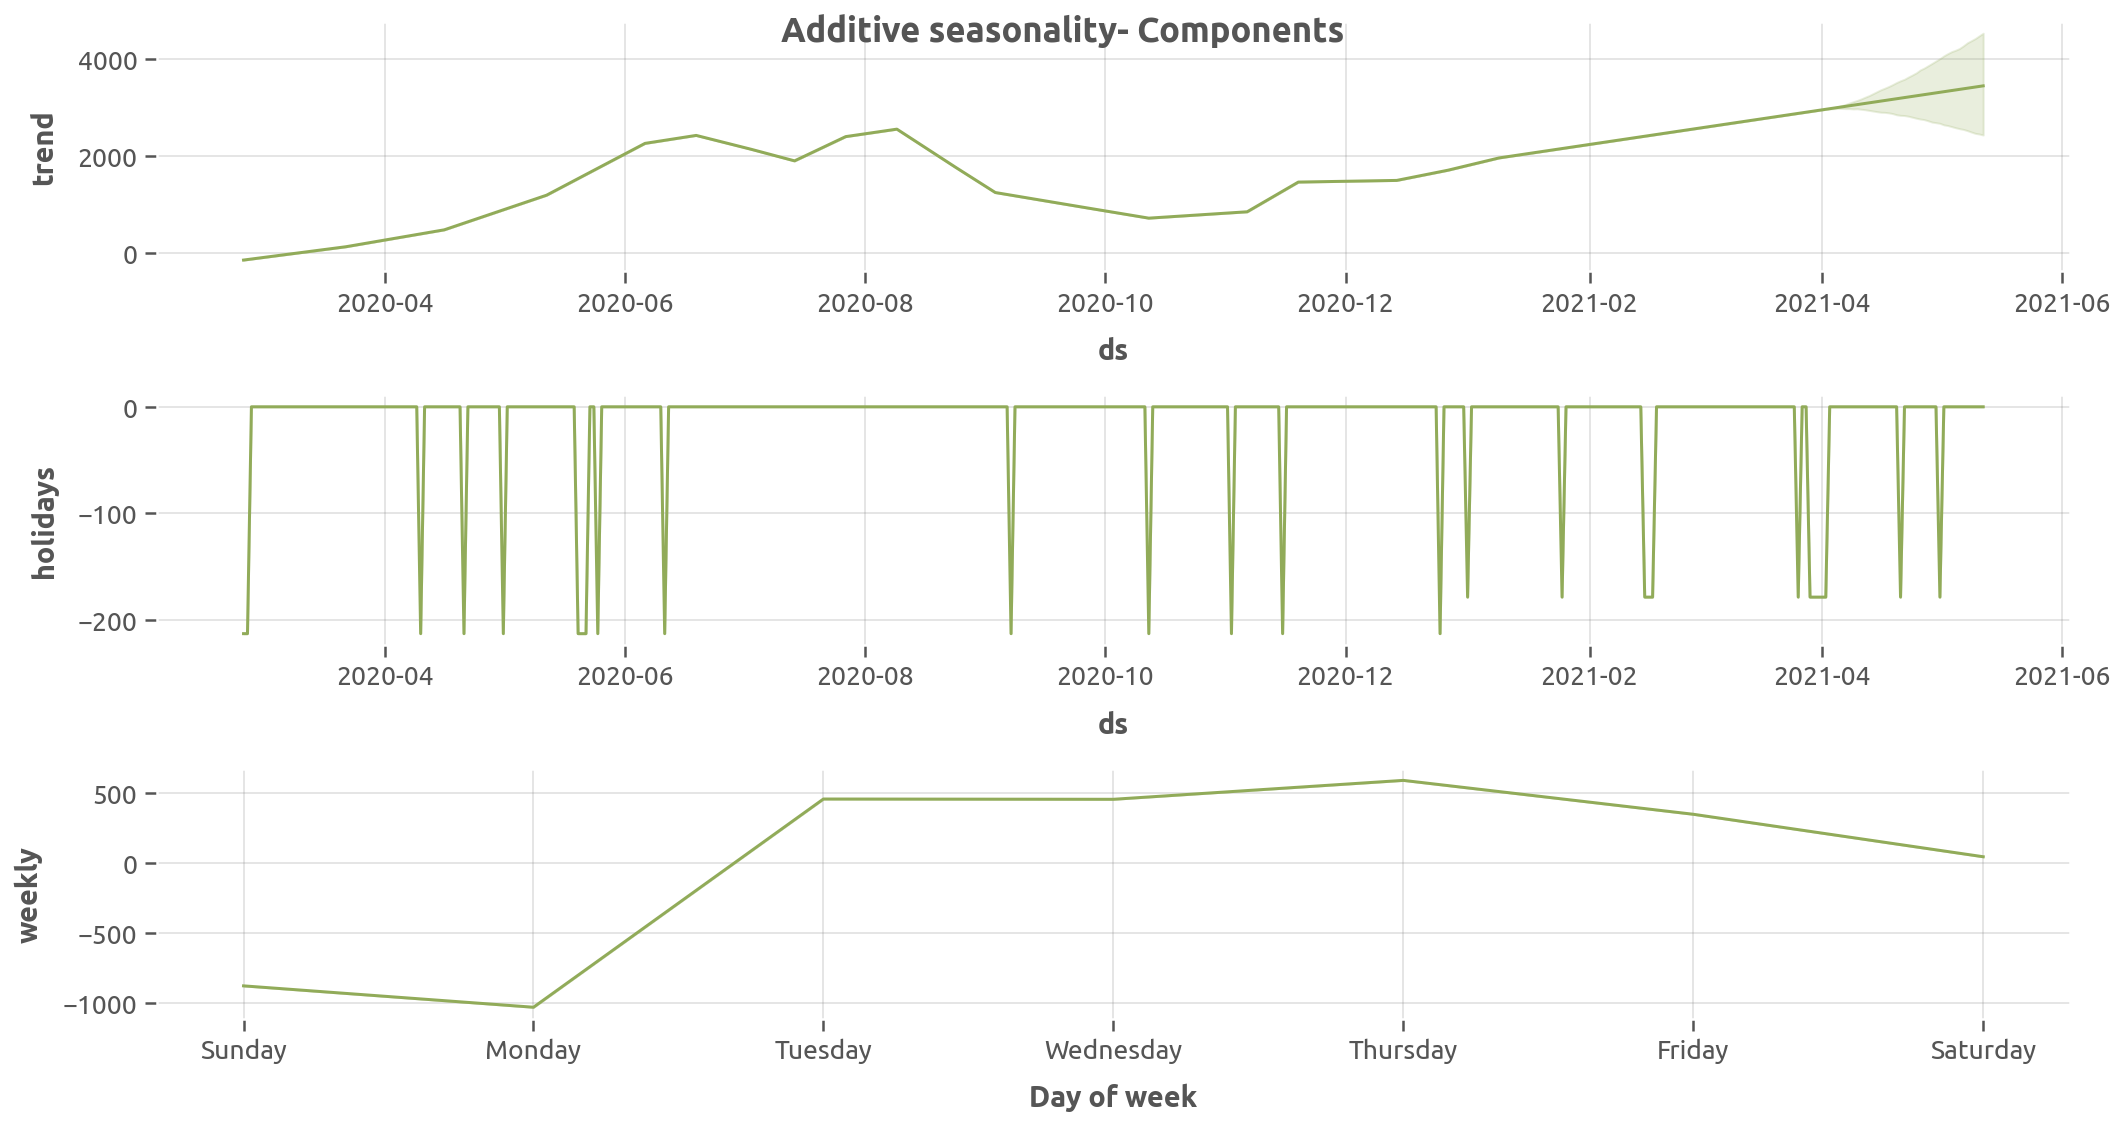

In [9]:
previsao, MAE_additive = comparing_seasonalities(df, periods=43, seasonality_mode='additive',
                                       title='Additive seasonality',
                                       lineplot=False)

Trend -> tendencia geral da série  
Holidays -> correção da tendência geral dos casos notificados de acordo com a redução em dias de feriado  
Weekly -> ĉorreção da tendência geral de acordo com o dia da semana

Na prática, o número de casos num determinado dia x será próximo a:
  
$casos = trend(x) + holidays(x) + weekly(x)$

Isso porque o padrão do prophet é *seasonality_mode='additive'*

Agora, testaremos o modo 'multiplicativo'

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


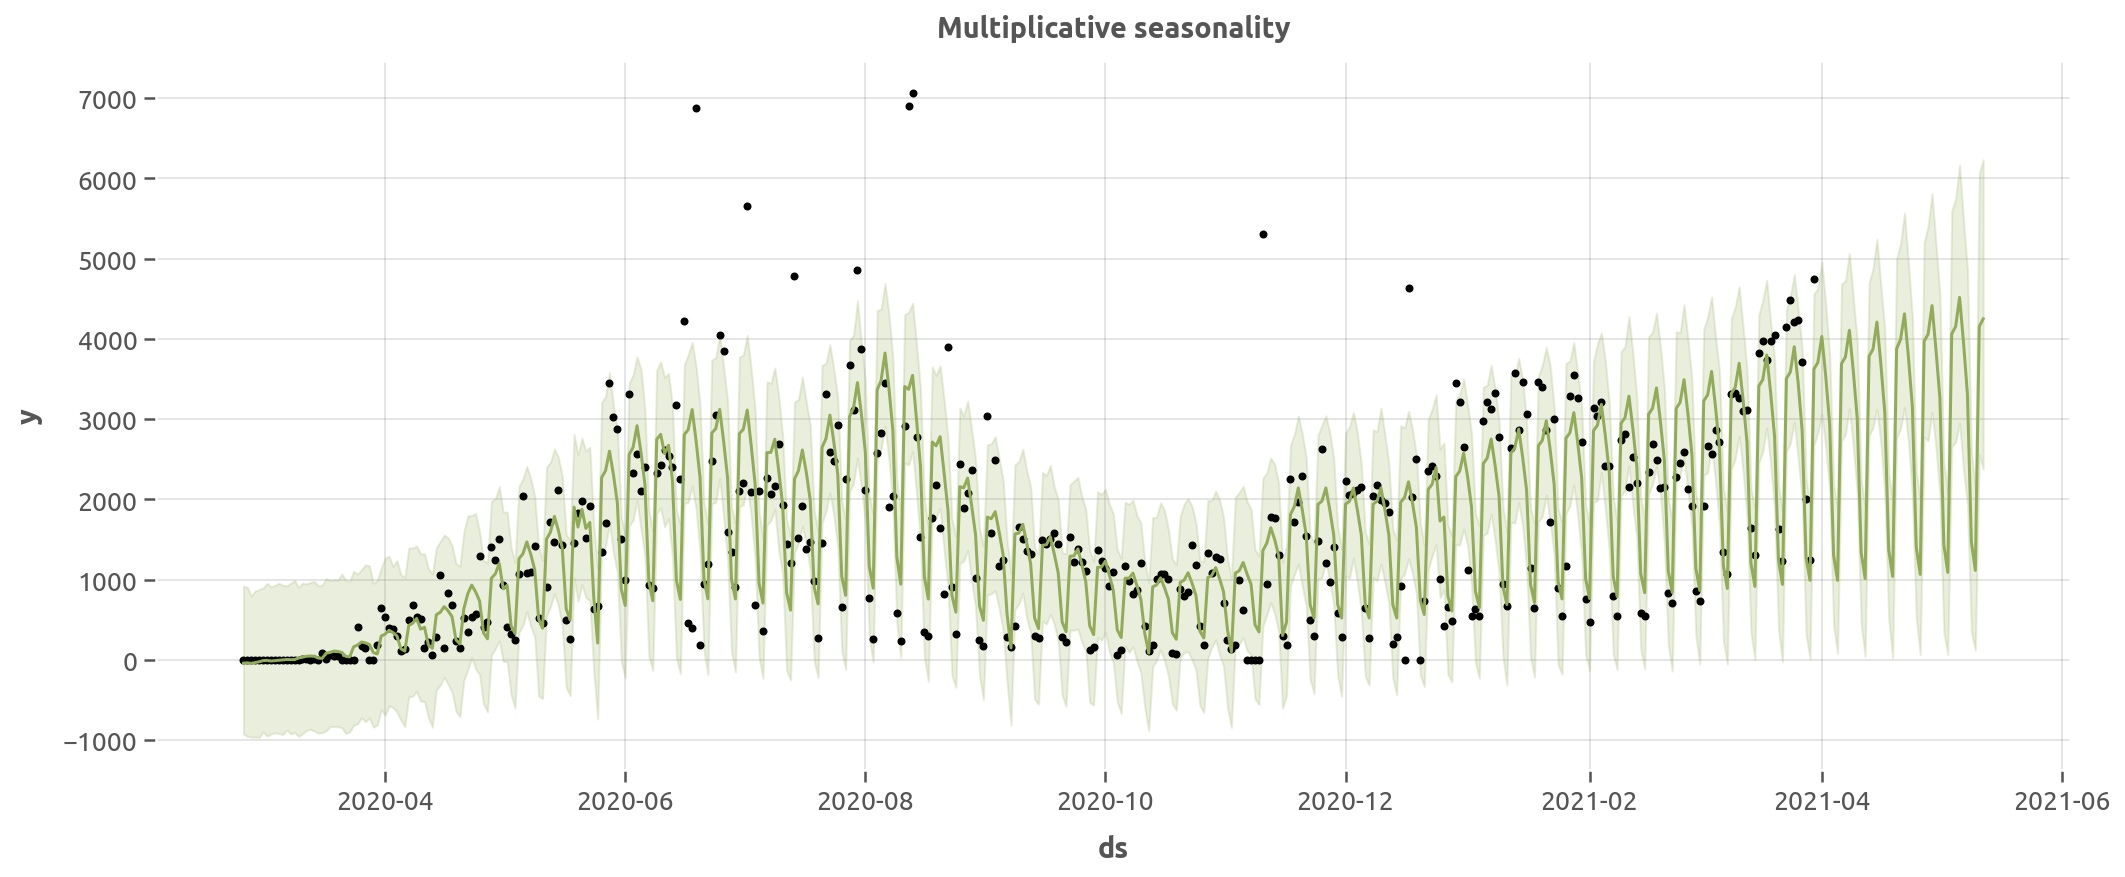

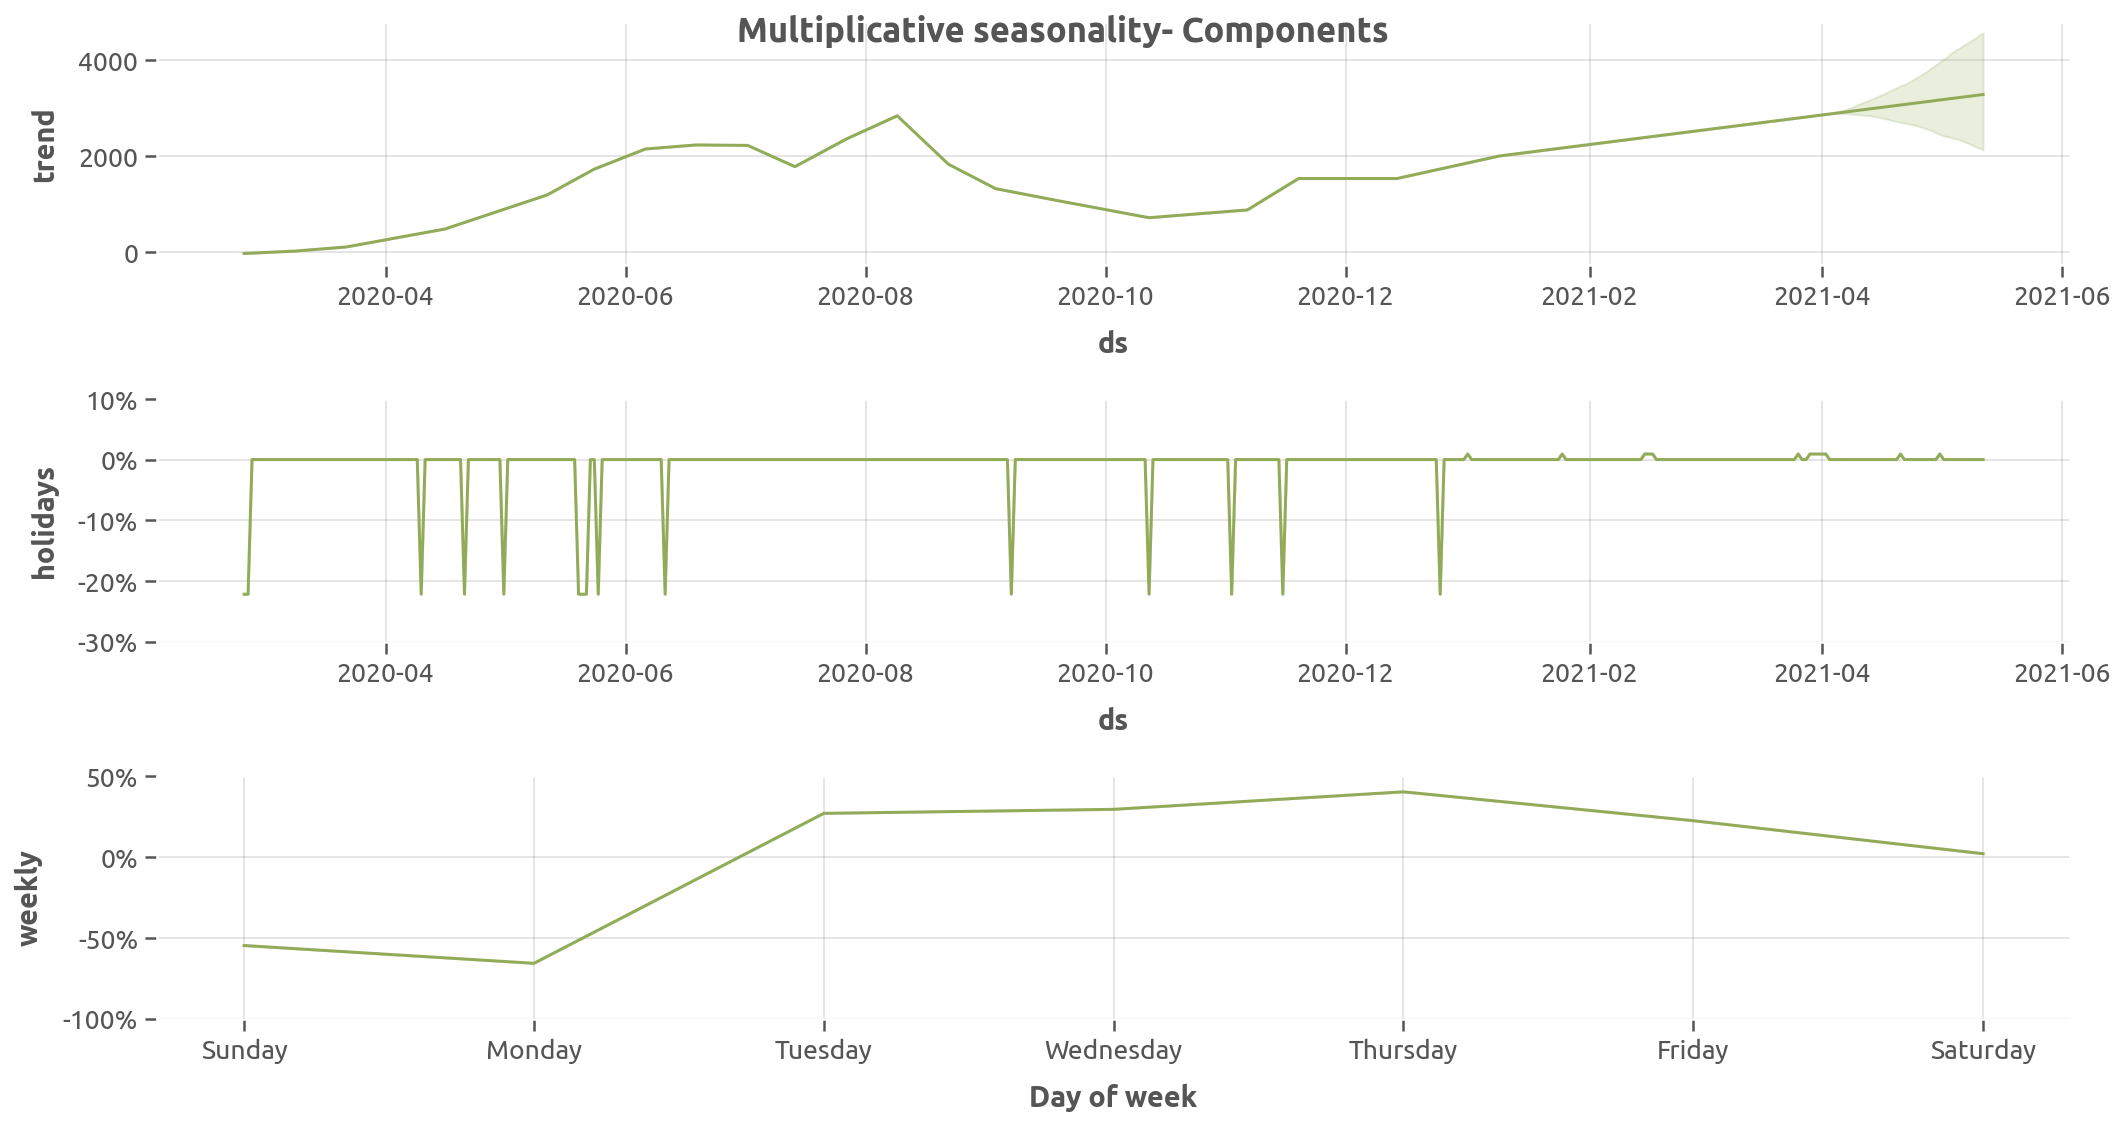

In [10]:
previsao, MAE_multiplicative = comparing_seasonalities(df, periods=43,                      
                                        seasonality_mode='multiplicative',
                                        title='Multiplicative seasonality', 
                                        lineplot=False)

In [61]:
# comparing mean_absolute_error
print('Mean Absolute Error', end='\n')
print(f'Additive Seasonality: {MAE_additive:.2f}')
print(f'Multiplicative Seasonality: {MAE_multiplicative:.2f}')

Mean Absolute Error
Additive Seasonality: 536.66
Multiplicative Seasonality: 452.21


# Aula 5 - Outliers e Validação


Nesta aula, aprendemos:

Tratamento de outliers;

Intervalo de confiança;

Validação cruzada de encadeamento direto;

Métricas de performance.

-----

Desafio 13: Testar diferentes intervalos de confiança.

Desafio 14: Buscar quais métricas se aplicam a quais casos. (mae, mse, rmse, mdape)

Você pode baixar acessar os códigos e dados desta aula por esse [link](https://github.com/alura-cursos/Prophet_covid/tree/aula5)


## Outliers e intervalo de confiança

In [12]:
novo_y = df.reset_index()

In [13]:
novo_y.head()

index         ds  y
0    562 2020-02-25  0
1   1207 2020-02-26  0
2   1852 2020-02-27  0
3   2497 2020-02-28  1
4   3142 2020-02-29  0

In [14]:
previsao.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-02-25 -37.534526 -921.194831  916.880027   -37.534526   -37.534526   
1 2020-02-26 -33.609809 -951.891756  907.872995   -33.609809   -33.609809   
2 2020-02-27 -29.685091 -962.390486  797.159744   -29.685091   -29.685091   
3 2020-02-28 -25.760374 -961.233249  860.750312   -25.760374   -25.760374   
4 2020-02-29 -21.835656 -965.418266  876.780053   -21.835656   -21.835656   

   holidays  holidays_lower  holidays_upper  multiplicative_terms  ...  \
0 -0.221927       -0.221927       -0.221927              0.046841  ...   
1 -0.221927       -0.221927       -0.221927              0.071591  ...   
2  0.000000        0.000000        0.000000              0.401696  ...   
3  0.000000        0.000000        0.000000              0.223361  ...   
4  0.000000        0.000000        0.000000              0.019191  ...   

   sp_2021  sp_2021_lower  sp_2021_upper    weekly  weekly_lower  \
0      0.0            0.0            0.0  0.268768      0.268768   
1      0.0            0.0            0.0  0.293519      0.293519   
2      0.0            0.0            0.0  0.401696      0.401696   
3      0.0            0.0            0.0  0.223361      0.223361   
4      0.0            0.0            0.0  0.019191      0.019191   

   weekly_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      0.268768             0.0                   0.0                   0.0   
1      0.293519             0.0                   0.0                   0.0   
2      0.401696             0.0                   0.0                   0.0   
3      0.223361             0.0                   0.0                   0.0   
4      0.019191             0.0                   0.0                   0.0   

        yhat  
0 -39.292670  
1 -36.015983  
2 -41.609478  
3 -31.514244  
4 -22.254711  

[5 rows x 25 columns]

In [16]:
sem_outliers = novo_y[(novo_y['y'] > previsao['yhat_lower'][:400]) & (novo_y['y'] < previsao['yhat_upper'][:400])]

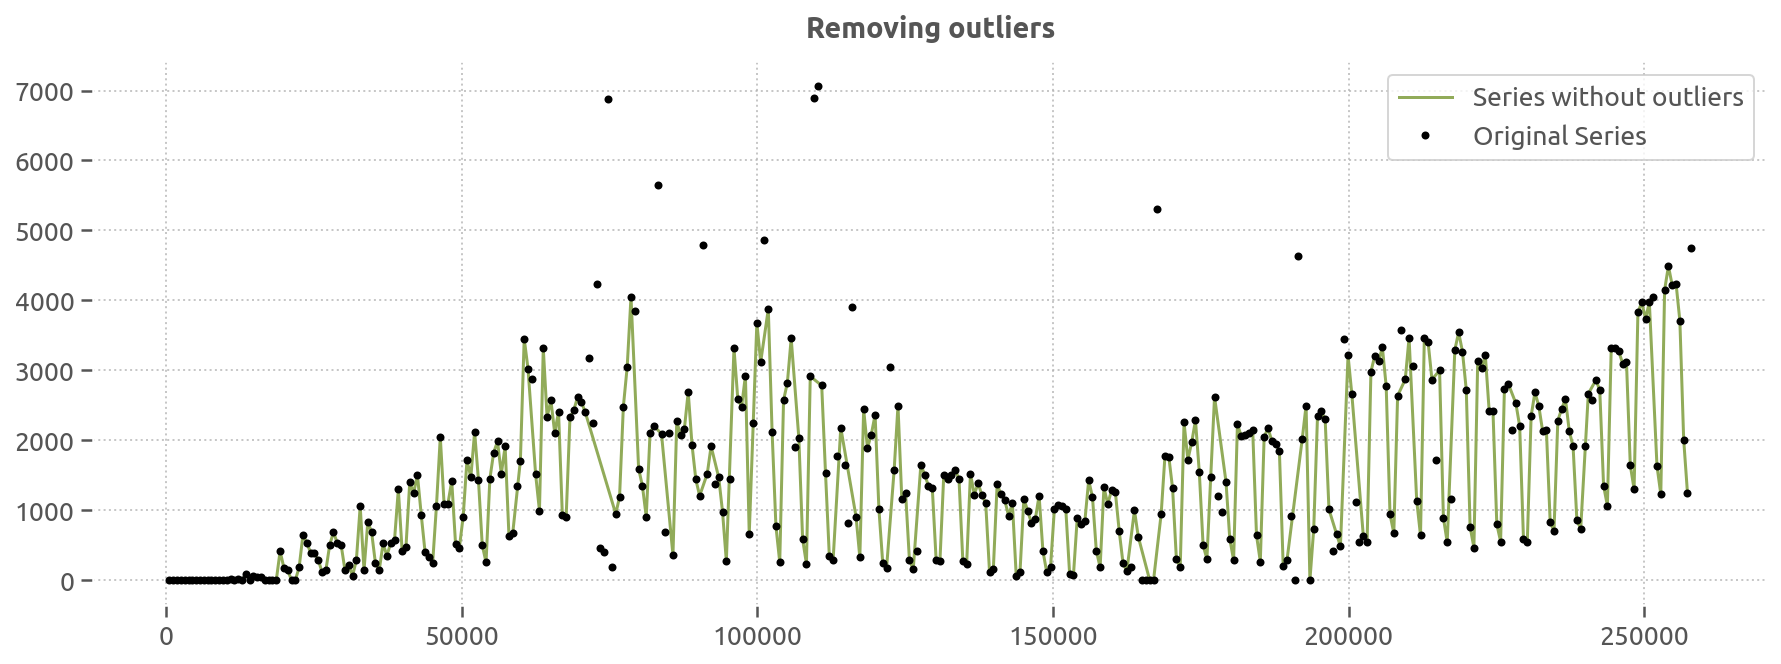

In [22]:
plt.figure(figsize=(15,5))
plt.plot(sem_outliers['index'], sem_outliers.y)
plt.plot(df.index, df['y'], 'k.')
plt.gca().set(title='Removing outliers')
plt.legend(labels=['Series without outliers', 'Original Series'])
plt.show()

In [23]:
df_sem_outliers = sem_outliers[['ds', 'y']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


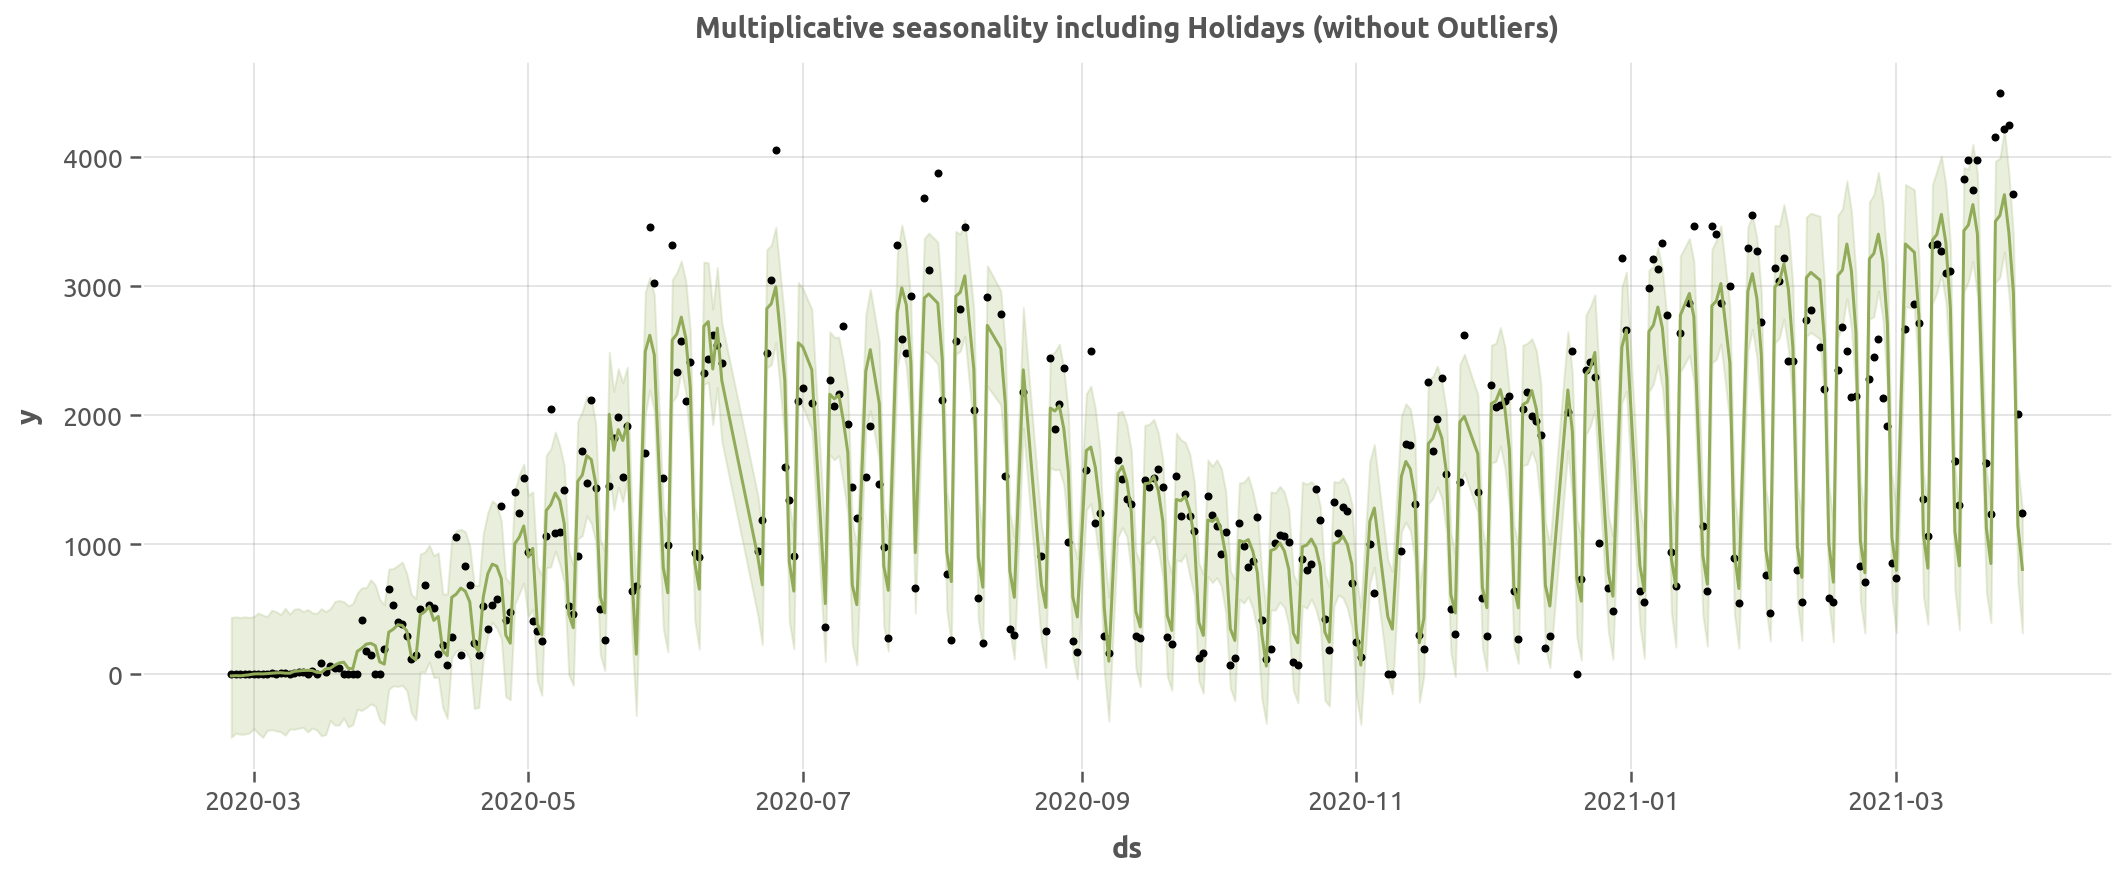

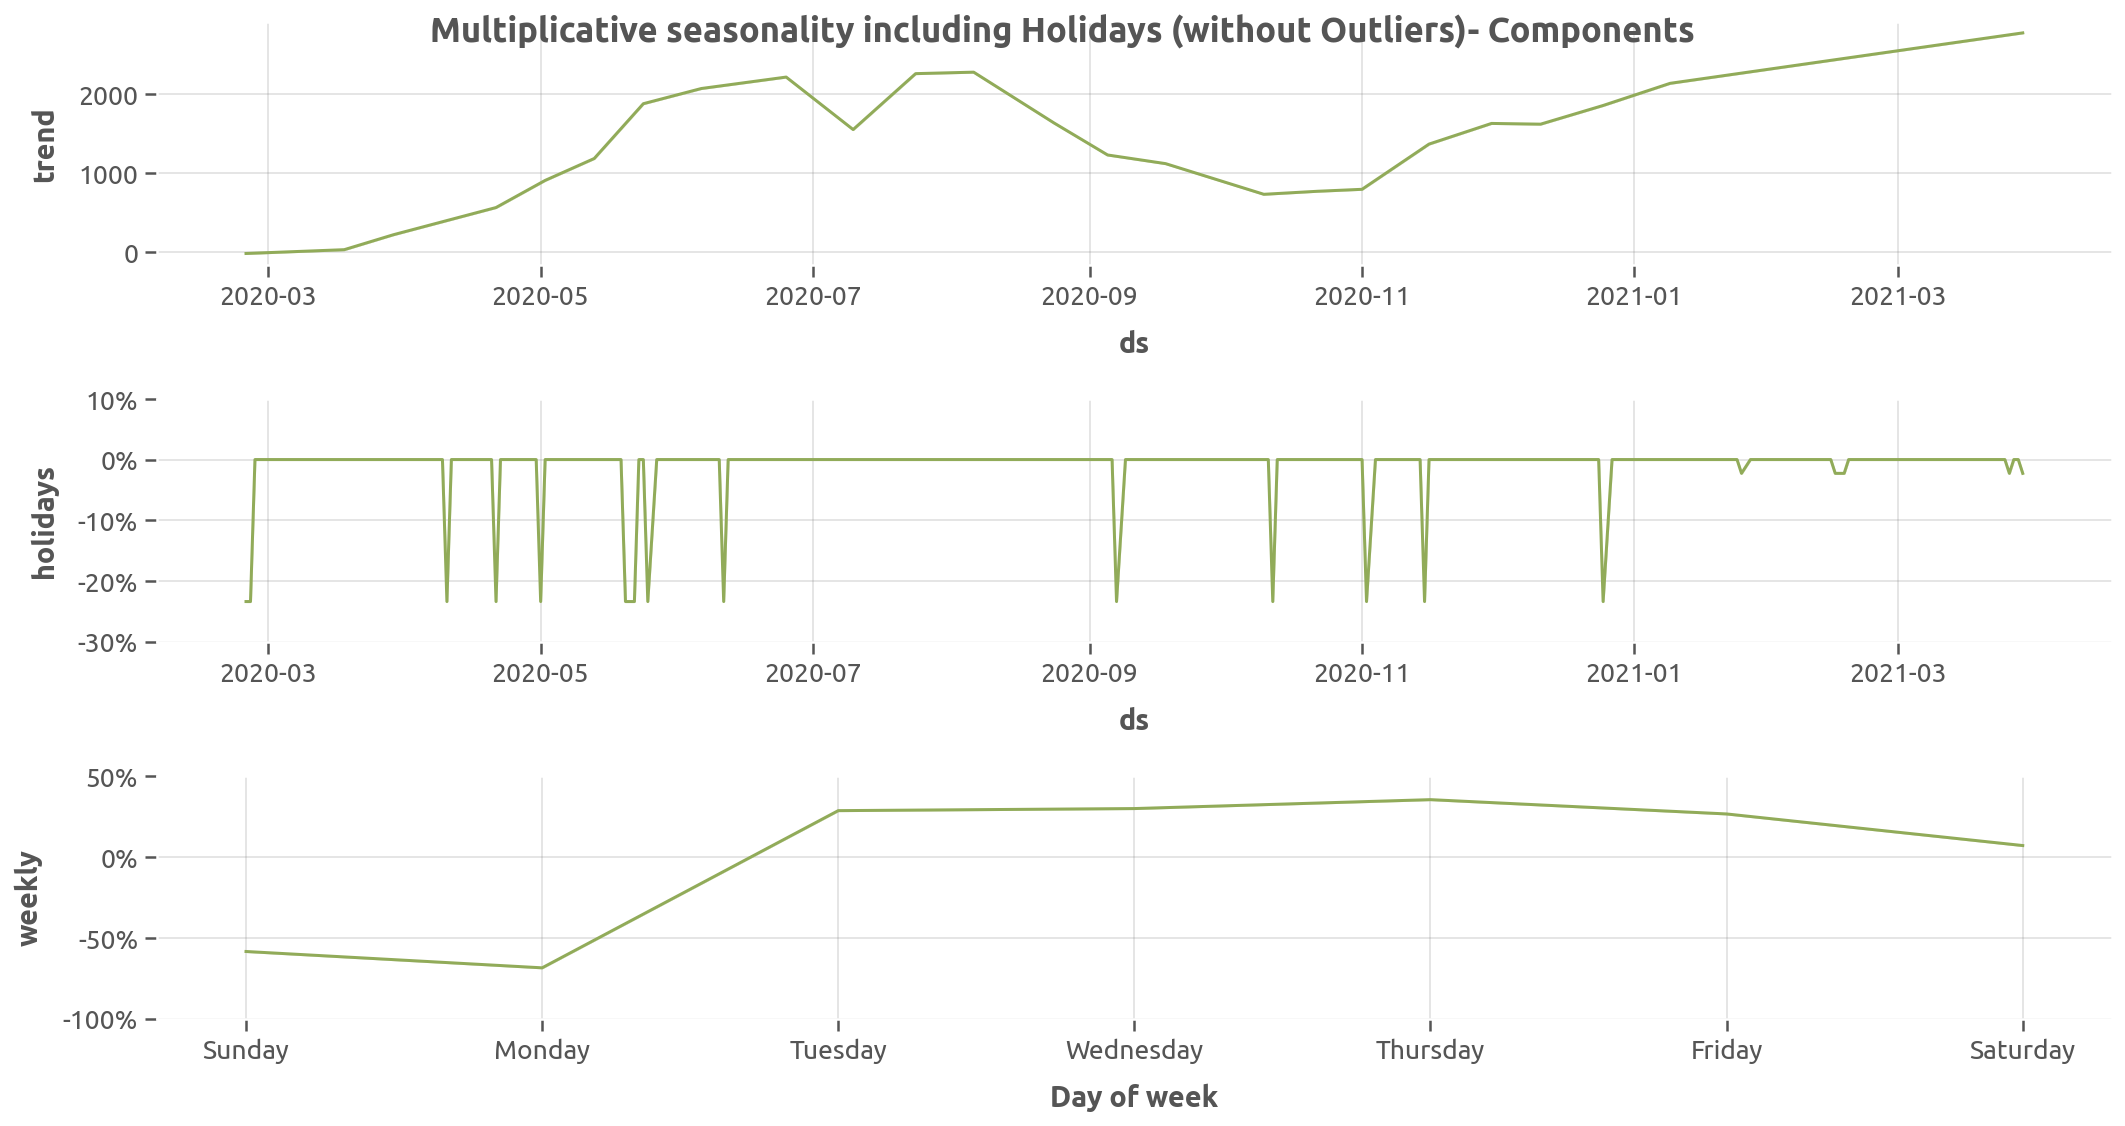

In [29]:
previsao, modelo_feriados = comparing_seasonalities(df_sem_outliers, periods=0, 
                                        seasonality_mode='multiplicative',
                                        title='Multiplicative seasonality including Holidays (without Outliers)',
                                        lineplot = False,
                                        returns_MAE = False)

Note que o limite da escala vertical era de 7000 originalmente, e cai pra 4000 ao retirar os outliers

Agora faremos uma previsão a partir desta série

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


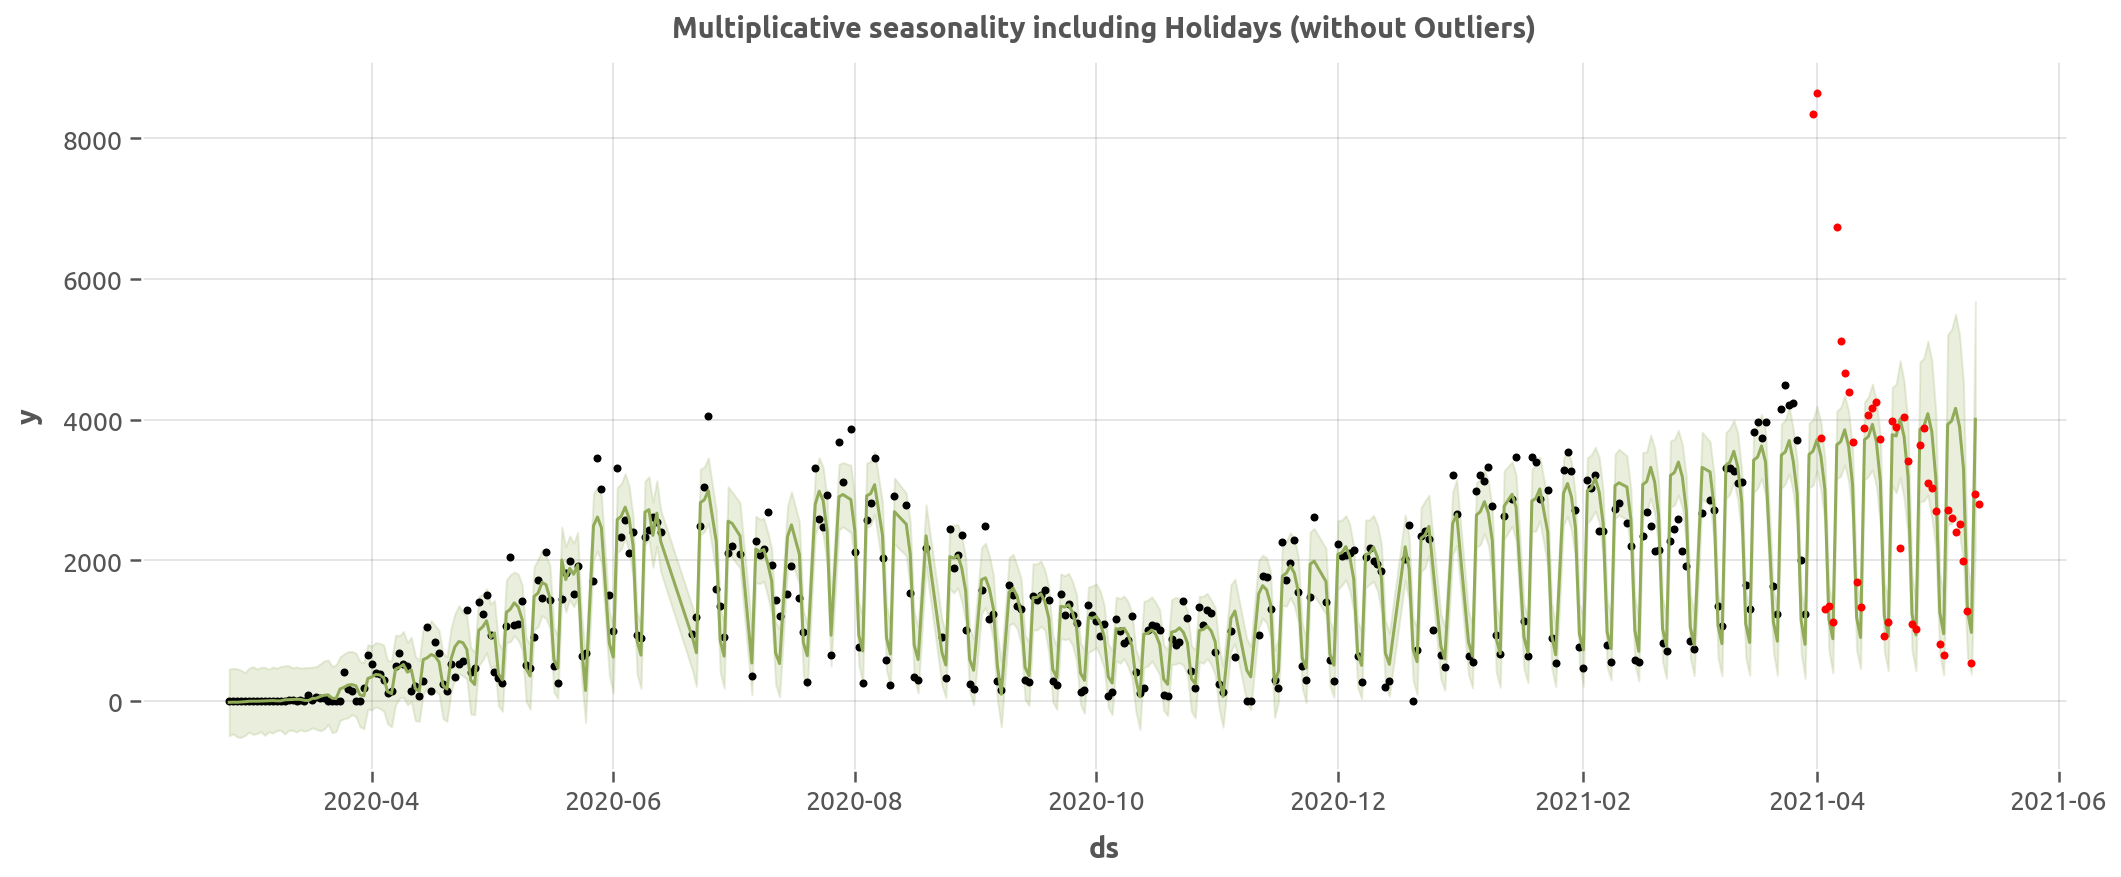

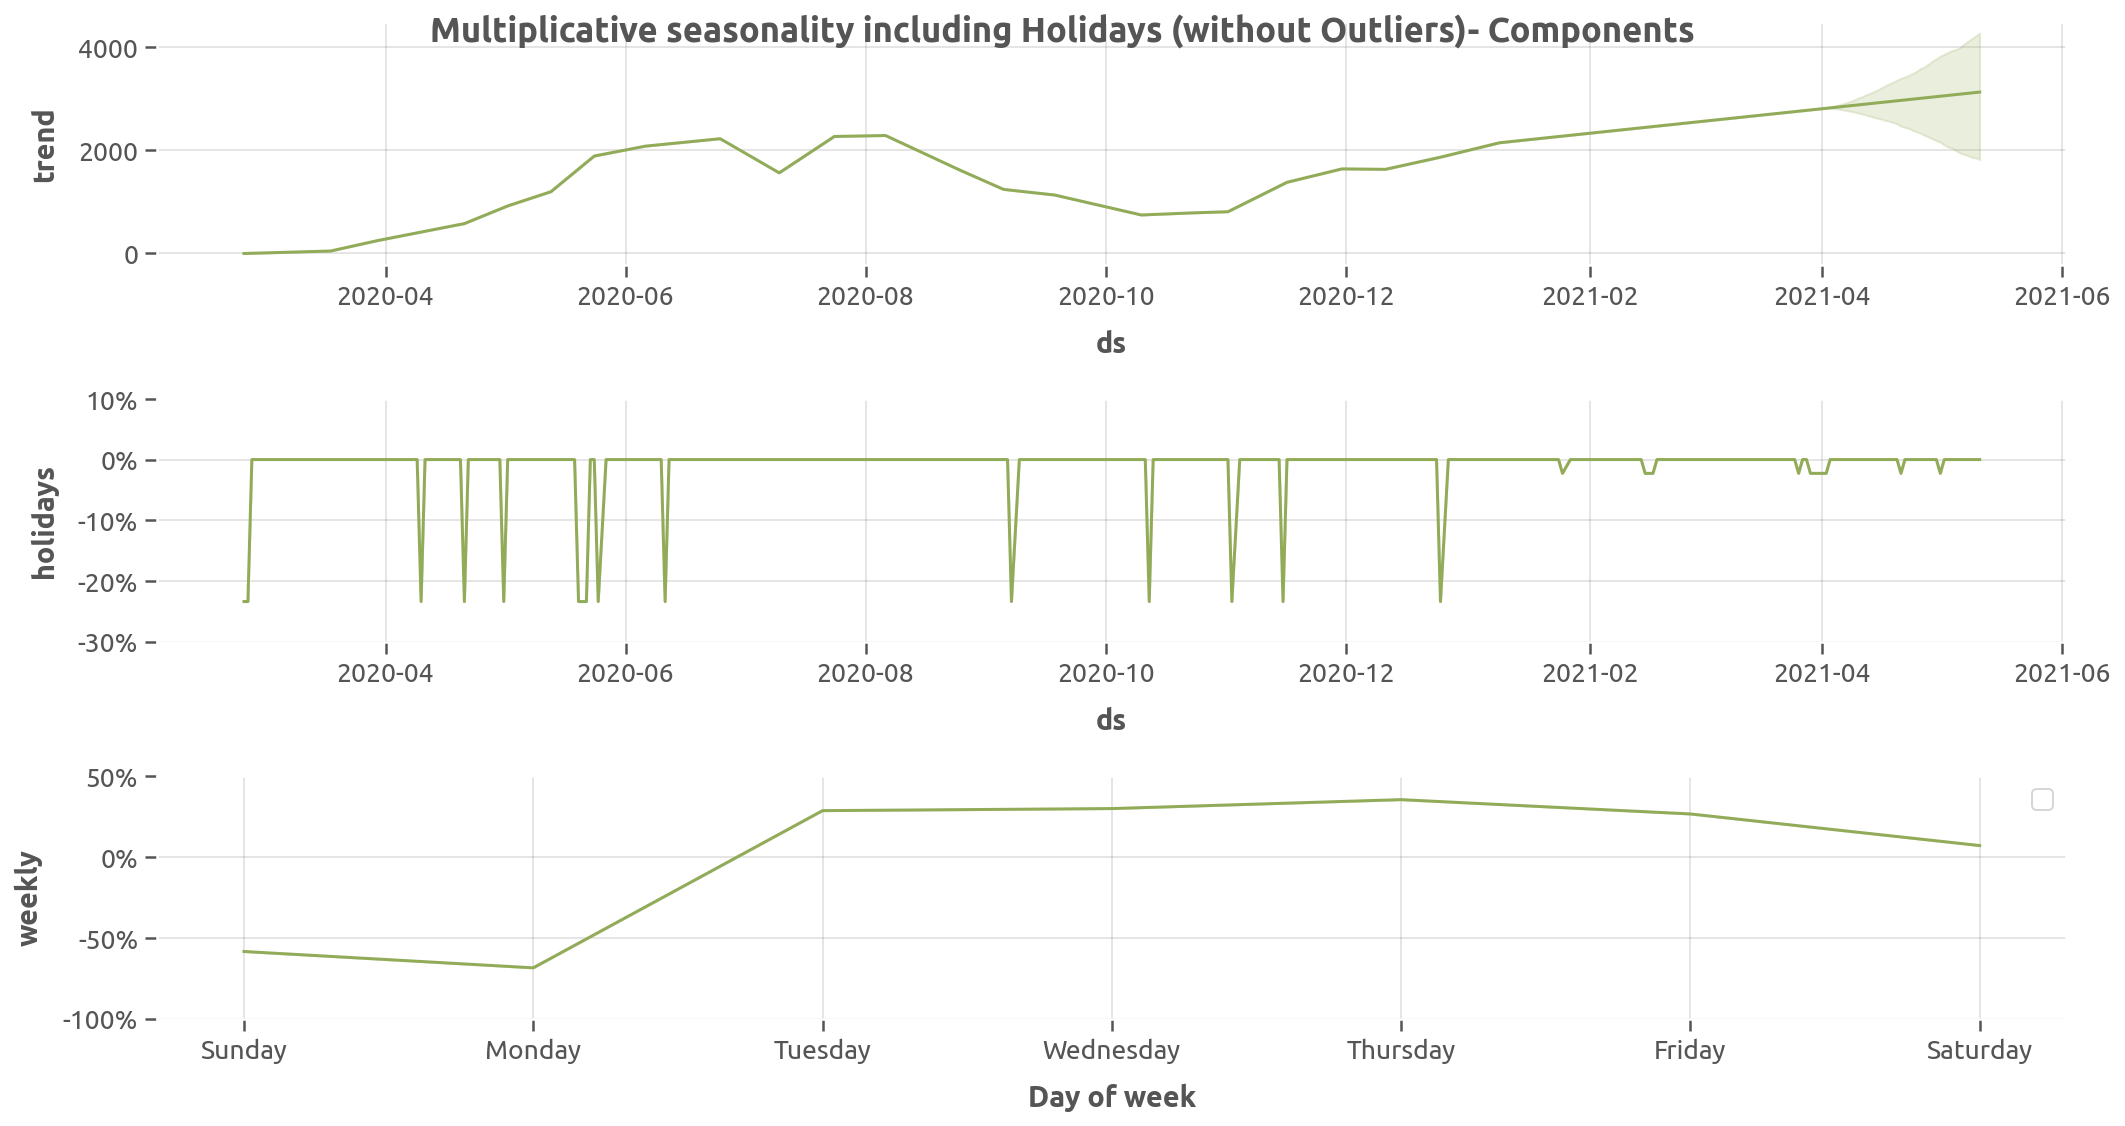

In [94]:
previsao, modelo_feriados = comparing_seasonalities(df_sem_outliers, periods=43, 
                                        seasonality_mode='multiplicative',
                                        title='Multiplicative seasonality including Holidays (without Outliers)',
                                        lineplot = False,
                                        returns_MAE = False,
                                        plot_validation_dots=True)

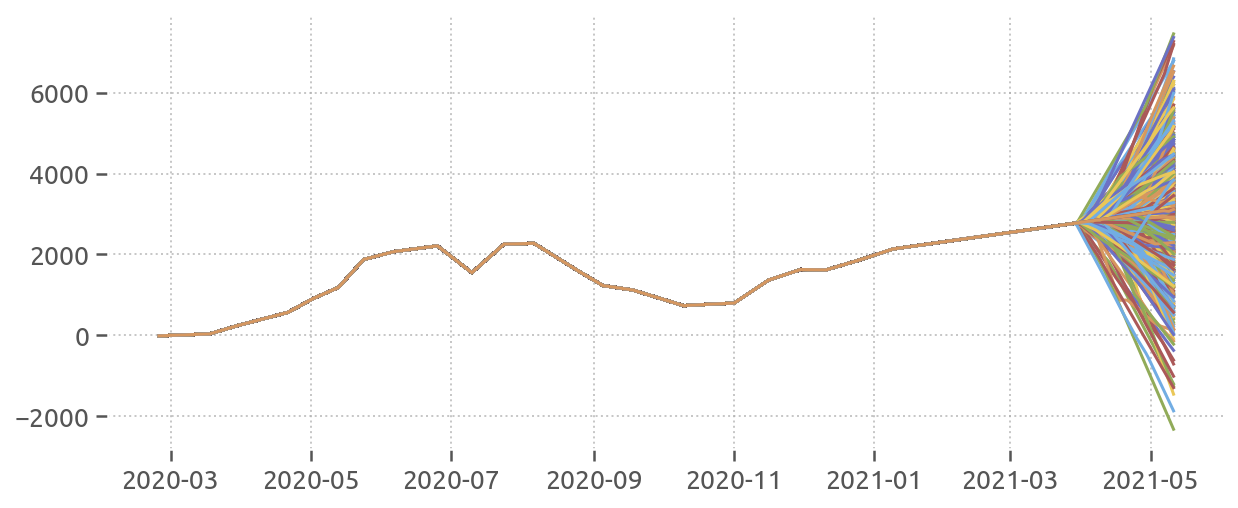

In [32]:
amostras = modelo_feriados.predictive_samples(previsao)
plt.figure(figsize=(10,4))
plt.plot(previsao.ds, amostras['trend']);

## Validação cruzada e métricas de avaliação

https://facebook.github.io/prophet/docs/diagnostics.html

In [99]:
from prophet.diagnostics import cross_validation

In [100]:
df_cv = cross_validation(modelo_feriados, initial='180 days', period='30 days', horizon='30 days')

INFO:prophet:Making 7 forecasts with cutoffs between 2020-08-31 00:00:00 and 2021-02-27 00:00:00
100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


In [103]:
df_cv.head()

ds         yhat   yhat_lower   yhat_upper     y     cutoff
0 2020-09-02  1929.956056  1543.869195  2338.922417  1579 2020-08-31
1 2020-09-03  2117.172807  1683.735391  2546.898374  2496 2020-08-31
2 2020-09-04  2032.946704  1577.244760  2501.946174  1166 2020-08-31
3 2020-09-05  1506.564122  1058.681262  1953.226027  1245 2020-08-31
4 2020-09-06   642.457939   203.017609  1050.722693   290 2020-08-31

In [105]:
janela = 1  #mudar o valor da janela para verificar as janelas utilizadas para a validação dos resultados.
#cutoff é onde começam os valores de teste
cutoff = df_cv.cutoff.unique()[janela]
cutoff
# intervalos de 30 dias

numpy.datetime64('2020-09-30T00:00:00.000000000')

In [107]:
df_cv_cut = df_cv[df_cv.cutoff.values == cutoff]

Text(0.5, 0, 'ds')

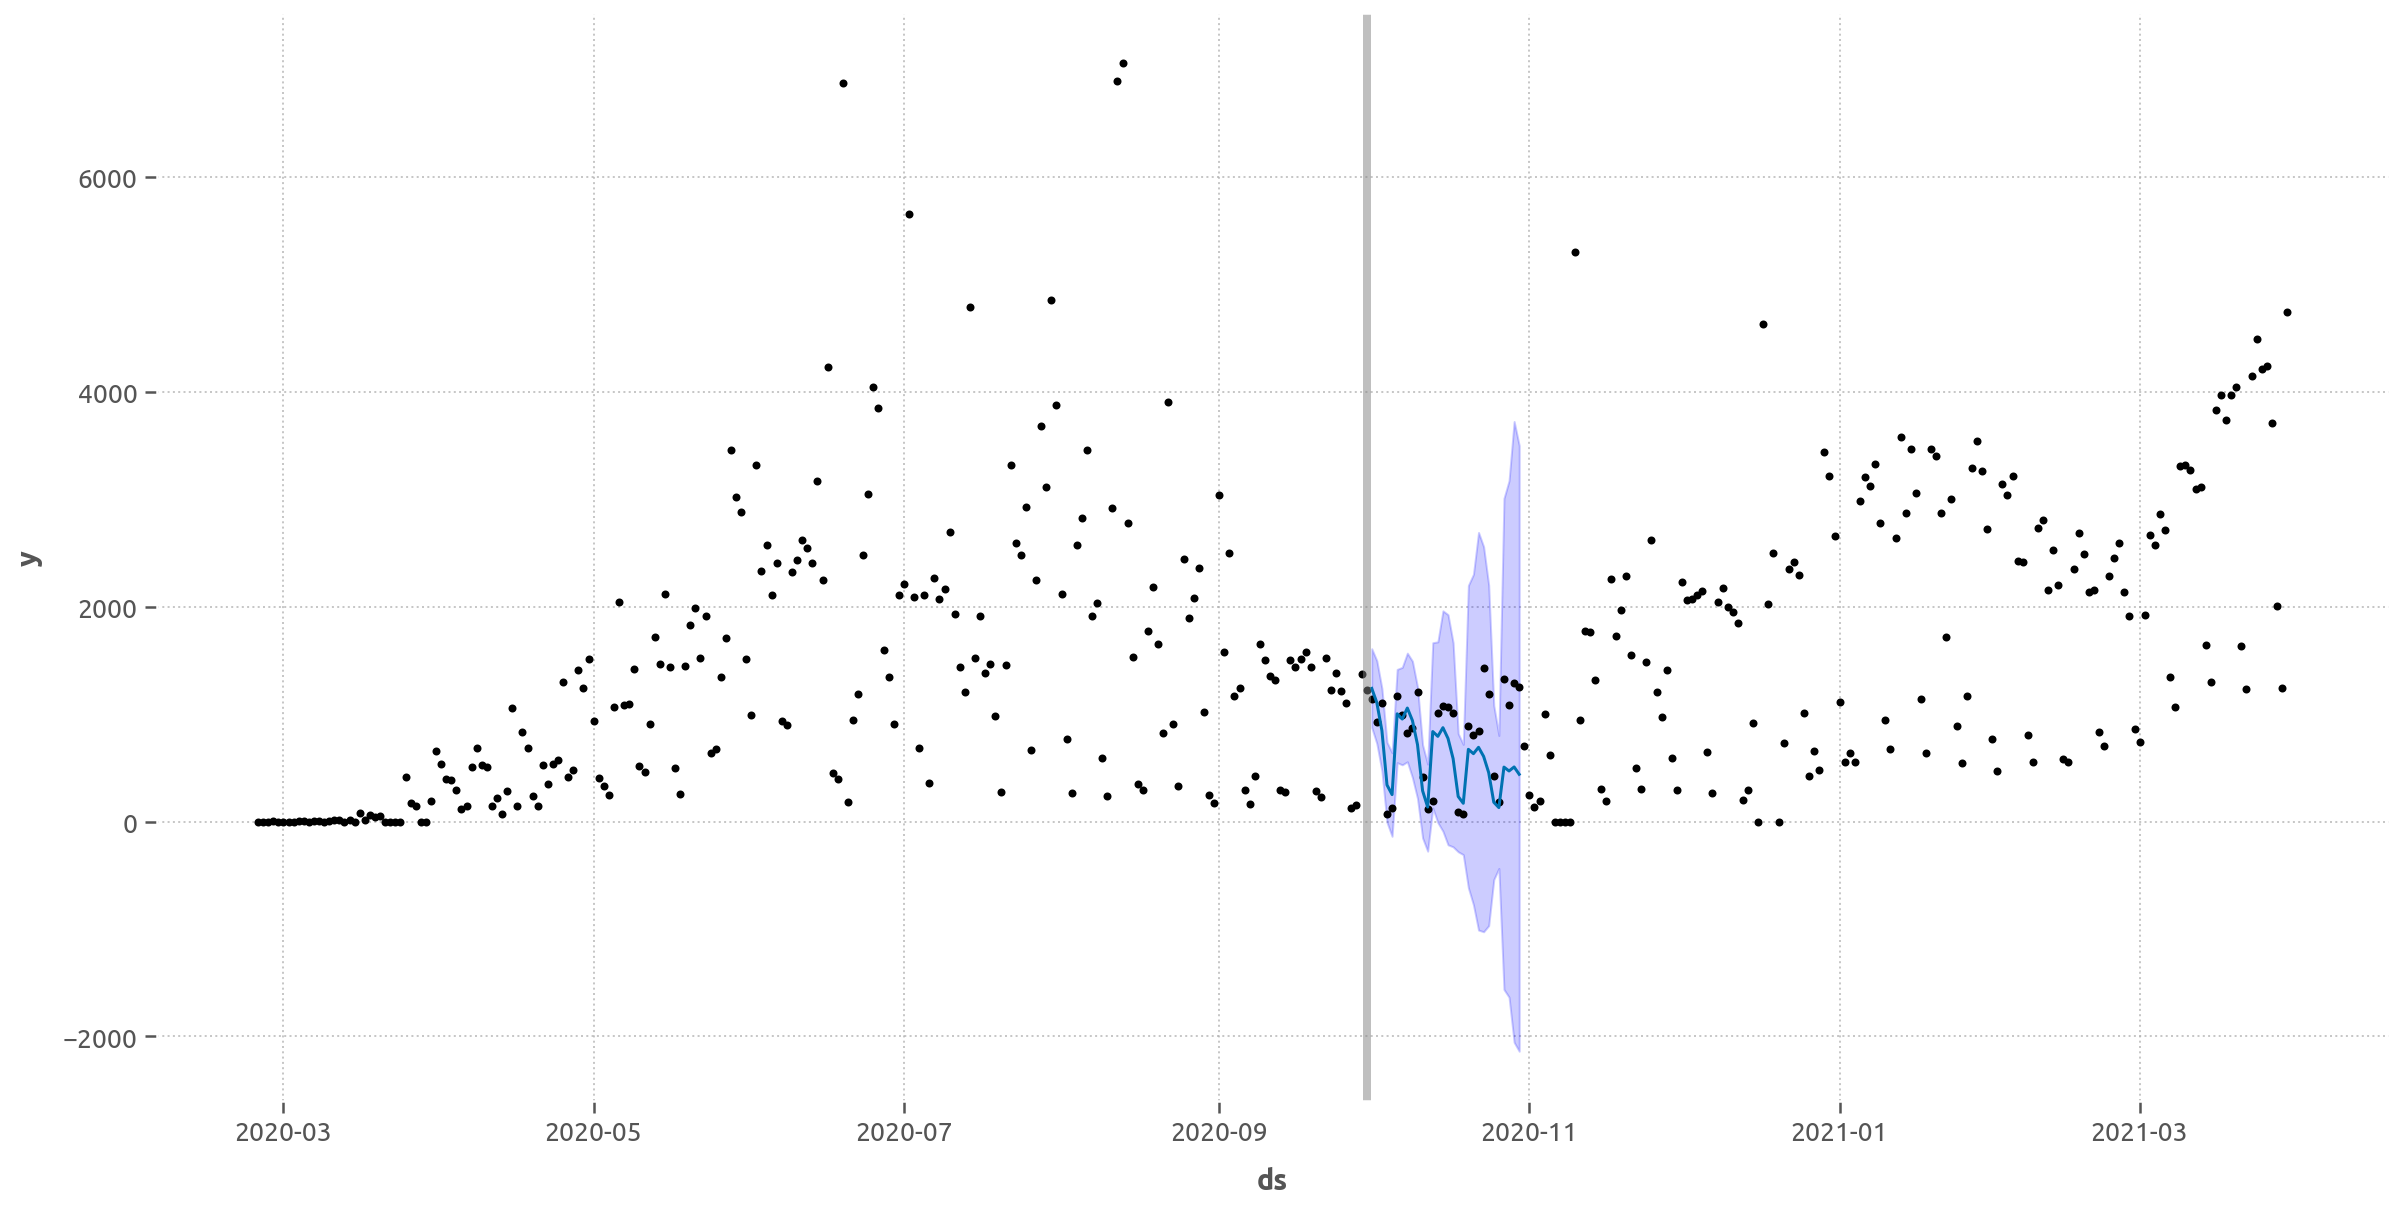

In [108]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(modelo.history['ds'].values, modelo.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

no caso de séries temporais, não faz sentido usar dados futuros para validação cruzada, como poderia ser feito em outros tipos de dados

In [110]:
from prophet.diagnostics import performance_metrics

In [111]:
df_p = performance_metrics(df_cv)
df_p

INFO:prophet:Skipping MAPE because y close to 0


horizon           mse         rmse         mae     mdape     smape  \
0   3 days  6.501472e+04   254.979834  185.552826  0.130982  0.143502   
1   4 days  8.923880e+04   298.728638  225.623264  0.144697  0.239271   
2   5 days  8.413002e+04   290.051750  221.423493  0.171992  0.264229   
3   6 days  1.067293e+05   326.694480  258.037912  0.168548  0.312452   
4   7 days  7.863970e+04   280.427710  230.165813  0.140671  0.229519   
5   8 days  1.807917e+05   425.196058  336.630401  0.168207  0.274914   
6   9 days  1.717700e+05   414.451414  320.802407  0.165895  0.333450   
7  10 days  1.869277e+05   432.351316  356.821356  0.248376  0.437045   
8  11 days  1.386732e+05   372.388491  330.494723  0.192033  0.393284   
9  12 days  1.466023e+05   382.886809  318.218381  0.178522  0.276349   
10 13 days  1.956172e+05   442.286311  346.071498  0.153724  0.280679   
11 14 days  2.440439e+05   494.008007  386.013436  0.187603  0.363175   
12 15 days  3.364266e+05   580.022936  475.128174  0.472292  0.443656   
13 16 days  3.142081e+05   560.542701  456.120586  0.389771  0.408707   
14 17 days  3.182226e+05   564.112251  462.778633  0.331290  0.353402   
15 18 days  3.814240e+05   617.595376  469.315433  0.269647  0.363209   
16 19 days  4.541940e+05   673.939184  522.795969  0.253591  0.386426   
17 20 days  5.333485e+05   730.307111  575.315218  0.261886  0.407200   
18 21 days  6.381922e+05   798.869352  644.725337  0.311400  0.500916   
19 22 days  7.211057e+05   849.179416  667.719825  0.388190  0.501146   
20 23 days  5.962043e+05   772.142697  596.722689  0.367967  0.472306   
21 24 days  4.446927e+05   666.852861  505.417370  0.282236  0.391667   
22 25 days  4.138047e+05   643.276549  495.287251  0.353476  0.384359   
23 26 days  8.020011e+05   895.545136  652.937498  0.284595  0.406924   
24 27 days  1.001545e+06  1000.771986  768.745381  0.360514  0.483402   
25 28 days  1.112529e+06  1054.764988  824.393571  0.471688  0.520758   
26 29 days  9.868465e+05   993.401499  783.677595  0.590254  0.539112   
27 30 days  7.907216e+05   889.225258  690.385858  0.590254  0.523830   

    coverage  
0   0.944444  
1   0.935185  
2   0.944444  
3   0.833333  
4   0.833333  
5   0.666667  
6   0.722222  
7   0.755556  
8   0.904762  
9   0.904762  
10  0.833333  
11  0.682540  
12  0.571429  
13  0.555556  
14  0.611111  
15  0.638889  
16  0.666667  
17  0.633333  
18  0.587302  
19  0.603175  
20  0.666667  
21  0.753968  
22  0.809524  
23  0.796296  
24  0.730159  
25  0.658730  
26  0.650794  
27  0.666667

In [113]:
from prophet.plot import plot_cross_validation_metric

matplotlib.figure.Figure

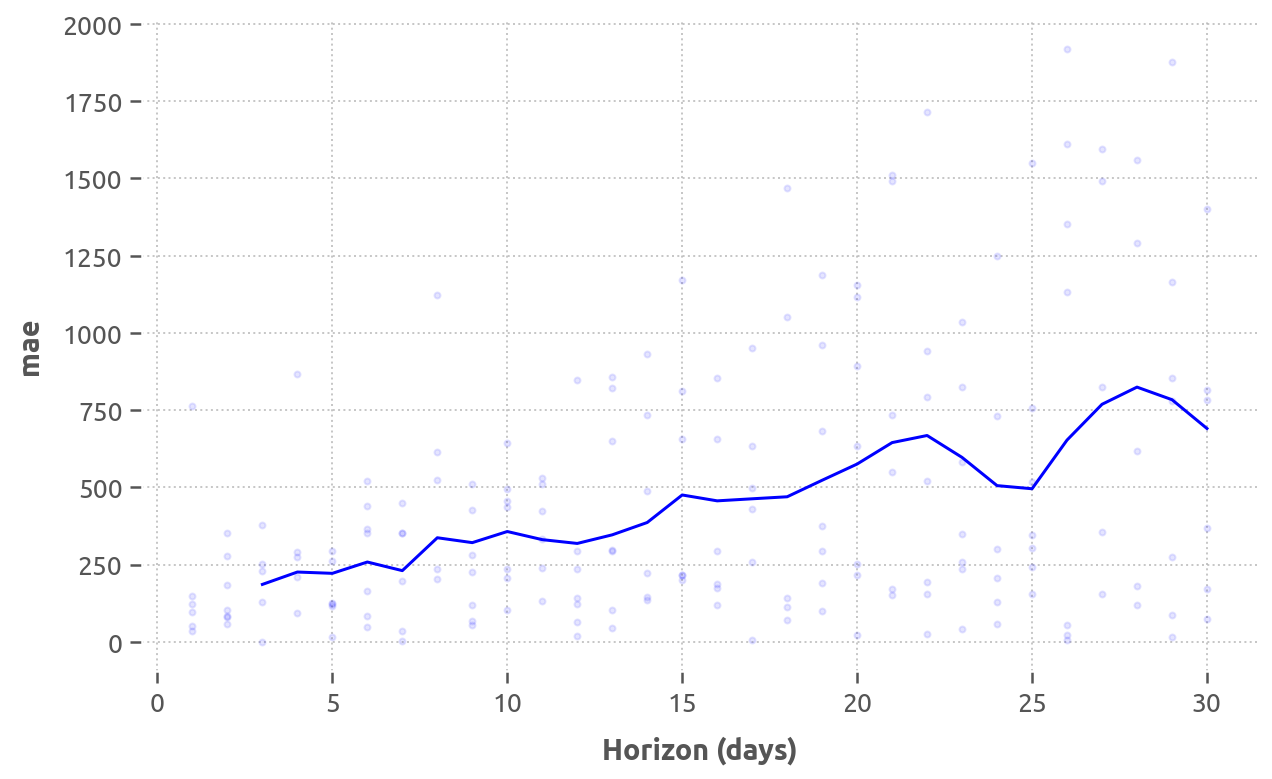

In [116]:
#metrics = ['mse', 'rmse', 'mae', 'mape', 'coverage']
a = plot_cross_validation_metric(df_cv, metric='mae', color='');
type(a)